# AIS WBM
---
### Script for the WBM side of GBM
+ The saved, optimised trained model will be used to predict SOG 
+ Predicted SOG then converted to STW
+ STW then will be used to predict FOC
+ Power estimation using [HoltropMennen84](https://repository.tudelft.nl/islandora/object/uuid%3Aca12a502-fc85-45e4-a078-db7284127e3c)
---
### General Remarks 
+ Please remember to save the model used in BBM part
+ This file should be saved on local directory
+ Running time is significantly shorter 
---
### Package initialisation
+ Loading of standard packages

In [146]:
import pandas as pd
import numpy as np
import math
import joblib
import matplotlib.pyplot as plt
# Gridpsec used for plotting
import matplotlib.gridspec as gridspec

### Loading of models 

In [147]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif"
# })

# model_rfr_ftr = joblib.load('savemodel_rfr_ftr.sav')
# model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov.sav')

# model_etr = joblib.load('savemodel_etr.sav')
# model_etr_hpov = joblib.load('savemodel_etr_hpov.sav')

# model_dtr_ftr = joblib.load('savemodel_dtr_ftr.sav')
# model_dtr_hpov = joblib.load('savemodel_dtr_hpov.sav')

# model_mlr_ftr = joblib.load('savemodel_mlr_ftr.sav')

In [148]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

model_rfr_ftr = joblib.load('savemodel_rfr_ftr_all.sav')
model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov_all.sav')

model_etr = joblib.load('savemodel_etr_all.sav')
model_etr_hpov = joblib.load('savemodel_etr_hpov_all.sav')

model_dtr_ftr = joblib.load('savemodel_dtr_ftr_all.sav')
model_dtr_hpov = joblib.load('savemodel_dtr_hpov_all.sav')

model_mlr_ftr = joblib.load('savemodel_mlr_ftr_all.sav')

### Loading dataset

In [149]:
# Parameter to plot in latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

# Load the data to the script

# dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
# dfmain = dfmain[dfmain['LAT'] > 55.04 ]
dfmain = pd.read_csv("07_AIS_Weather_Hammershus_Adjustment.csv",parse_dates=["Time"])



dfpre = pd.read_csv("01_AIS_Weather_Hammershus_Rename.csv",parse_dates=["Time"])
# dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [150]:
# dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
# dfmain = dfmain[dfmain['LAT'] > 55.04 ]

# dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
# dfpre = dfpre[dfpre['LAT'] > 55.04 ]

### Same as main script, preprocessing of current and wind 

In [151]:
# Drop the wind speed and current speed from the original dataset as it contains outlier 

dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [152]:
# Drop all dulplicate feature in dataset "AIS_weather_h_rename_copy.csv"

dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.describe()

eastwind    northwind  eastcurrent  northcurrent   Width  Length
count  8757.000000  8757.000000  2327.000000   2327.000000  8757.0  8757.0
mean      1.925214     0.369892     0.016358      0.004592    25.0   158.0
std       5.424935     4.401074     0.098862      0.081811     0.0     0.0
min     -15.766171   -12.824582    -0.491010     -0.362739    25.0   158.0
25%      -1.970517    -2.572080    -0.036956     -0.042339    25.0   158.0
50%       2.233890     0.358651     0.019653      0.004664    25.0   158.0
75%       5.887030     3.343947     0.072544      0.052015    25.0   158.0
max      16.338177    14.519458     0.397917      0.364966    25.0   158.0

Imputing value in the preprocessed dataset

In [153]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [154]:
x_pre = imputer.transform(dfpre)

In [155]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [156]:
# Calculate current and wind speed

dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [157]:
dfpre.describe()

eastwind    northwind  eastcurrent  northcurrent   Width  Length  \
count  8757.000000  8757.000000  8757.000000   8757.000000  8757.0  8757.0   
mean      1.925214     0.369892     0.015703      0.005563    25.0   158.0   
std       5.424935     4.401074     0.081205      0.064240     0.0     0.0   
min     -15.766171   -12.824582    -0.491010     -0.362739    25.0   158.0   
25%      -1.970517    -2.572080    -0.022685     -0.029143    25.0   158.0   
50%       2.233890     0.358651     0.018328      0.007771    25.0   158.0   
75%       5.887030     3.343947     0.061227      0.038838    25.0   158.0   
max      16.338177    14.519458     0.397917      0.364966    25.0   158.0   

       Current Speed   Wind Speed  
count    8757.000000  8757.000000  
mean        0.089005     6.561079  
std         0.055459     3.096838  
min         0.000735     0.193221  
25%         0.046524     4.159611  
50%         0.076852     6.302331  
75%         0.119249     8.639280  
max         0.497666    18.574455

In [158]:
# Calculate the True North wind direction and split them into quadrants

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))


In [159]:
# Calculate the True North current direction and split them into quadrants

condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [160]:
# Descriptive statistics of the dataset for true north weather direction

dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','Width','Length'],axis=1)

In [161]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

Unnamed: 0                Time        LON        LAT  \
0           0 2021-01-01 00:00:00  14.689663  55.098452   
1           1 2021-01-01 01:00:00  14.689658  55.098451   
2           2 2021-01-01 02:00:00  14.689649  55.098468   
3           3 2021-01-01 03:00:00  14.689646  55.098471   
4           4 2021-01-01 04:00:00  14.689644  55.098462   

   Temperature above oceans  Air density above oceans  Max wave height  \
0                277.311035                  1.259323         1.893614   
1                277.328369                  1.259985         1.752303   
2                277.390625                  1.260244         1.619775   
3                277.411377                  1.260148         1.518736   
4                277.430664                  1.260634         1.455034   

   Swell period  Wind wave period  Wave period  ...  Draught  \
0      4.818881          3.818459     4.154329  ...      5.0   
1      4.755800          3.470216     4.130580  ...      5.0   
2      4.645083          3.259682     4.083755  ...      5.0   
3      4.588384          3.177906     4.010502  ...      5.0   
4      4.528841          3.281654     3.913362  ...      5.0   

   True Wind Direction  True Current Direction  True Swell Direction  \
0           155.408180              105.591754             22.854050   
1           158.458891               99.679168             26.122772   
2           163.749663               99.679168             28.498383   
3           170.724504              116.740448             29.956985   
4           179.505940               99.679168             34.486298   

   True Wind Wave Direction  True Wave Direction  Current Speed  Wind Speed  \
0                 22.749664            22.610062       0.122270    7.112664   
1                 19.152008            22.209274       0.082234    6.653538   
2                 12.424911            20.857971       0.080286    6.488697   
3                  6.725922            18.732071       0.099846    6.104632   
4                  3.761627            15.731430       0.080016    6.181707   

   True North Wind Direction  True North Current Direction  
0                 251.408180                     68.408246  
1                 254.458891                     43.254661  
2                 259.749663                     27.719662  
3                 266.724504                     57.259552  
4                 174.494060                      2.978495  

[5 rows x 30 columns]

### SOG threshold
+ The threshold for the ships manouvering speed will be 5 knots ([Abebe20](https://doi.org/10.3390/app10072325),[Yan21](https://doi.org/10.1016/j.tre.2020.101930))
+ Alternatively, outlier rejection using &mu; &plusmn; 3&sigma; ([Gkerekos19](https://doi.org/10.1016/j.oceaneng.2019.106282)), this should increase the threshold to about 8 knots

In [162]:
# SOG threshold according to Abebe20 and Yan21

df = df[df['SOG'] > 0 ]


# df = df[df['SOG'] > 5 ]

# # Improve model performance ? , reduce skew of the dataset by removing outliers mu pm 3sigma 

# df = df[df['SOG'] > 8 ]

### Data split into testing dataset
+ The `random_state` is 42, however to gain different datasets, change the `random_state` to other numbers (arbitrary), but make sure the same ``random_state`` is applied to the main BBM script that is used for the split
+ The testing dataset is further split into
    + Summer dataset ``dfsummer``
    + Winter dataset ``dfwinter``
    + Year dataset ``dfyear``, which represents the ``test_set``

In [163]:
# Exclude data for the month of June to check the model's forecasting performance 

from sklearn.model_selection import train_test_split

#When performing the split, make sure that the random state is the same as the training script

train_set, test_set = train_test_split(df, test_size=0.25, random_state=42)

print("Summer Dataset Breakdown")
dfMay = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-05']
print(f"length of May dataset {len(dfMay)}")
dfJune = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-06']
print(f"length of June dataset {len(dfJune)}")
dfJuly = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-07']
print(f"length of July dataset {len(dfJuly)}")
dfAug = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-08']
print(f"length of August dataset {len(dfAug)}")
dfSep = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-09']
print(f"length of Sept dataset {len(dfSep)}")
dfOct = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-10']
print(f"length of Oct dataset {len(dfOct)}")

print("Winter Dataset Breakdown")
dfNov = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-11']
print(f"length of Nov dataset {len(dfNov)}")
dfDec = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-12']
print(f"length of Dec dataset {len(dfDec)}")
dfJan = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-01']
print(f"length of Jan dataset {len(dfJan)}")
dfFeb = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-02']
print(f"length of Feb dataset {len(dfFeb)}")
dfMar = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-03']
print(f"length of March dataset {len(dfMar)}")
dfApr = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-04']
print(f"length of April dataset {len(dfApr)}")


frames_summer = [dfMay,dfJune,dfJuly,dfAug,dfSep,dfOct]
frames_winter = [dfNov,dfDec,dfJan,dfFeb,dfMar,dfApr]

dfsummer = pd.concat(frames_summer)
dfwinter = pd.concat(frames_winter)
dfyear = test_set

Summer Dataset Breakdown
length of May dataset 96
length of June dataset 114
length of July dataset 146
length of August dataset 135
length of Sept dataset 116
length of Oct dataset 138
Winter Dataset Breakdown
length of Nov dataset 109
length of Dec dataset 120
length of Jan dataset 125
length of Feb dataset 116
length of March dataset 107
length of April dataset 108


Descriptive statistics of different datasets

In [164]:
print(dfsummer.describe())

        Unnamed: 0         LON         LAT  Temperature above oceans  \
count   745.000000  745.000000  745.000000                745.000000   
mean   5195.546309   13.618208   55.173168                288.197733   
std    1236.416507    0.873287    0.304058                  3.737520   
min    2882.000000   10.653272   54.477248                278.347168   
25%    4203.000000   12.866404   55.097825                285.557861   
50%    5228.000000   13.929031   55.183631                288.854492   
75%    6270.000000   14.486536   55.273822                290.984131   
max    7286.000000   14.691415   57.464056                297.026611   

       Air density above oceans  Max wave height  Swell period  \
count                735.000000       652.000000    652.000000   
mean                   1.217869         1.382263      3.969324   
std                    0.019626         1.119620      1.057867   
min                    1.170450         0.107192      1.967748   
25%                  

In [165]:
print(dfwinter.describe())

        Unnamed: 0         LON         LAT  Temperature above oceans  \
count   685.000000  685.000000  685.000000                685.000000   
mean   3600.931387   13.506536   55.215499                277.061812   
std    3211.281324    0.876790    0.206112                  3.281621   
min      17.000000   10.544123   54.475554                266.114777   
25%     987.000000   12.587750   55.123524                275.052979   
50%    2104.000000   13.591523   55.215252                277.048340   
75%    7631.000000   14.451782   55.333362                279.242920   
max    8736.000000   14.690215   57.437176                286.223145   

       Air density above oceans  Max wave height  Swell period  \
count                665.000000       575.000000    575.000000   
mean                   1.269906         1.802122      4.522565   
std                    0.022150         1.202764      1.053373   
min                    1.206596         0.176935      2.036522   
25%                  

In [166]:
print(dfyear.describe())

        Unnamed: 0          LON          LAT  Temperature above oceans  \
count  1430.000000  1430.000000  1430.000000               1430.000000   
mean   4431.692308    13.564715    55.193446                282.863393   
std    2523.292975     0.876439     0.262519                  6.587627   
min      17.000000    10.544123    54.475554                266.114777   
25%    2260.000000    12.694702    55.098454                277.200134   
50%    4658.500000    13.688262    55.200606                282.897949   
75%    6683.500000    14.472037    55.322688                288.996826   
max    8736.000000    14.691415    57.464056                297.026611   

       Air density above oceans  Max wave height  Swell period  \
count               1400.000000      1227.000000   1227.000000   
mean                   1.242587         1.579019      4.228585   
std                    0.033327         1.177651      1.090874   
min                    1.170450         0.107192      1.967748   
25%

### Data Preprocessing
+ Similar to BBM
+ Ensure that the dataset have identical data structure for the trained model 

In [167]:
# For Summer
dfsummer= dfsummer.drop(['Unnamed: 0','Time','LON','LAT','Width','Length'],axis=1)
# For Winter
dfwinter= dfwinter.drop(['Unnamed: 0','Time','LON','LAT','Width','Length'],axis=1)
# For the whole year of 2021
dfyear= dfyear.drop(['Unnamed: 0','Time','LON','LAT','Width','Length'],axis=1)


In [168]:
# # For Summer
# dfsummer= dfsummer.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
# 'Surface pressure','Width','Length'],axis=1)
# # For Winter
# dfwinter= dfwinter.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
# 'Surface pressure','Width','Length'],axis=1)
# # For the whole year of 2021
# dfyear= dfyear.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
# 'Surface pressure','Width','Length'],axis=1)


In [169]:
#For Summer
dfsummer= dfsummer.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir',
                            'Air density above oceans' : 'rho_air_ao',
                            'Surface pressure' : 'p_seasurf',
                           }, axis=1) 
#For Winter
dfwinter= dfwinter.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir','Air density above oceans' : 'rho_air_ao',
                            'Surface pressure' : 'p_seasurf',
                           }, axis=1) 
#For the whole year
dfyear= dfyear.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir','Air density above oceans' : 'rho_air_ao',
                            'Surface pressure' : 'p_seasurf',
                           }, axis=1) 

In [170]:
# # Rearrange column to match model 
# # Also dropping the features as described in the main script

# # For summer 

# df_summer = dfsummer[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir']]
# # For Winter

# df_winter = dfwinter[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir']]
# # For the whole year

# df_year = dfyear[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir']]

In [171]:
# Rearrange column to match model 
# Also dropping the features as described in the main script

# For summer 

df_summer = dfsummer[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir','rho_air_ao','p_seasurf']]
# For Winter

df_winter = dfwinter[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir','rho_air_ao','p_seasurf']]
# For the whole year

df_year = dfyear[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir','rho_air_ao','p_seasurf']]

Imputing to complete the data

In [172]:
import numpy as np
from sklearn.impute import KNNImputer

imputer_s = KNNImputer(n_neighbors=50)
imputer_s.fit(df_summer)

# Transform imputed summer dataset

xsummer = imputer_s.transform(df_summer)

# Column heading set same

df_summer_tr = pd.DataFrame(xsummer, columns=df_summer.columns, index=df_summer.index)

In [173]:
# Impute for winter data 

imputer_w = KNNImputer(n_neighbors=50)
imputer_w.fit(df_winter)

# Transform imputed winter dataset

xwinter = imputer_w.transform(df_winter)

#Column heading set same 

df_winter_tr = pd.DataFrame(xwinter, columns=df_winter.columns, index=df_winter.index)


In [174]:
# Impute for yearly data 

imputer_yr = KNNImputer(n_neighbors=50)
imputer_yr.fit(df_year)

# Transform imputed year dataset 

xyear = imputer_yr.transform(df_year)

#Column heading set same

df_year_tr = pd.DataFrame(xyear, columns=df_year.columns, index=df_year.index)

In [175]:
df_year_tr.describe()

oceantemperature   waveheight  swellperiod  windwaveperiod  \
count       1430.000000  1430.000000  1430.000000     1430.000000   
mean         282.863393     1.591477     4.236306        3.413332   
std            6.587627     1.104990     1.021596        0.944148   
min          266.114777     0.107192     1.967748        1.570717   
25%          277.200134     0.763643     3.496677        2.728874   
50%          282.897949     1.357673     4.194898        3.385638   
75%          288.996826     2.081702     4.883213        3.864906   
max          297.026611     7.311599     7.517778        7.092444   

        waveperiod     surftemp  windwaveswellheight  swellheight  \
count  1430.000000  1430.000000          1430.000000  1430.000000   
mean      3.800815   283.782673             0.834920     0.383074   
std       0.897324     5.884012             0.565738     0.188954   
min       1.967748   273.048584             0.070604     0.070659   
25%       3.160237   278.317383             0.410441     0.256724   
50%       3.732456   283.468018             0.715718     0.346166   
75%       4.351097   289.384521             1.089224     0.465332   
max       7.085897   295.046387             3.780643     2.209327   

       windwaveheight      draught  ...     curspeed  truewinddir  \
count    1.430000e+03  1430.000000  ...  1430.000000  1430.000000   
mean     6.735194e-01     5.176948  ...     0.090779    90.139348   
std      5.919290e-01     0.219256  ...     0.057620    54.650059   
min      2.507146e-16     4.700000  ...     0.000980     0.040806   
25%      2.164307e-01     5.000000  ...     0.046014    40.730764   
50%      5.513306e-01     5.200000  ...     0.078059    91.371460   
75%      9.289763e-01     5.313617  ...     0.122056   140.135383   
max      3.732544e+00     5.700000  ...     0.364092   179.861808   

       truecurrentdir  trueswelldir  truewindwavedir  truewavedir  \
count     1430.000000   1430.000000      1430.000000  1430.000000   
mean        88.182907     87.100865        90.128252    87.499045   
std         54.560287     50.186588        49.265688    51.025881   
min          0.369323      0.224765         0.029311     0.125756   
25%         31.494377     44.989763        52.216062    45.302030   
50%         88.352599     85.855539        90.235297    85.349046   
75%        147.452326    127.738217       128.273126   129.975822   
max        179.779332    179.917834       179.922589   179.882823   

       truenorthwinddir  truenorthcurrentdir   rho_air_ao      p_seasurf  
count       1430.000000          1430.000000  1430.000000    1430.000000  
mean         195.554871           160.775851     1.242629  101338.205726  
std           92.168226           104.876321     0.033034     986.644412  
min            1.098283             0.143136     1.170450   97178.312500  
25%          126.725240            79.032616     1.215066  100724.015625  
50%          203.927100           135.704947     1.241320  101469.562500  
75%          275.370953           267.784540     1.269084  101991.750000  
max          359.479403           359.985910     1.348105  103961.562500  

[8 rows x 24 columns]

In [176]:
# Summer dataset
x_date_s = df_summer_tr.drop(['sog'],axis=1)
y_date_s = df_summer_tr.sog
# winter dataset
x_date_w = df_winter_tr.drop(['sog'],axis=1)
y_date_w = df_winter_tr.sog
# Year dataset
x_date_yr = df_year_tr.drop(['sog'],axis=1)
y_date_yr = df_year_tr.sog

In [177]:
print(f"Amount of the test dataset is {len(x_date_yr)}")
print(f"Amount of the summer dataset is {len(x_date_s)}")
print(f"Amount of the winter dataset is {len(x_date_w)}")

Amount of the test dataset is 1430
Amount of the summer dataset is 745
Amount of the winter dataset is 685


Histogram plots of the yearly dataset

In [178]:
# # plt.rcParams.update(plt.rcParamsDefault) # Alter default value 
# axes = df_year_tr.hist(bins=50,figsize=(10,50),color='black',grid=True,layout=(11,2))
# for ax in axes.flatten():
#     ax.grid(True, linestyle='--', alpha=0.5)
# plt.show()

In [179]:
x_date_yr.describe()

oceantemperature   waveheight  swellperiod  windwaveperiod  \
count       1430.000000  1430.000000  1430.000000     1430.000000   
mean         282.863393     1.591477     4.236306        3.413332   
std            6.587627     1.104990     1.021596        0.944148   
min          266.114777     0.107192     1.967748        1.570717   
25%          277.200134     0.763643     3.496677        2.728874   
50%          282.897949     1.357673     4.194898        3.385638   
75%          288.996826     2.081702     4.883213        3.864906   
max          297.026611     7.311599     7.517778        7.092444   

        waveperiod     surftemp  windwaveswellheight  swellheight  \
count  1430.000000  1430.000000          1430.000000  1430.000000   
mean      3.800815   283.782673             0.834920     0.383074   
std       0.897324     5.884012             0.565738     0.188954   
min       1.967748   273.048584             0.070604     0.070659   
25%       3.160237   278.317383             0.410441     0.256724   
50%       3.732456   283.468018             0.715718     0.346166   
75%       4.351097   289.384521             1.089224     0.465332   
max       7.085897   295.046387             3.780643     2.209327   

       windwaveheight      draught  ...     curspeed  truewinddir  \
count    1.430000e+03  1430.000000  ...  1430.000000  1430.000000   
mean     6.735194e-01     5.176948  ...     0.090779    90.139348   
std      5.919290e-01     0.219256  ...     0.057620    54.650059   
min      2.507146e-16     4.700000  ...     0.000980     0.040806   
25%      2.164307e-01     5.000000  ...     0.046014    40.730764   
50%      5.513306e-01     5.200000  ...     0.078059    91.371460   
75%      9.289763e-01     5.313617  ...     0.122056   140.135383   
max      3.732544e+00     5.700000  ...     0.364092   179.861808   

       truecurrentdir  trueswelldir  truewindwavedir  truewavedir  \
count     1430.000000   1430.000000      1430.000000  1430.000000   
mean        88.182907     87.100865        90.128252    87.499045   
std         54.560287     50.186588        49.265688    51.025881   
min          0.369323      0.224765         0.029311     0.125756   
25%         31.494377     44.989763        52.216062    45.302030   
50%         88.352599     85.855539        90.235297    85.349046   
75%        147.452326    127.738217       128.273126   129.975822   
max        179.779332    179.917834       179.922589   179.882823   

       truenorthwinddir  truenorthcurrentdir   rho_air_ao      p_seasurf  
count       1430.000000          1430.000000  1430.000000    1430.000000  
mean         195.554871           160.775851     1.242629  101338.205726  
std           92.168226           104.876321     0.033034     986.644412  
min            1.098283             0.143136     1.170450   97178.312500  
25%          126.725240            79.032616     1.215066  100724.015625  
50%          203.927100           135.704947     1.241320  101469.562500  
75%          275.370953           267.784540     1.269084  101991.750000  
max          359.479403           359.985910     1.348105  103961.562500  

[8 rows x 23 columns]

In [180]:
# Ignore this part for latex export

# stats_DSyear = x_date_yr.describe().transpose()
# print(stats_DSyear.to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# ))  

In [181]:
y_date_yr.describe()

count    1430.000000
mean       14.270611
std         6.407961
min         0.000273
25%        12.225047
50%        17.344856
75%        18.590115
max        21.070492
Name: sog, dtype: float64

In [182]:
x_date_s.describe()

oceantemperature  waveheight  swellperiod  windwaveperiod  waveperiod  \
count        745.000000  745.000000   745.000000      745.000000  745.000000   
mean         288.197733    1.393645     3.977398        3.311640    3.593909   
std            3.737520    1.061366     0.997774        0.910961    0.867983   
min          278.347168    0.107192     1.967748        1.570717    1.967748   
25%          285.557861    0.614089     3.238856        2.610878    2.930254   
50%          288.854492    1.115817     3.941870        3.242347    3.500018   
75%          290.984131    1.834160     4.629096        3.864895    4.135430   
max          297.026611    5.793899     6.992472        6.188758    6.191917   

         surftemp  windwaveswellheight  swellheight  windwaveheight  \
count  745.000000           745.000000   745.000000    7.450000e+02   
mean   288.580004             0.733038     0.344382    5.809598e-01   
std      3.649571             0.540636     0.159579    5.726135e-01   
min    278.303833             0.070604     0.070659    2.507146e-16   
25%    286.418457             0.334487     0.228644    1.396484e-01   
50%    289.274170             0.592041     0.316433    4.370038e-01   
75%    291.372437             0.957390     0.425670    8.076603e-01   
max    295.046387             2.950672     1.152069    2.884644e+00   

          draught  ...    curspeed  truewinddir  truecurrentdir  trueswelldir  \
count  745.000000  ...  745.000000   745.000000      745.000000    745.000000   
mean     5.193264  ...    0.084244    90.843813       89.648464     87.473887   
std      0.224210  ...    0.055694    55.904952       53.983789     52.097884   
min      4.700000  ...    0.000980     0.148370        0.369323      0.404303   
25%      5.000000  ...    0.043014    40.227244       32.276483     42.466446   
50%      5.200000  ...    0.070556    90.636080       93.202509     87.432884   
75%      5.400000  ...    0.109682   143.669452      146.795580    130.572867   
max      5.700000  ...    0.361930   179.764747      178.725680    179.554676   

       truewindwavedir  truewavedir  truenorthwinddir  truenorthcurrentdir  \
count       745.000000   745.000000        745.000000           745.000000   
mean         89.995366    87.552536        198.348959           157.520577   
std          49.285644    53.596109         88.379865           106.038929   
min           0.029311     0.125756          1.098283             0.301881   
25%          52.566120    41.201065        138.004438            77.832860   
50%          89.204969    84.062021        203.201498           130.702809   
75%         128.504161   132.391192        276.660471           257.114638   
max         179.922589   179.882823        359.367313           358.966173   

       rho_air_ao      p_seasurf  
count  745.000000     745.000000  
mean     1.217833  101355.875839  
std      0.019523     820.709333  
min      1.170450   97801.812500  
25%      1.202922  100862.062500  
50%      1.215621  101432.437500  
75%      1.232815  101870.875000  
max      1.266453  103640.750000  

[8 rows x 23 columns]

In [183]:
# # Ignore this part for latex export

# stats_DSsummer = x_date_s.describe().transpose()
# print(stats_DSsummer.to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# ))  

In [184]:
y_date_s.describe()

count    745.000000
mean      14.288412
std        6.339460
min        0.000273
25%       12.154439
50%       17.215356
75%       18.634934
max       21.070492
Name: sog, dtype: float64

In [185]:
x_date_w.describe()

oceantemperature  waveheight  swellperiod  windwaveperiod  waveperiod  \
count        685.000000  685.000000   685.000000      685.000000  685.000000   
mean         277.061812    1.806756     4.523122        3.524018    4.028439   
std            3.281621    1.112459     0.974544        0.966554    0.875717   
min          266.114777    0.176935     2.036522        1.603139    2.011009   
25%          275.052979    0.995592     3.933647        2.833595    3.467309   
50%          277.048340    1.602324     4.471036        3.465004    3.949577   
75%          279.242920    2.348537     5.069295        4.014856    4.490479   
max          286.223145    7.311599     7.517778        7.092444    7.085897   

         surftemp  windwaveswellheight  swellheight  windwaveheight  \
count  685.000000           685.000000   685.000000    6.850000e+02   
mean   278.489150             0.945716     0.425979    7.739062e-01   
std      2.418466             0.572313     0.208531    5.971187e-01   
min    273.048584             0.111497     0.109539    2.536182e-16   
25%    276.691162             0.531084     0.291962    3.247070e-01   
50%    278.137695             0.839958     0.391205    6.852722e-01   
75%    279.446045             1.225909     0.506439    1.069746e+00   
max    284.604492             3.780643     2.209327    3.732544e+00   

          draught  ...    curspeed  truewinddir  truecurrentdir  trueswelldir  \
count  685.000000  ...  685.000000   685.000000      685.000000    685.000000   
mean     5.159203  ...    0.097886    89.373177       86.588980     86.824418   
std      0.212482  ...    0.058865    53.281916       55.175699     47.550160   
min      4.700000  ...    0.003515     0.040806        0.507972      0.224765   
25%      5.000000  ...    0.052642    41.658551       30.674612     48.064612   
50%      5.200000  ...    0.085602    91.506950       80.861400     85.681805   
75%      5.300000  ...    0.135141   136.260372      148.363525    124.199379   
max      5.700000  ...    0.364092   179.861808      179.779332    179.917834   

       truewindwavedir  truewavedir  truenorthwinddir  truenorthcurrentdir  \
count       685.000000   685.000000        685.000000           685.000000   
mean         90.132361    87.423126        192.516046           164.316259   
std          48.535299    47.332714         96.091780           103.558230   
min           0.092660     0.324488          1.465558             0.143136   
25%          53.770540    51.483917        115.307630            81.427952   
50%          91.180339    85.935634        205.185978           141.908570   
75%         125.439813   125.943518        274.862514           270.187606   
max         179.759722   179.802032        359.479403           359.985910   

       rho_air_ao      p_seasurf  
count  685.000000     685.000000  
mean     1.269975  101318.987865  
std      0.021886    1140.346944  
min      1.206596   97178.312500  
25%      1.255830  100526.812500  
50%      1.270390  101534.125000  
75%      1.281856  102150.062500  
max      1.348105  103961.562500  

[8 rows x 23 columns]

In [186]:
# # Ignore this part for latex export

# stats_DSwinter = x_date_w.describe().transpose()
# print(stats_DSwinter.to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# ))  

In [187]:
y_date_w.describe()

count    685.000000
mean      14.251250
std        6.486222
min        0.000275
25%       12.402381
50%       17.480699
75%       18.564720
max       20.935750
Name: sog, dtype: float64

### Evaluating model performance on the testing datasets
+ Same metrics used for cross validation, but now MAPE is added

In [188]:
def evaluate_SOG(model,x_date,y_date):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    def label_predict(model,test_features):
        predictions = model.predict(test_features)
        return predictions
    
    predictions = label_predict(model,x_date)

    Rsquared_SOG = r2_score(y_date,predictions)
    expVar_SOG = explained_variance_score(y_date,predictions)
    MAE_SOG = mean_absolute_error(y_date,predictions)
    RMSE_SOG = np.sqrt(mean_squared_error(y_date, predictions))
    MAD_SOG = median_absolute_error(y_date,predictions)
    MAPE_SOG = mean_absolute_percentage_error(y_date, predictions)
    

    print(f"Model Performance of {model}")
    print(f"R^2 SOG = {Rsquared_SOG:0.4f}")
    print(f"Explained Variance SOG = {expVar_SOG:0.4f}")
    print(f"MAE SOG = {MAE_SOG:0.4f} Knots")    
    print(f"RMSE SOG = {RMSE_SOG:0.4f} Knots")
    print(f"MAD SOG = {MAD_SOG:0.4f} Knots")    
    print(f"MAPE SOG = {MAPE_SOG*100:0.4f} %")

ETR

In [189]:
# Year dataset
evaluate_SOG(model_etr_hpov,x_date_yr,y_date_yr)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.9522
Explained Variance SOG = 0.9522
MAE SOG = 0.8146 Knots
RMSE SOG = 1.4011 Knots
MAD SOG = 0.4995 Knots
MAPE SOG = 2963.4743 %


In [190]:
evaluate_SOG(model_etr_hpov,x_date_w,y_date_w)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.9412
Explained Variance SOG = 0.9412
MAE SOG = 0.8600 Knots
RMSE SOG = 1.5717 Knots
MAD SOG = 0.5193 Knots
MAPE SOG = 2475.5610 %


In [191]:
evaluate_SOG(model_etr_hpov,x_date_s,y_date_s)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.9626
Explained Variance SOG = 0.9626
MAE SOG = 0.7766 Knots
RMSE SOG = 1.2249 Knots
MAD SOG = 0.4903 Knots
MAPE SOG = 3470.3649 %


RFR

In [192]:
evaluate_SOG(model_rfr_hpov,x_date_yr,y_date_yr)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.9544
Explained Variance SOG = 0.9544
MAE SOG = 0.7423 Knots
RMSE SOG = 1.3673 Knots
MAD SOG = 0.4319 Knots
MAPE SOG = 1685.6657 %


In [193]:
evaluate_SOG(model_rfr_hpov,x_date_w,y_date_w)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.9463
Explained Variance SOG = 0.9464
MAE SOG = 0.7878 Knots
RMSE SOG = 1.5015 Knots
MAD SOG = 0.4647 Knots
MAPE SOG = 1492.7173 %


In [194]:
evaluate_SOG(model_rfr_hpov,x_date_s,y_date_s)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.9618
Explained Variance SOG = 0.9618
MAE SOG = 0.7070 Knots
RMSE SOG = 1.2378 Knots
MAD SOG = 0.4256 Knots
MAPE SOG = 1813.1146 %


DTR


In [195]:
evaluate_SOG(model_dtr_hpov,x_date_yr,y_date_yr)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.9287
Explained Variance SOG = 0.9288
MAE SOG = 0.9073 Knots
RMSE SOG = 1.7101 Knots
MAD SOG = 0.4940 Knots
MAPE SOG = 319.8764 %


In [196]:
evaluate_SOG(model_dtr_hpov,x_date_w,y_date_w)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.9204
Explained Variance SOG = 0.9207
MAE SOG = 0.9214 Knots
RMSE SOG = 1.8289 Knots
MAD SOG = 0.4725 Knots
MAPE SOG = 381.7446 %


In [197]:
evaluate_SOG(model_dtr_hpov,x_date_s,y_date_s)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.9364
Explained Variance SOG = 0.9364
MAE SOG = 0.8967 Knots
RMSE SOG = 1.5977 Knots
MAD SOG = 0.5195 Knots
MAPE SOG = 263.0162 %


MLR

In [198]:
evaluate_SOG(model_mlr_ftr,x_date_yr,y_date_yr)

Model Performance of LinearRegression()
R^2 SOG = 0.4885
Explained Variance SOG = 0.4895
MAE SOG = 2.3350 Knots
RMSE SOG = 4.5813 Knots
MAD SOG = 1.6712 Knots
MAPE SOG = 32473.6889 %


In [199]:
evaluate_SOG(model_mlr_ftr,x_date_s,y_date_s)

Model Performance of LinearRegression()
R^2 SOG = 0.5062
Explained Variance SOG = 0.5075
MAE SOG = 2.3089 Knots
RMSE SOG = 4.4519 Knots
MAD SOG = 1.6926 Knots
MAPE SOG = 33201.3326 %


In [200]:
evaluate_SOG(model_mlr_ftr,x_date_w,y_date_w)

Model Performance of LinearRegression()
R^2 SOG = 0.4709
Explained Variance SOG = 0.4716
MAE SOG = 2.3611 Knots
RMSE SOG = 4.7146 Knots
MAD SOG = 1.6538 Knots
MAPE SOG = 31358.8210 %


### Plot of predicted vs actual SOG values

In [201]:
# fit a y = mx + c for the predicted vs actual  

from numpy import arange
from scipy.optimize import curve_fit

# plt.figure(figsize=(5,5))

# define the true objective function
def objective(x, a, b ):
	return a * x + b

def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

def pred_plot(model,modelname,test_feature,test_label):
    
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    from sklearn.linear_model import LinearRegression
    predict = label_predict(model,test_feature)

    from sklearn.metrics import r2_score

    print(r2_score(test_label, predict))

    # choose the input and output variables
    x, y = test_label, predict

    reg = LinearRegression().fit(x.values.reshape(-1,1) , y)
    b = reg.intercept_
    m = reg.coef_[0]
    plt.axline(xy1=(0, b), slope=m, label=rf'$y = {m:.3f}x {b:+.3f}$',color = 'r', ls ='--')

    # curve fit
    popt, _ = curve_fit(objective, x, y)

    # summarize the parameter values
    a, b = popt
    print('y = %.1f * x + %.1f' % (a, b ))

    # plot input vs output
    
    plt.scatter(x, y,edgecolors='black')
    
    # define a sequence of inputs between the smallest and largest known inputs
    
    x_line = arange(min(x), max(x), 1)
        
    # calculate the output for the range
    
    y_line = objective(x_line, a, b)
    
    # create a line plot for the mapping function
    
    # plt.plot(x_line, y_line, color='red')
    plt.xlabel(r'Predicted SOG [$kts$]', fontsize=13)
    plt.ylabel(r'Actual SOG [$kts$]', fontsize=13)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.title(rf"{modelname}", fontsize=14)
    plt.xlim(0,25)
    plt.ylim(0,25)
    plt.legend(fontsize=14)



0.9287261019749709
y = 0.9 * x + 0.9
0.9544424732801098
y = 0.9 * x + 1.0
0.9521561253847236
y = 0.9 * x + 1.3


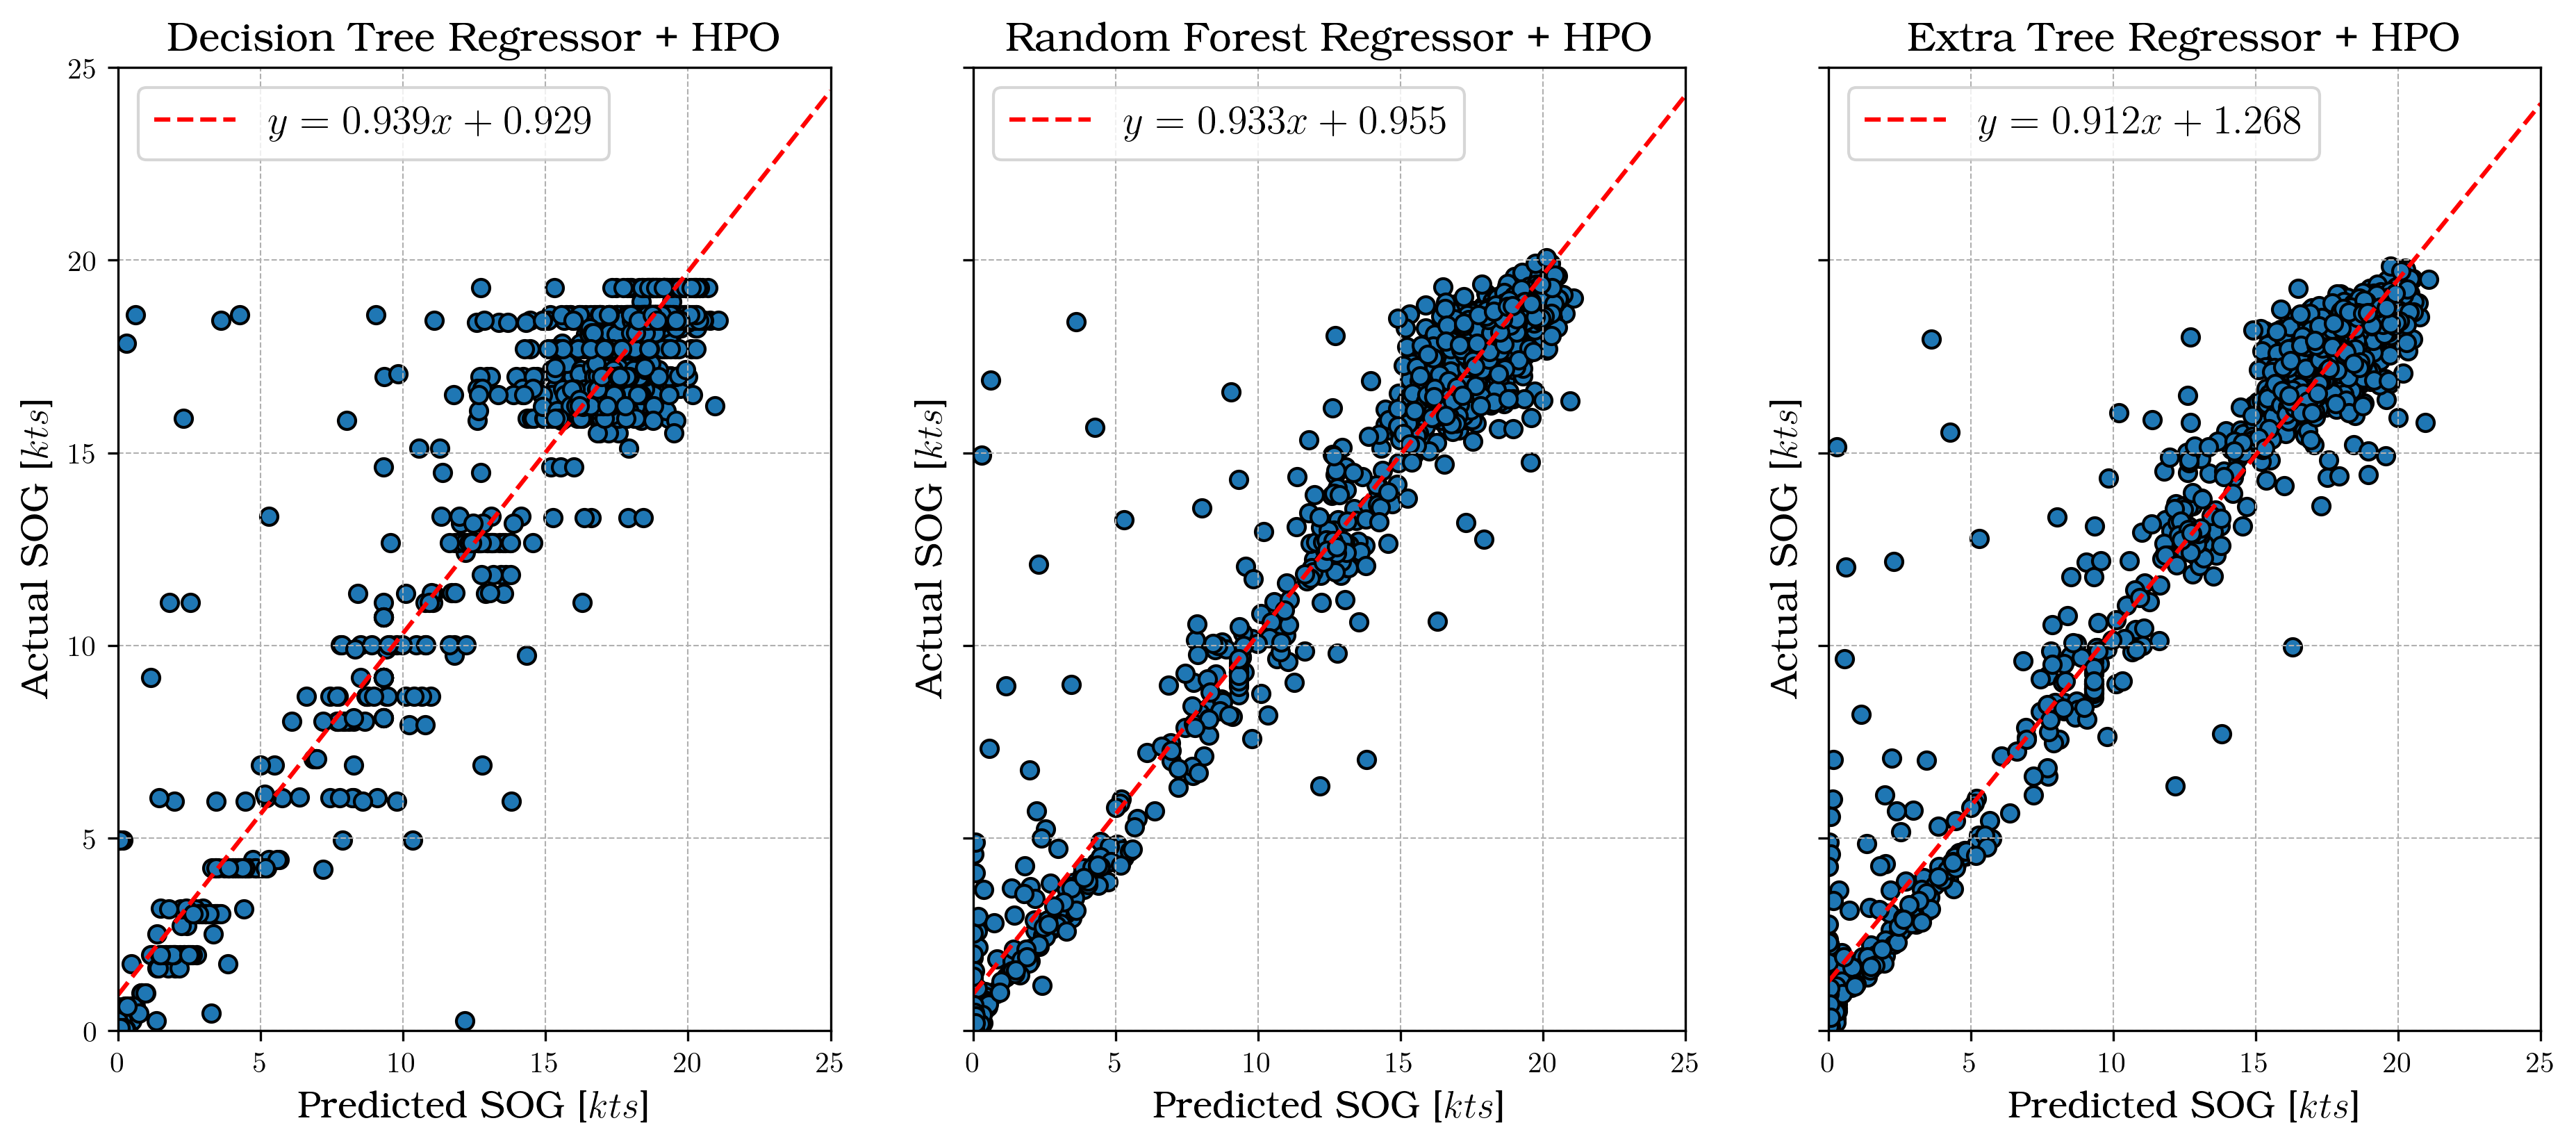

In [202]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
plt.sca(axes[0])
pred_plot(model_dtr_hpov,'Decision Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_rfr_hpov,'Random Forest Regressor + HPO',x_date_yr,y_date_yr)
plt.sca(axes[2])
pred_plot(model_etr_hpov,'Extra Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.show()

0.9113316402515996
y = 1.0 * x + 0.7
0.9287261019749709
y = 0.9 * x + 0.9


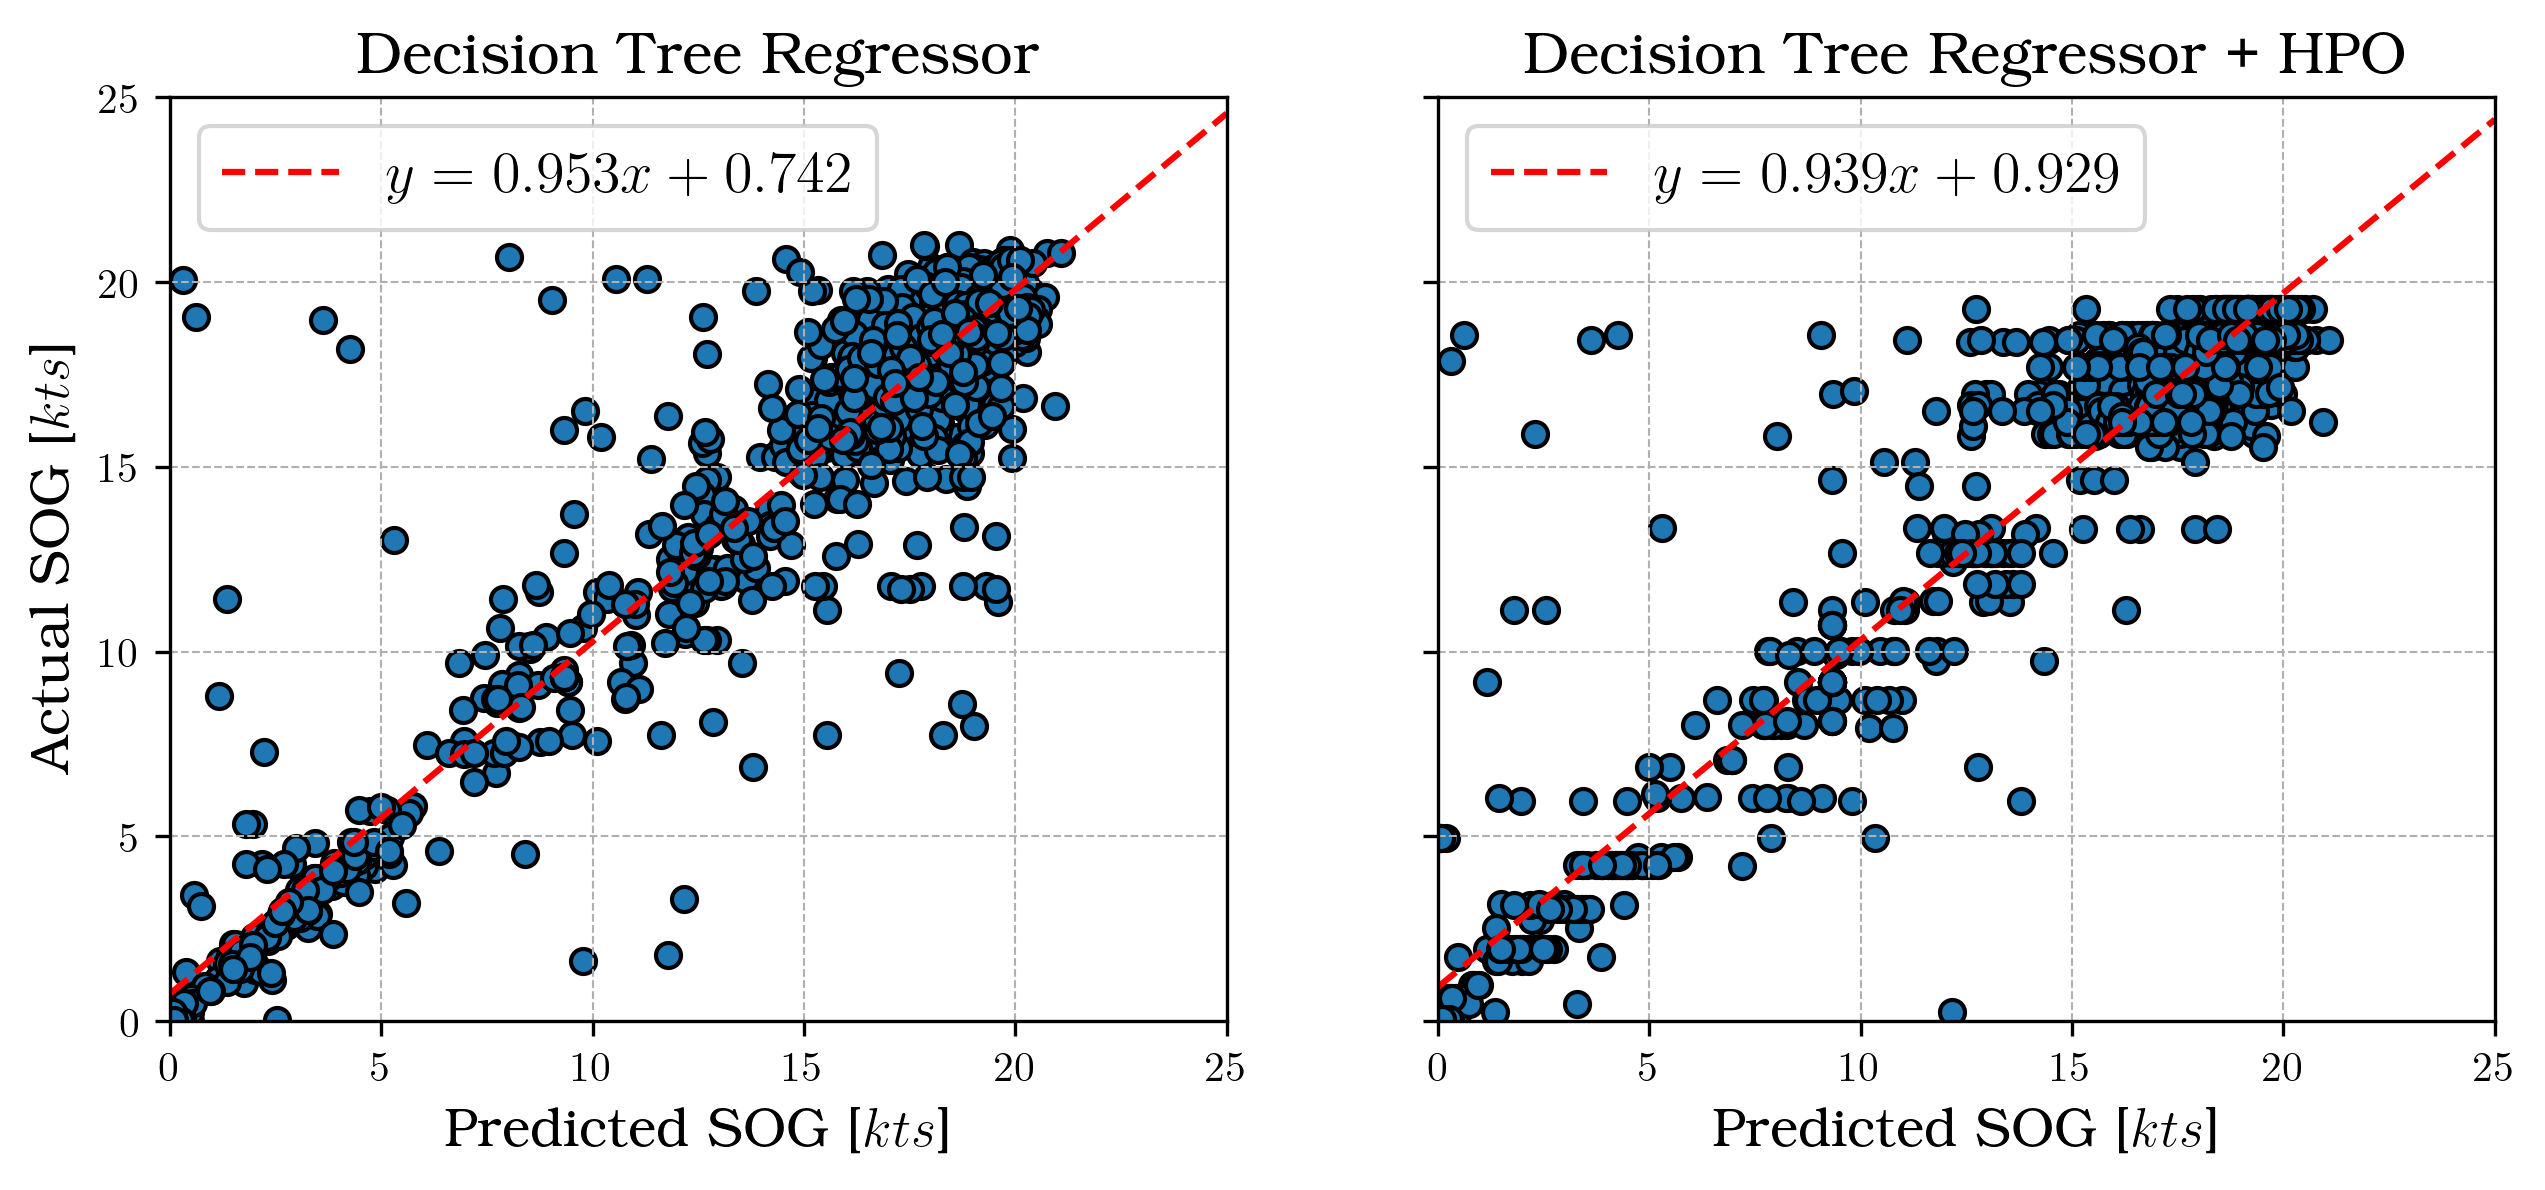

In [203]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_dtr_ftr,'Decision Tree Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_dtr_hpov,'Decision Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

0.9577008968043725
y = 1.0 * x + 0.7
0.9544424732801098
y = 0.9 * x + 1.0


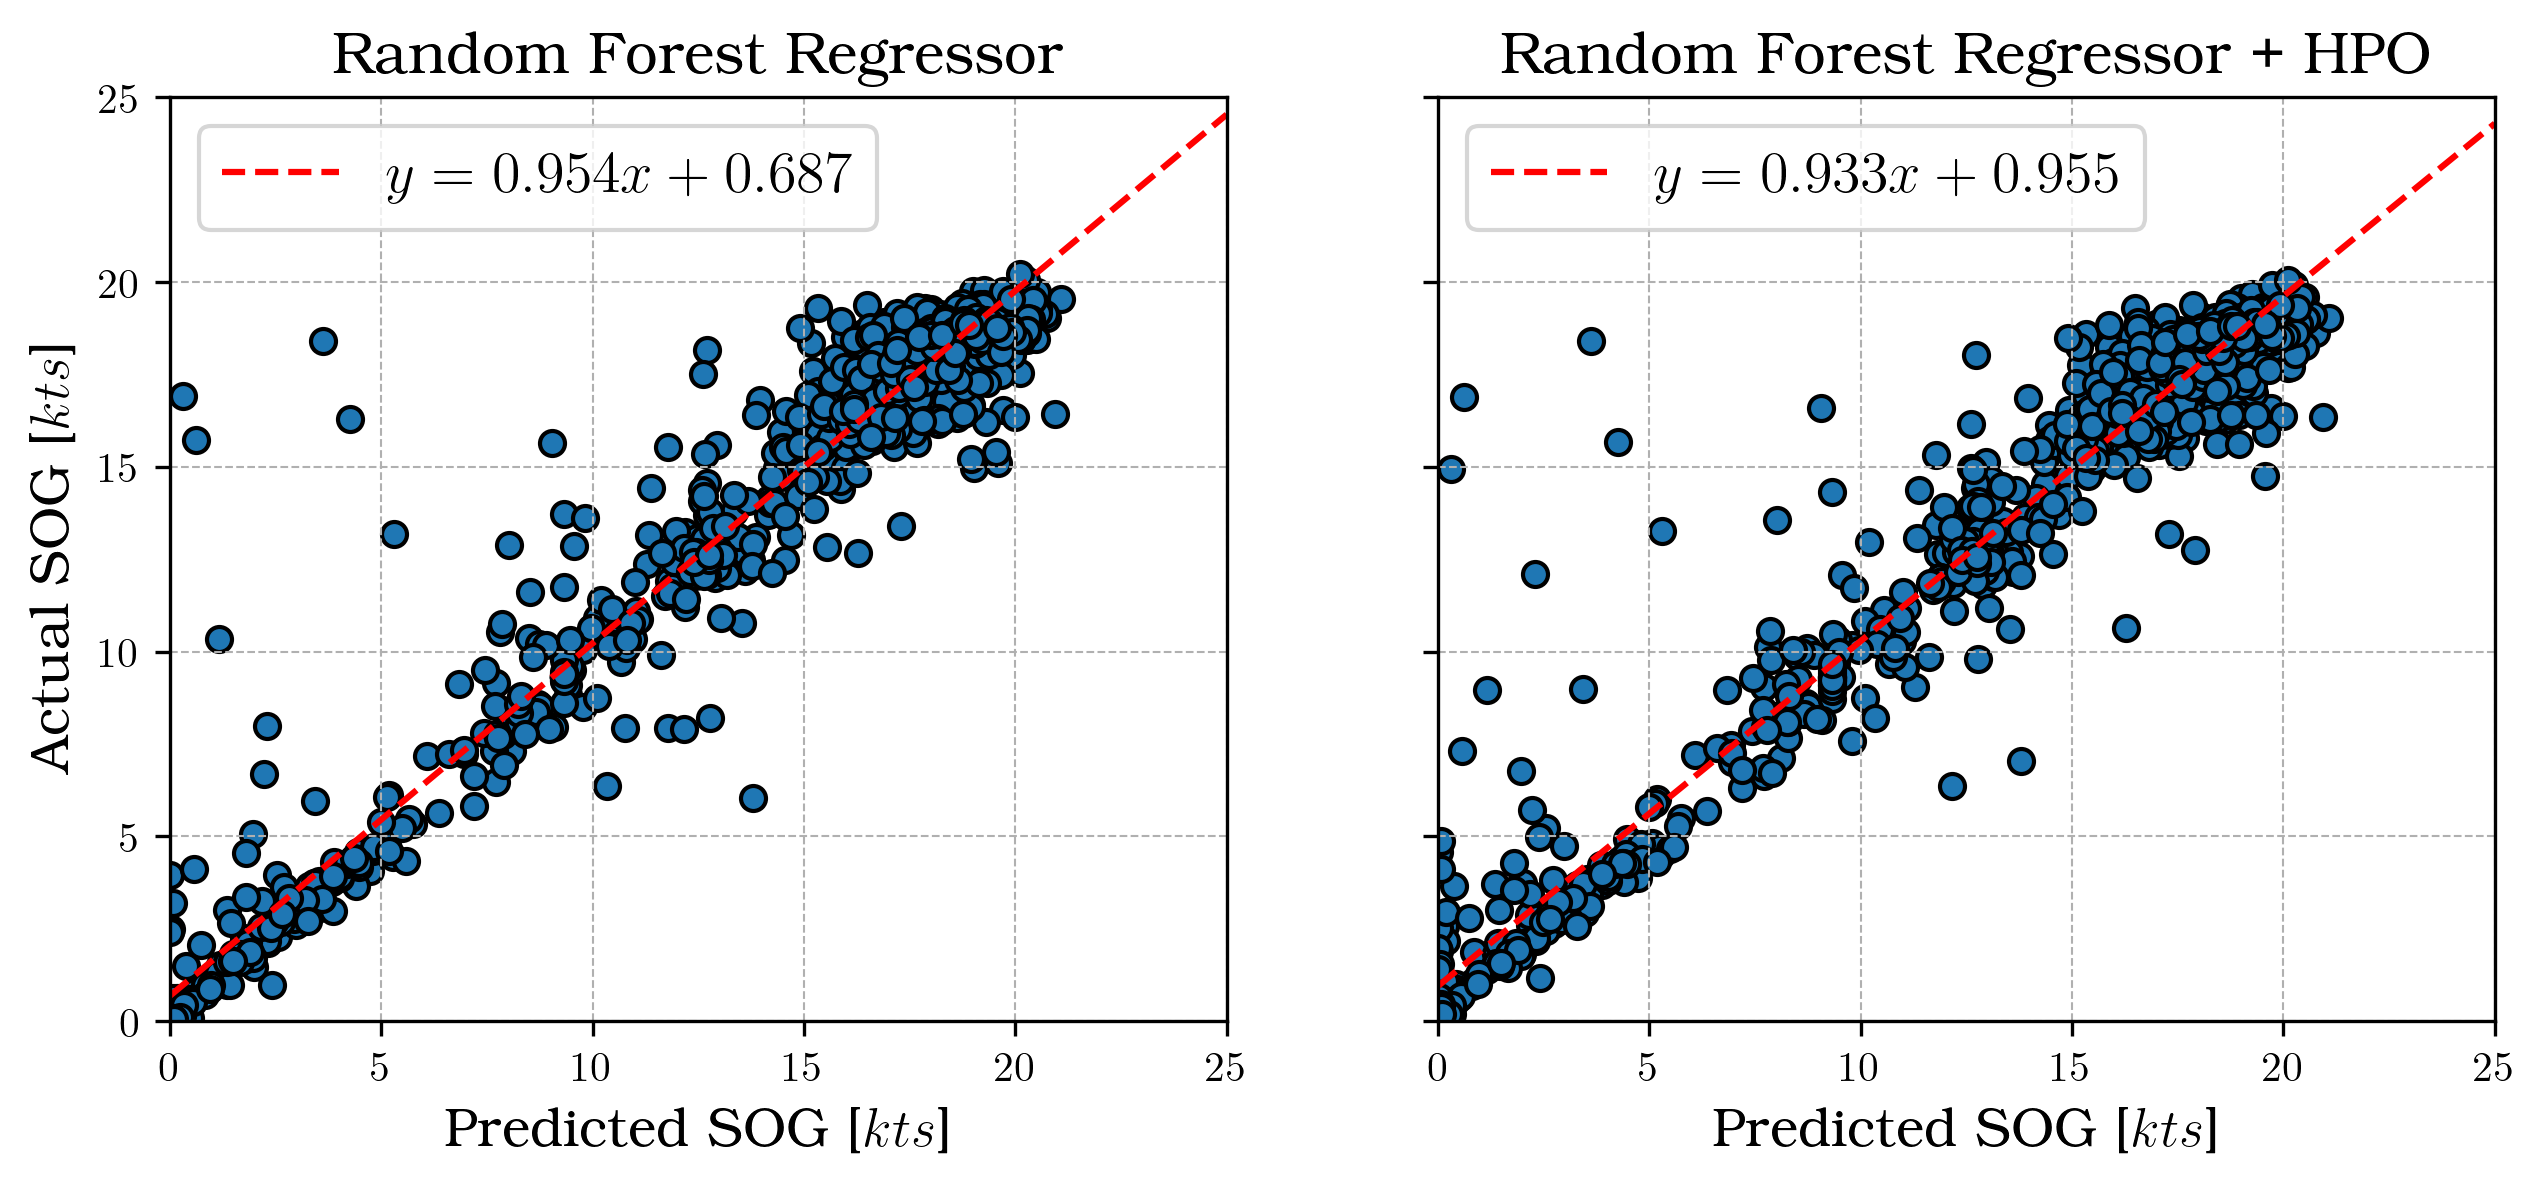

In [204]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_rfr_ftr,'Random Forest Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_rfr_hpov,'Random Forest Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

0.9626392231810569
y = 1.0 * x + 0.7
0.9521561253847236
y = 0.9 * x + 1.3


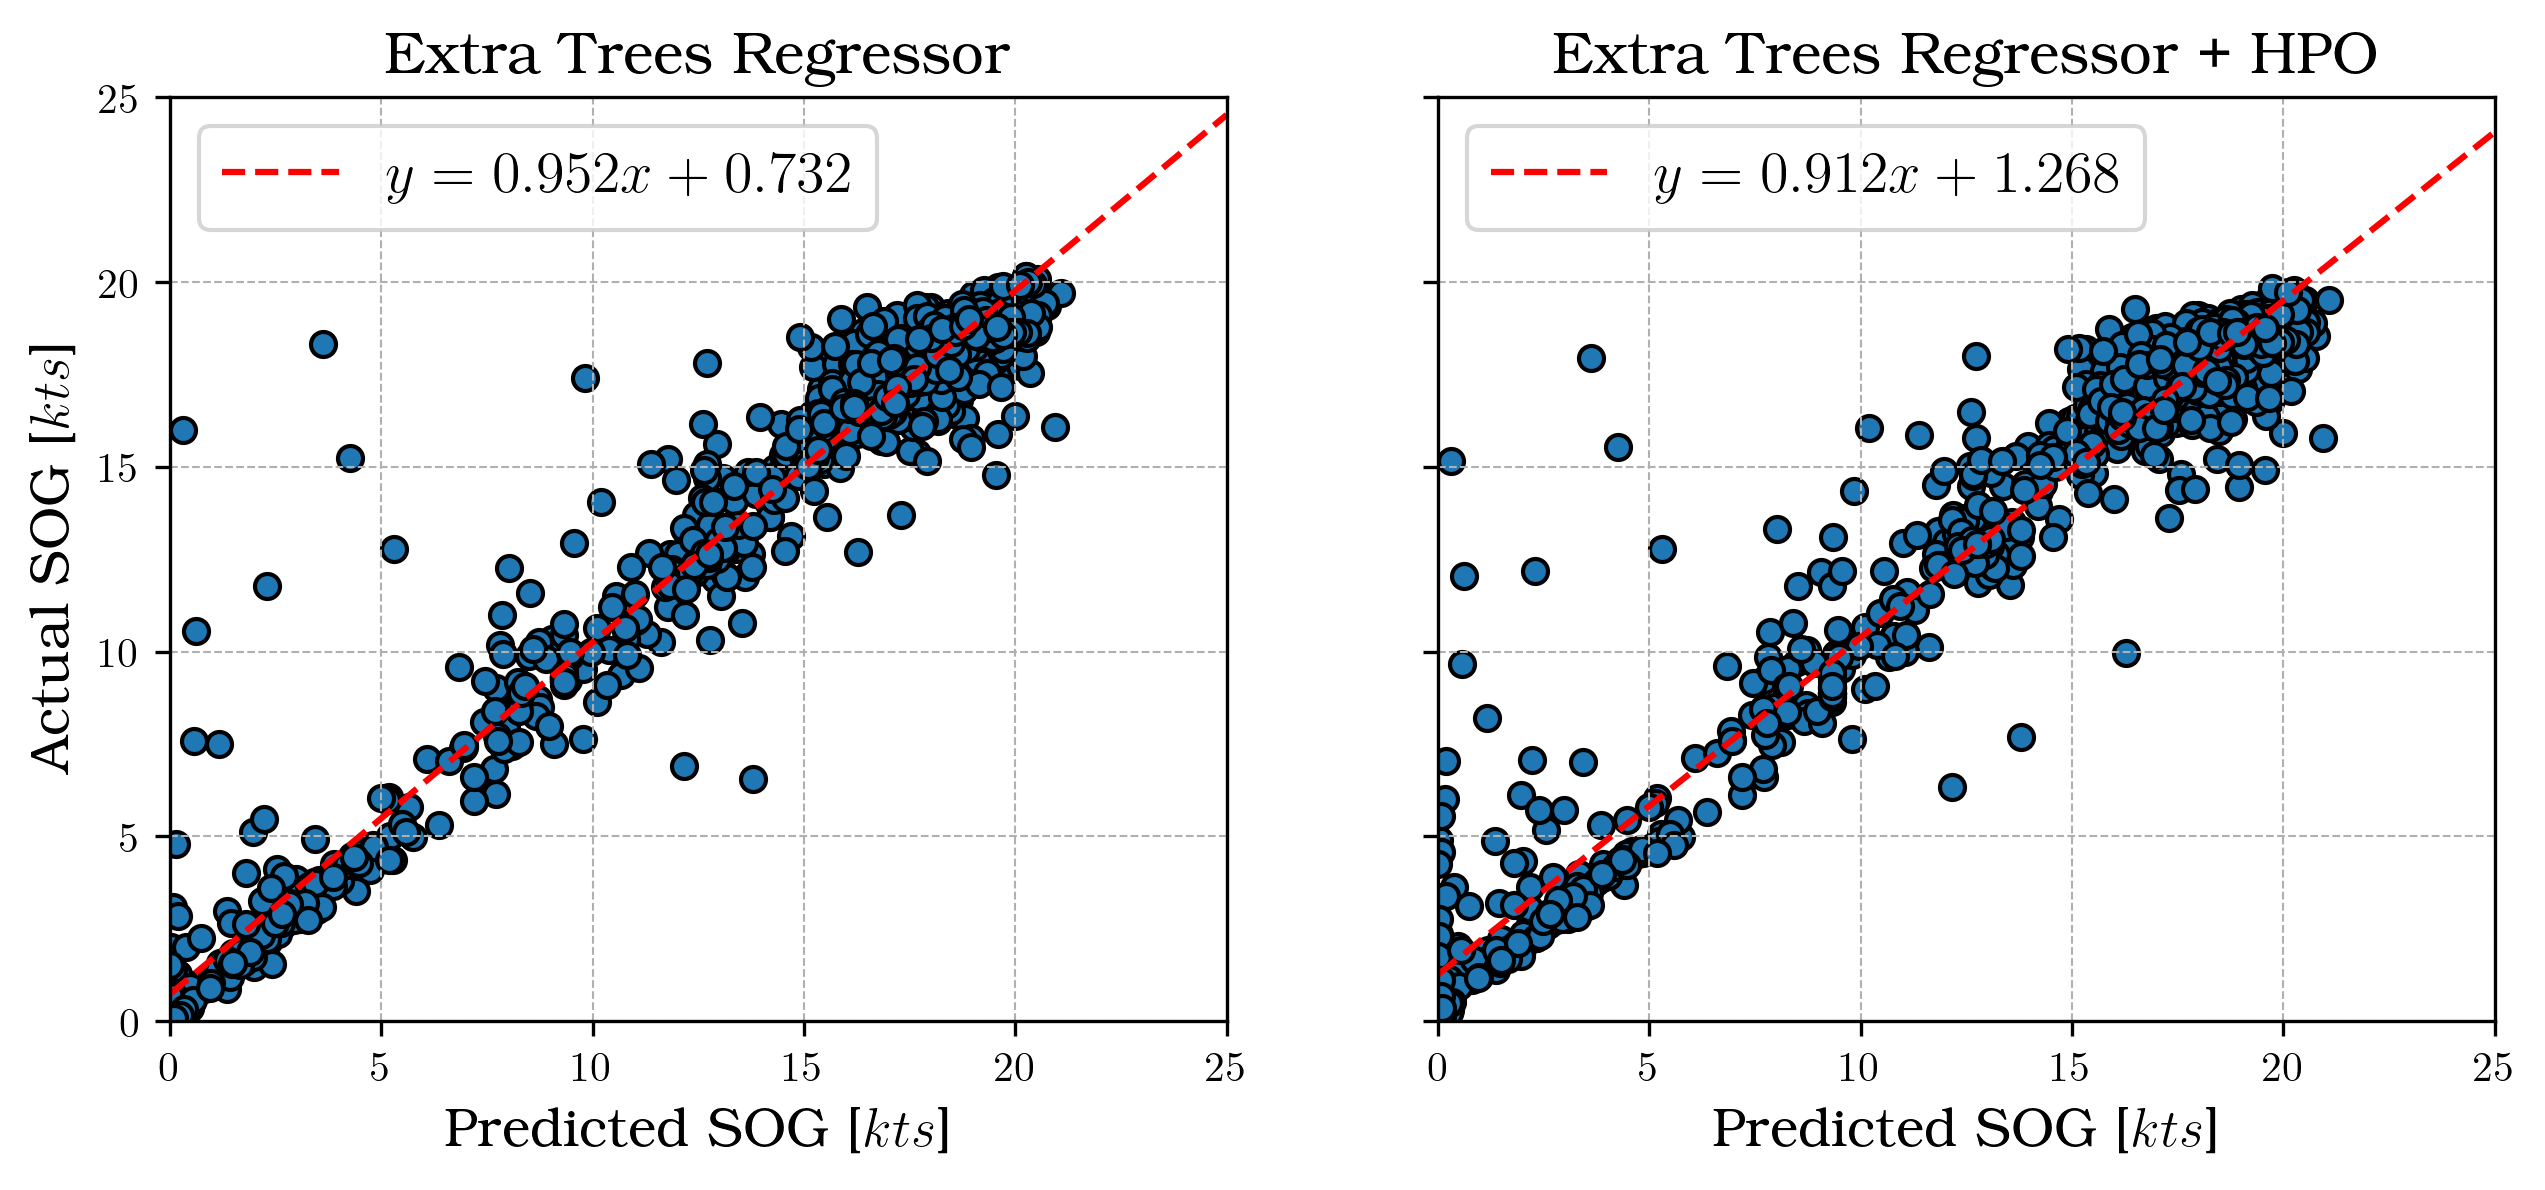

In [205]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_etr,'Extra Trees Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_etr_hpov,'Extra Trees Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

### Conversion to STW 
+ Considered only effect of current per [Kim20b](https://doi.org/10.1016/j.ijnaoe.2020.03.007)

In [206]:
def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

#Test data

# ETR
ydate_pred_s = label_predict(model_etr_hpov,x_date_s)
ydate_pred_w = label_predict(model_etr_hpov,x_date_w)
ydate_pred_yr = label_predict(model_etr_hpov,x_date_yr)

# RFR
ydate_pred_rf_s = label_predict(model_rfr_hpov,x_date_s)
ydate_pred_rf_w = label_predict(model_rfr_hpov,x_date_w)
ydate_pred_rf_yr = label_predict(model_rfr_hpov,x_date_yr)


# DTR
ydate_pred_dt_s = label_predict(model_dtr_hpov,x_date_s)
ydate_pred_dt_w = label_predict(model_dtr_hpov,x_date_w)
ydate_pred_dt_yr = label_predict(model_dtr_hpov,x_date_yr)

# MLR  
ydate_pred_mlr_s = label_predict(model_mlr_ftr,x_date_s)
ydate_pred_mlr_w = label_predict(model_mlr_ftr,x_date_w)
ydate_pred__mlr_yr = label_predict(model_mlr_ftr,x_date_yr)


# For actual results

# Yearly dataset

dfprog_sog_yr = pd.Series(y_date_yr,name="sog_act_yr").to_frame()
ydate_pred_yr = label_predict(model_etr_hpov,x_date_yr)
ydate_pred_rf_yr = label_predict(model_rfr_hpov,x_date_yr)
ydate_pred_dt_yr = label_predict(model_dtr_hpov,x_date_yr)
ydate_pred_mlr_yr = label_predict(model_mlr_ftr,x_date_yr)
dfprog_sog_yr["sog_pred_yr"] = ydate_pred_yr
dfprog_sog_yr["sog_pred_rf_yr"] = ydate_pred_rf_yr
dfprog_sog_yr["sog_pred_dt_yr"] = ydate_pred_dt_yr
dfprog_sog_yr["sog_pred_mlr_yr"] = ydate_pred_mlr_yr
dfprog_sog_yr["gamma_yr"] = dfyear["truenorthcurrentdir"]
dfprog_sog_yr["nwinddir_yr"] = dfyear["truenorthwinddir"]
dfprog_yr = pd.concat([x_date_yr,dfprog_sog_yr],axis=1)


# Winter dataset
dfprog_sog_w = pd.Series(y_date_w,name="sog_act_w").to_frame()
ydate_pred_w = label_predict(model_etr_hpov,x_date_w)
ydate_pred_rf_w = label_predict(model_rfr_hpov,x_date_w)
ydate_pred_dt_w = label_predict(model_dtr_hpov,x_date_w)
ydate_pred_mlr_w = label_predict(model_mlr_ftr,x_date_w)
dfprog_sog_w["sog_pred_w"] = ydate_pred_w
dfprog_sog_w["sog_pred_rf_w"] = ydate_pred_rf_w
dfprog_sog_w["sog_pred_dt_w"] = ydate_pred_dt_w
dfprog_sog_w["sog_pred_mlr_w"] = ydate_pred_mlr_w
dfprog_sog_w["gamma_w"] = dfwinter["truenorthcurrentdir"]
dfprog_sog_w["nwinddir_w"] = dfwinter["truenorthwinddir"]
dfprog_w = pd.concat([x_date_w,dfprog_sog_w],axis=1)

# Summer Dataset
dfprog_sog_s = pd.Series(y_date_s,name="sog_act_s").to_frame()
ydate_pred_s = label_predict(model_etr_hpov,x_date_s)
ydate_pred_rf_s = label_predict(model_rfr_hpov,x_date_s)
ydate_pred_dt_s = label_predict(model_dtr_hpov,x_date_s)
ydate_pred_mlr_s = label_predict(model_mlr_ftr,x_date_s)
dfprog_sog_s["sog_pred_s"] = ydate_pred_s
dfprog_sog_s["sog_pred_rf_s"] = ydate_pred_rf_s
dfprog_sog_s["sog_pred_dt_s"] = ydate_pred_dt_s
dfprog_sog_s["sog_pred_mlr_s"] = ydate_pred_mlr_s
dfprog_sog_s["gamma_s"] = dfsummer["truenorthcurrentdir"]
dfprog_sog_s["nwinddir_s"] = dfsummer["truenorthwinddir"]
dfprog_s = pd.concat([x_date_s,dfprog_sog_s],axis=1)


In [207]:
dfprog_yr.describe()

oceantemperature   waveheight  swellperiod  windwaveperiod  \
count       1430.000000  1430.000000  1430.000000     1430.000000   
mean         282.863393     1.591477     4.236306        3.413332   
std            6.587627     1.104990     1.021596        0.944148   
min          266.114777     0.107192     1.967748        1.570717   
25%          277.200134     0.763643     3.496677        2.728874   
50%          282.897949     1.357673     4.194898        3.385638   
75%          288.996826     2.081702     4.883213        3.864906   
max          297.026611     7.311599     7.517778        7.092444   

        waveperiod     surftemp  windwaveswellheight  swellheight  \
count  1430.000000  1430.000000          1430.000000  1430.000000   
mean      3.800815   283.782673             0.834920     0.383074   
std       0.897324     5.884012             0.565738     0.188954   
min       1.967748   273.048584             0.070604     0.070659   
25%       3.160237   278.317383             0.410441     0.256724   
50%       3.732456   283.468018             0.715718     0.346166   
75%       4.351097   289.384521             1.089224     0.465332   
max       7.085897   295.046387             3.780643     2.209327   

       windwaveheight      draught  ...  truenorthcurrentdir   rho_air_ao  \
count    1.430000e+03  1430.000000  ...          1430.000000  1430.000000   
mean     6.735194e-01     5.176948  ...           160.775851     1.242629   
std      5.919290e-01     0.219256  ...           104.876321     0.033034   
min      2.507146e-16     4.700000  ...             0.143136     1.170450   
25%      2.164307e-01     5.000000  ...            79.032616     1.215066   
50%      5.513306e-01     5.200000  ...           135.704947     1.241320   
75%      9.289763e-01     5.313617  ...           267.784540     1.269084   
max      3.732544e+00     5.700000  ...           359.985910     1.348105   

           p_seasurf   sog_act_yr  sog_pred_yr  sog_pred_rf_yr  \
count    1430.000000  1430.000000  1430.000000     1430.000000   
mean   101338.205726    14.270611    14.280566       14.274801   
std       986.644412     6.407961     5.982205        6.120560   
min     97178.312500     0.000273     0.044722        0.003681   
25%    100724.015625    12.225047    12.878238       12.441375   
50%    101469.562500    17.344856    17.150502       17.305473   
75%    101991.750000    18.590115    18.268161       18.408249   
max    103961.562500    21.070492    19.840236       20.057631   

       sog_pred_dt_yr  sog_pred_mlr_yr     gamma_yr  nwinddir_yr  
count     1430.000000      1430.000000  1430.000000  1430.000000  
mean        14.325428        14.473907   160.775851   195.554871  
std          6.241365         5.199370   104.876321    92.168226  
min          0.011351        -1.268971     0.143136     1.098283  
25%         12.669380        14.238801    79.032616   126.725240  
50%         17.204383        16.366249   135.704947   203.927100  
75%         18.433715        17.021540   267.784540   275.370953  
max         19.280242        32.592701   359.985910   359.479403  

[8 rows x 30 columns]

In [208]:
dfprog_w.describe()

oceantemperature  waveheight  swellperiod  windwaveperiod  waveperiod  \
count        685.000000  685.000000   685.000000      685.000000  685.000000   
mean         277.061812    1.806756     4.523122        3.524018    4.028439   
std            3.281621    1.112459     0.974544        0.966554    0.875717   
min          266.114777    0.176935     2.036522        1.603139    2.011009   
25%          275.052979    0.995592     3.933647        2.833595    3.467309   
50%          277.048340    1.602324     4.471036        3.465004    3.949577   
75%          279.242920    2.348537     5.069295        4.014856    4.490479   
max          286.223145    7.311599     7.517778        7.092444    7.085897   

         surftemp  windwaveswellheight  swellheight  windwaveheight  \
count  685.000000           685.000000   685.000000    6.850000e+02   
mean   278.489150             0.945716     0.425979    7.739062e-01   
std      2.418466             0.572313     0.208531    5.971187e-01   
min    273.048584             0.111497     0.109539    2.536182e-16   
25%    276.691162             0.531084     0.291962    3.247070e-01   
50%    278.137695             0.839958     0.391205    6.852722e-01   
75%    279.446045             1.225909     0.506439    1.069746e+00   
max    284.604492             3.780643     2.209327    3.732544e+00   

          draught  ...  truenorthcurrentdir  rho_air_ao      p_seasurf  \
count  685.000000  ...           685.000000  685.000000     685.000000   
mean     5.159203  ...           164.316259    1.269975  101318.987865   
std      0.212482  ...           103.558230    0.021886    1140.346944   
min      4.700000  ...             0.143136    1.206596   97178.312500   
25%      5.000000  ...            81.427952    1.255830  100526.812500   
50%      5.200000  ...           141.908570    1.270390  101534.125000   
75%      5.300000  ...           270.187606    1.281856  102150.062500   
max      5.700000  ...           359.985910    1.348105  103961.562500   

        sog_act_w  sog_pred_w  sog_pred_rf_w  sog_pred_dt_w  sog_pred_mlr_w  \
count  685.000000  685.000000     685.000000     685.000000      685.000000   
mean    14.251250   14.272515      14.280635      14.359042       14.421513   
std      6.486222    5.988691       6.128452       6.236283        5.302511   
min      0.000275    0.047709       0.003681       0.011351       -0.942139   
25%     12.402381   12.743632      12.459965      12.669380       14.340254   
50%     17.480699   17.298397      17.374968      17.708281       16.312943   
75%     18.564720   18.135618      18.299986      18.433715       16.976184   
max     20.935750   19.180774      19.384049      19.280242       32.592701   

          gamma_w  nwinddir_w  
count  685.000000  685.000000  
mean   164.316259  192.516046  
std    103.558230   96.091780  
min      0.143136    1.465558  
25%     81.427952  115.307630  
50%    141.908570  205.185978  
75%    270.187606  274.862514  
max    359.985910  359.479403  

[8 rows x 30 columns]

In [209]:
dfprog_s.describe()

oceantemperature  waveheight  swellperiod  windwaveperiod  waveperiod  \
count        745.000000  745.000000   745.000000      745.000000  745.000000   
mean         288.197733    1.393645     3.977398        3.311640    3.593909   
std            3.737520    1.061366     0.997774        0.910961    0.867983   
min          278.347168    0.107192     1.967748        1.570717    1.967748   
25%          285.557861    0.614089     3.238856        2.610878    2.930254   
50%          288.854492    1.115817     3.941870        3.242347    3.500018   
75%          290.984131    1.834160     4.629096        3.864895    4.135430   
max          297.026611    5.793899     6.992472        6.188758    6.191917   

         surftemp  windwaveswellheight  swellheight  windwaveheight  \
count  745.000000           745.000000   745.000000    7.450000e+02   
mean   288.580004             0.733038     0.344382    5.809598e-01   
std      3.649571             0.540636     0.159579    5.726135e-01   
min    278.303833             0.070604     0.070659    2.507146e-16   
25%    286.418457             0.334487     0.228644    1.396484e-01   
50%    289.274170             0.592041     0.316433    4.370038e-01   
75%    291.372437             0.957390     0.425670    8.076603e-01   
max    295.046387             2.950672     1.152069    2.884644e+00   

          draught  ...  truenorthcurrentdir  rho_air_ao      p_seasurf  \
count  745.000000  ...           745.000000  745.000000     745.000000   
mean     5.193264  ...           157.520577    1.217833  101355.875839   
std      0.224210  ...           106.038929    0.019523     820.709333   
min      4.700000  ...             0.301881    1.170450   97801.812500   
25%      5.000000  ...            77.832860    1.202922  100862.062500   
50%      5.200000  ...           130.702809    1.215621  101432.437500   
75%      5.400000  ...           257.114638    1.232815  101870.875000   
max      5.700000  ...           358.966173    1.266453  103640.750000   

        sog_act_s  sog_pred_s  sog_pred_rf_s  sog_pred_dt_s  sog_pred_mlr_s  \
count  745.000000  745.000000     745.000000     745.000000      745.000000   
mean    14.288412   14.291321      14.270488      14.295063       14.516797   
std      6.339460    5.972957       6.115127       6.248527        5.099084   
min      0.000273    0.044722       0.005086       0.011351       -1.268971   
25%     12.154439   12.908324      12.439690      12.669380       14.165998   
50%     17.215356   17.014645      17.130963      17.151637       16.438189   
75%     18.634934   18.403870      18.514958      18.433715       17.062407   
max     21.070492   19.840236      20.057631      19.280242       31.200999   

          gamma_s  nwinddir_s  
count  745.000000  745.000000  
mean   157.520577  198.348959  
std    106.038929   88.379865  
min      0.301881    1.098283  
25%     77.832860  138.004438  
50%    130.702809  203.201498  
75%    257.114638  276.660471  
max    358.966173  359.367313  

[8 rows x 30 columns]

In [210]:
# # Ignore for latex export
# print(dfprog_sog_s.describe())
# print(dfprog_sog_s.describe().transpose().to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# ))  

+ Boxplots showcasing the skew of the SOG

<Figure size 1500x900 with 0 Axes>

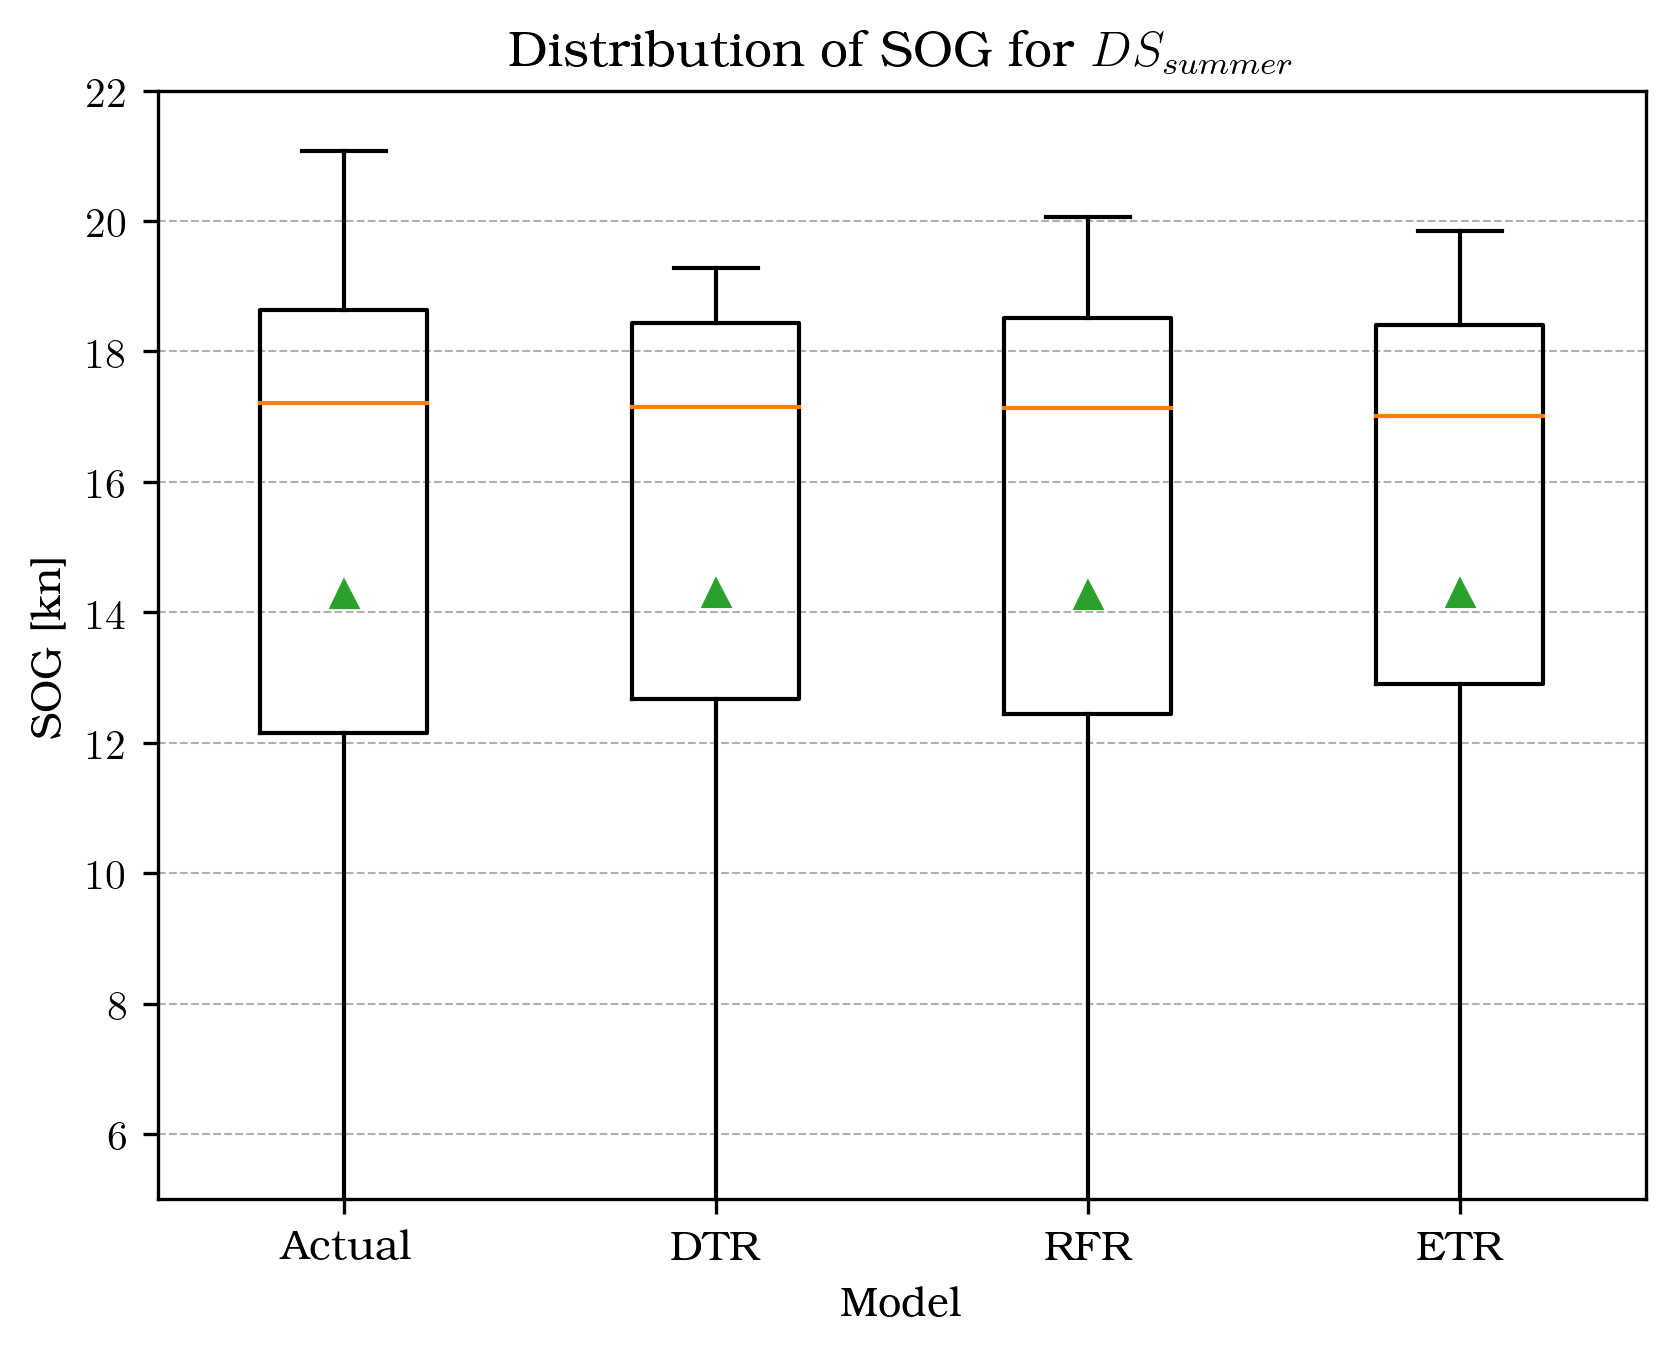

In [211]:
# Box plot of predicted results of winter dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_s['sog_act_s'],dfprog_sog_s['sog_pred_dt_s'],dfprog_sog_s['sog_pred_rf_s'],dfprog_sog_s['sog_pred_s']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{summer}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

In [212]:
# # Ignore for latex export
# print(dfprog_sog_w.describe())
# print(dfprog_sog_w.describe().transpose().to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# )) 

<Figure size 1500x900 with 0 Axes>

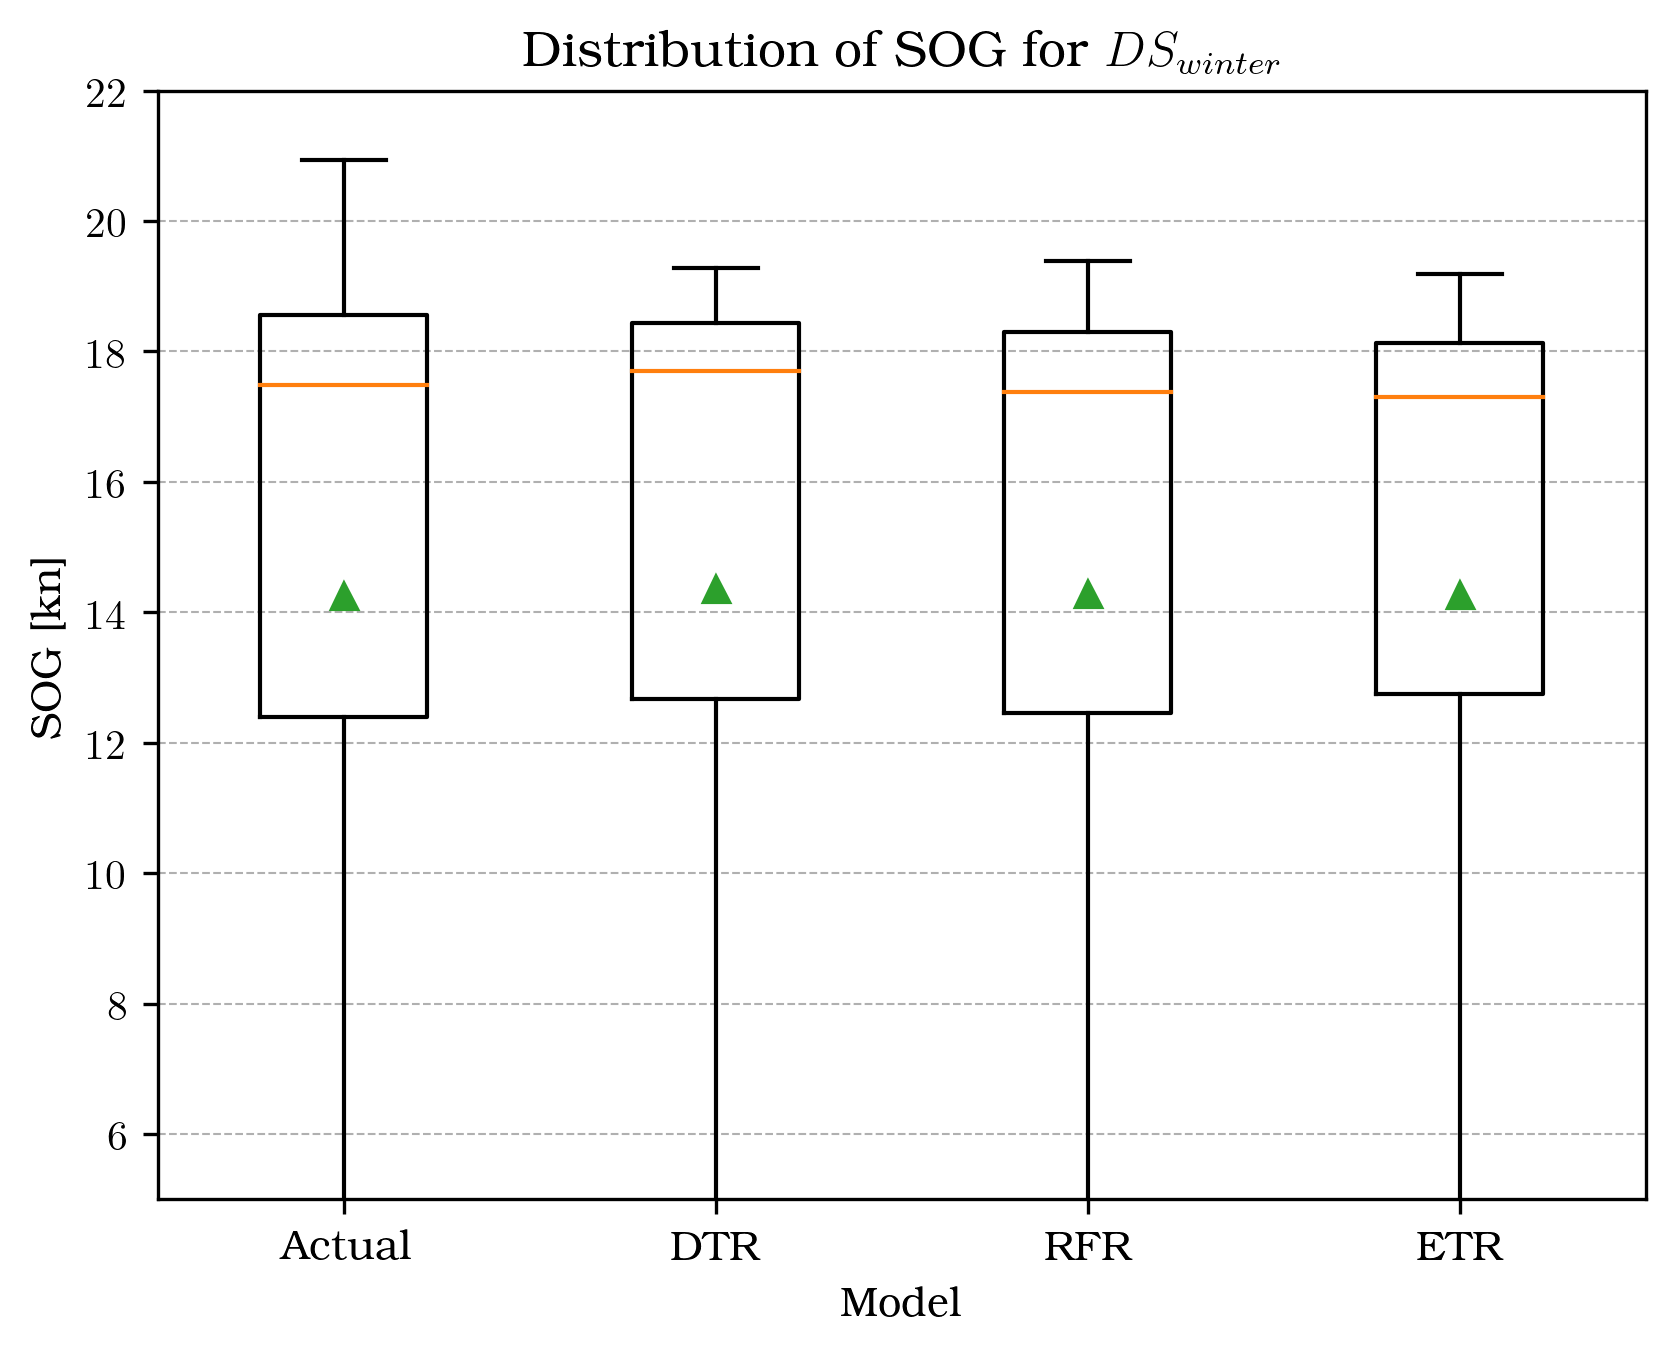

In [213]:
# Box plot of predicted results of winter dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_w['sog_act_w'],dfprog_sog_w['sog_pred_dt_w'],dfprog_sog_w['sog_pred_rf_w'],dfprog_sog_w['sog_pred_w']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{winter}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

In [214]:
# # Ignore for latex export
# print(dfprog_sog_yr.describe())
# print(dfprog_sog_yr.describe().transpose().to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# )) 

<Figure size 1500x900 with 0 Axes>

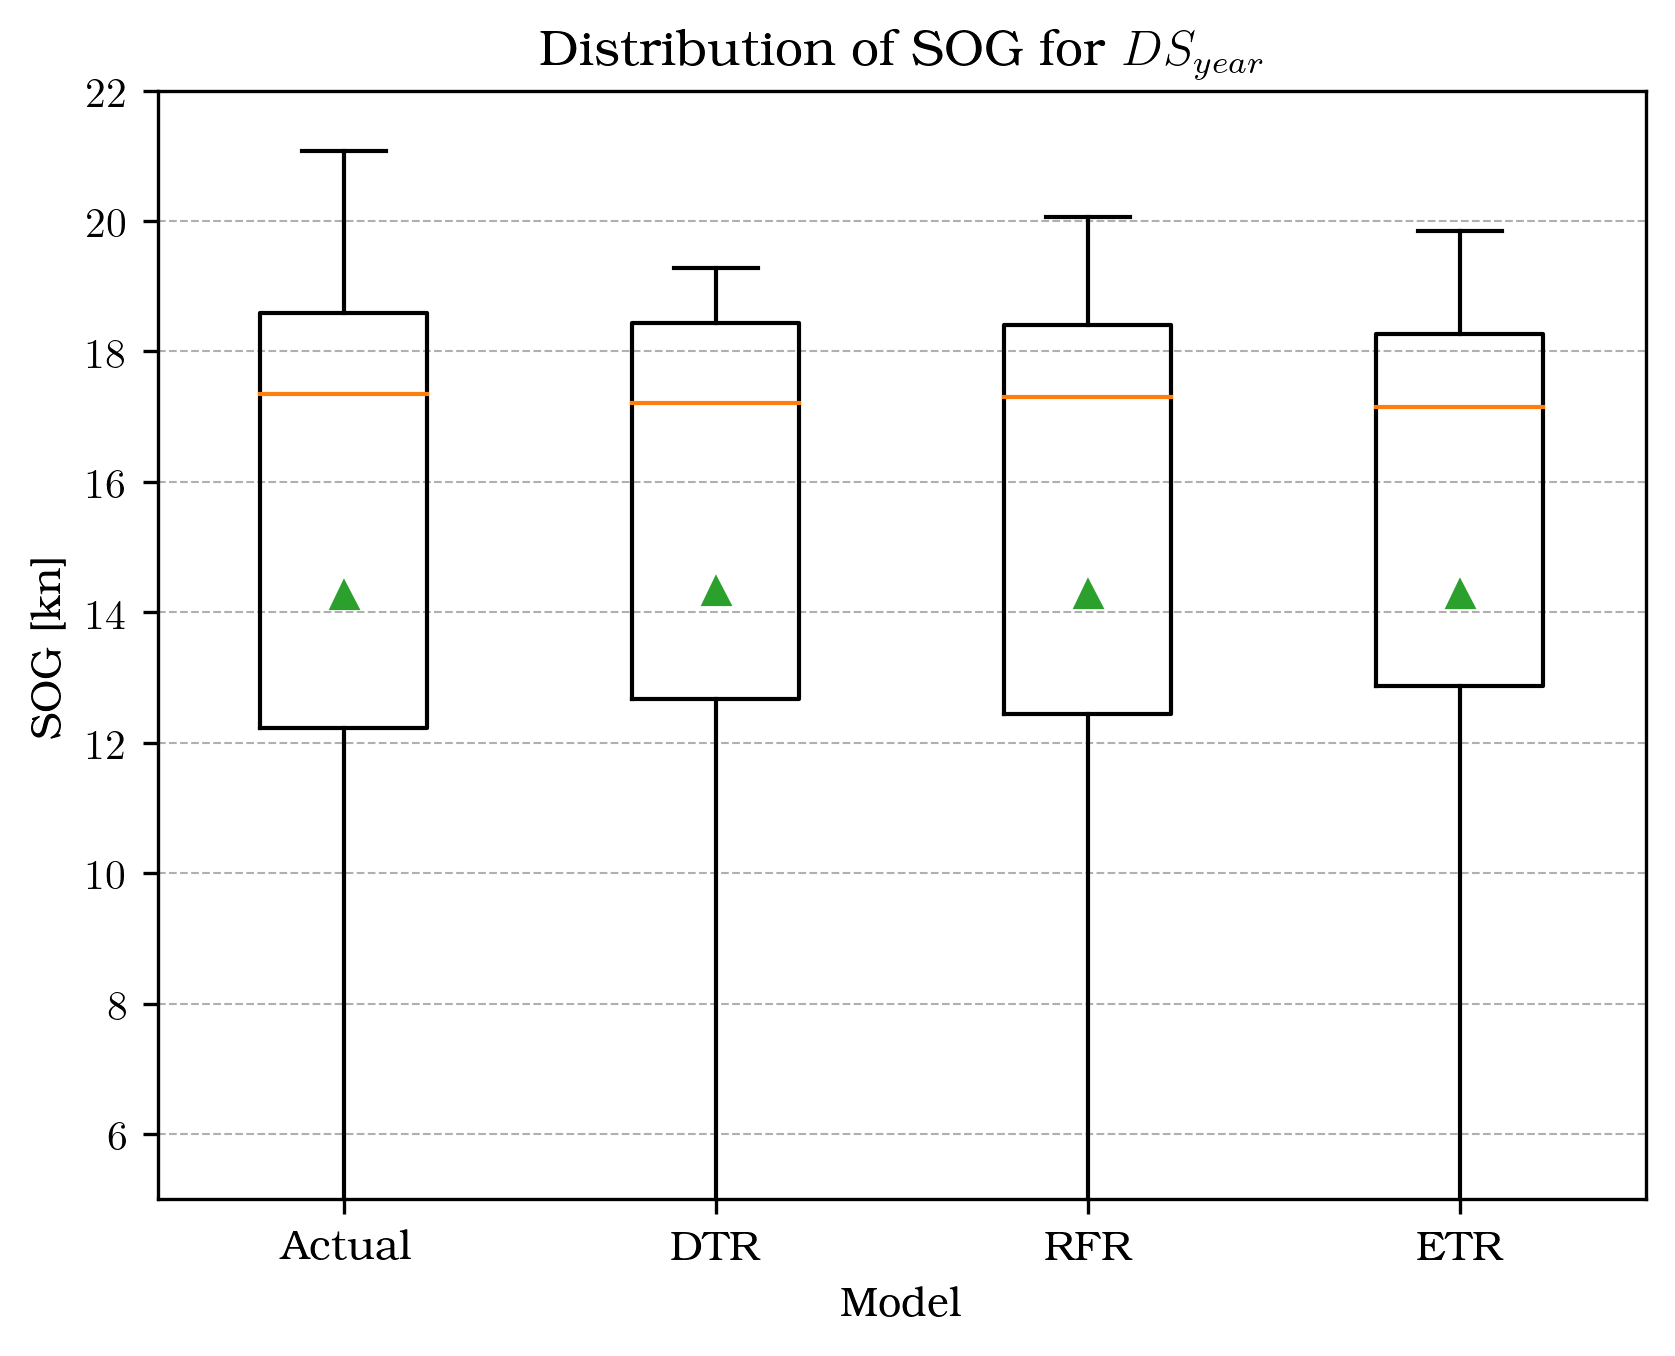

In [215]:
# Box plot of predicted results of yearly dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_yr['sog_act_yr'],dfprog_sog_yr['sog_pred_dt_yr'],dfprog_sog_yr['sog_pred_rf_yr'],dfprog_sog_yr['sog_pred_yr']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{year}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

Formula for STW correction

In [216]:
def sog_corr(sog,gamma,heading,current_speed):
    # Conversion of predicted SOG to m/s
    vgms = sog/1.9438
    rad_gamma = np.deg2rad(gamma)
    rad_cog = np.deg2rad(heading)
    # Calculation of the predicted x-component of SOG

    vgx = vgms * np.sin(rad_cog)
    vcx = current_speed * np.sin(rad_gamma)
    stw_x = vgx - vcx

    # Calculation of the predicted y-component of SOG 

    vgy = vgms * np.cos(rad_cog)
    vcy = current_speed * rad_gamma
    stw_y = vgy - vcy

    vwms_p = np.sqrt(stw_x**2 + stw_y**2)
    stw_pred = vwms_p*1.9438

    return stw_pred

In [217]:
# STW conversion Year

# Actual
stw_act_yr = sog_corr(dfprog_yr['sog_act_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_act_yr'] = stw_act_yr
# ETR
stw_pred_et_yr = sog_corr(dfprog_yr['sog_pred_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_yr'] = stw_pred_et_yr
# RFR
stw_pred_rf_yr = sog_corr(dfprog_yr['sog_pred_rf_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_rf_yr'] = stw_pred_rf_yr
# DTR
stw_pred_dt_yr = sog_corr(dfprog_yr['sog_pred_dt_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_dt_yr'] = stw_pred_dt_yr
# MLR
stw_pred_mlr_yr = sog_corr(dfprog_yr['sog_pred_mlr_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_mlr_yr'] = stw_pred_mlr_yr



In [218]:
print(dfprog_yr.describe())

       oceantemperature   waveheight  swellperiod  windwaveperiod  \
count       1430.000000  1430.000000  1430.000000     1430.000000   
mean         282.863393     1.591477     4.236306        3.413332   
std            6.587627     1.104990     1.021596        0.944148   
min          266.114777     0.107192     1.967748        1.570717   
25%          277.200134     0.763643     3.496677        2.728874   
50%          282.897949     1.357673     4.194898        3.385638   
75%          288.996826     2.081702     4.883213        3.864906   
max          297.026611     7.311599     7.517778        7.092444   

        waveperiod     surftemp  windwaveswellheight  swellheight  \
count  1430.000000  1430.000000          1430.000000  1430.000000   
mean      3.800815   283.782673             0.834920     0.383074   
std       0.897324     5.884012             0.565738     0.188954   
min       1.967748   273.048584             0.070604     0.070659   
25%       3.160237   278.317383  

In [219]:
# STW conversion Summer 

# Actual
stw_act_s = sog_corr(dfprog_s['sog_act_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_act_s'] = stw_act_s
# ETR
stw_pred_et_s = sog_corr(dfprog_s['sog_pred_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_s'] = stw_pred_et_s
# RFR
stw_pred_rf_s = sog_corr(dfprog_s['sog_pred_rf_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_rf_s'] = stw_pred_rf_s
# DTR
stw_pred_dt_s = sog_corr(dfprog_s['sog_pred_dt_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_dt_s'] = stw_pred_dt_s
# MLR
stw_pred_mlr_s = sog_corr(dfprog_s['sog_pred_mlr_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_mlr_s'] = stw_pred_mlr_s



In [220]:
print(dfprog_s.describe())

       oceantemperature  waveheight  swellperiod  windwaveperiod  waveperiod  \
count        745.000000  745.000000   745.000000      745.000000  745.000000   
mean         288.197733    1.393645     3.977398        3.311640    3.593909   
std            3.737520    1.061366     0.997774        0.910961    0.867983   
min          278.347168    0.107192     1.967748        1.570717    1.967748   
25%          285.557861    0.614089     3.238856        2.610878    2.930254   
50%          288.854492    1.115817     3.941870        3.242347    3.500018   
75%          290.984131    1.834160     4.629096        3.864895    4.135430   
max          297.026611    5.793899     6.992472        6.188758    6.191917   

         surftemp  windwaveswellheight  swellheight  windwaveheight  \
count  745.000000           745.000000   745.000000    7.450000e+02   
mean   288.580004             0.733038     0.344382    5.809598e-01   
std      3.649571             0.540636     0.159579    5.726135e-0

In [221]:
# STW conversion Winter

# Actual
stw_act_w = sog_corr(dfprog_w['sog_act_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_act_w'] = stw_act_w
# ETR
stw_pred_et_w = sog_corr(dfprog_w['sog_pred_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_w'] = stw_pred_et_w
# RFR
stw_pred_rf_w = sog_corr(dfprog_w['sog_pred_rf_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_rf_w'] = stw_pred_rf_w
# DTR
stw_pred_dt_w = sog_corr(dfprog_w['sog_pred_dt_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_dt_w'] = stw_pred_dt_w
# MLR
stw_pred_mlr_w = sog_corr(dfprog_w['sog_pred_mlr_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_mlr_w'] = stw_pred_mlr_w

Holtrop Mennen FOC function

In [222]:
def foc_fun(stw,T_dyn,windspeed,truewindir,H_s,truewavedir):
    # Ship Information, that are readily available in ship specification
    loa = 158 # ship overall length
    lwl = 144.8 # ship waterline length, m
    lpp = 0.97*lwl # ship perpendicular length , m, according to information
    B = 24.5 # Ship breadth, m
    depth = 13.8 # Ship depth. m
    T_n = 5.85 # Nominal max draught , m
    # T_n = 5.7 # Nominal design draught , m
    dwt = 5110 # ship dead weight , t
    V_n = 17.7 # ship design speed, knots
    # V_n = 18 # ship design speed, knots


    # Environmental Constants

    g = 9.805 # gravity, kg/ms^2 
    rho_sea = 1025 # kg/m3
    nu_sea = 0.00000118 # Dynamic viscosity of sea m^2/s
    rho_air = 1.25 # density air 

    # Any other additional ship parameters beyond here are approximated based on literature review.

    # Convert STW to m/s, stw with only current correction

    stw_ms = stw / 1.94384

    # Switch between actual and predicted here 
    # Calculation for Block coefficient,C_b, according to Schneekluth and Bertram 1998
    # Then Froude number is required

    V_n = 17.7/1.94384
    # V_n = 18/1.94384

    Fr_n = V_n / math.sqrt(g*lwl)
    # print(f"Froude Number {Fr_n:0.4f}")

    C_b = -4.22 + 27.8*math.sqrt(Fr_n) - 39.1*Fr_n + 46.6*(Fr_n)**3
    # print(f"C_b {C_b:0.4f}")

    # calculation for midship section coefficient, C_m according to Jensen from Birk

    C_m = 1 / (1+(1-C_b)**3.5)
    # print(f"C_m {C_m:0.4f}")

    # prismatic coefficient C_p can be calculated according to Biran

    C_p = C_b/C_m 
    # print(f"C_p {C_p:0.4f}")

    # Displacement calculation according to Barras 

    dsp = C_b * lwl * B * T_n

    # print(f"dsp {dsp:0.4f} m^3")

    # coefficient c14 to account for stern shape according to holtrop mennen

    C_stern = 10 # assume u shaped stern
    c14 = 1 + 0.011*C_stern 
    
    # print(f"c14 {c14:0.4f}")

    # Calculate length of run according to holtrop mennen

    # lcb = -2/100 # according to Barras
    lcb = -(0.44*Fr_n - 0.094) # according to Guldhammer and Harvald

    # print(f"lcb {lcb:0.4f}")

    # L in holtrop mennen is lwl

    lr = lwl*(1-C_p+(0.06*C_p*lcb/(4*C_p-1)))

    # print(f"lr {lr:0.4f} m")

    # now the (1+k1) can be calculated

    k1a = 0.487118*c14*(B/lwl)**1.06806
    k1b = (T_dyn/lwl)**0.46106
    k1c = (lwl/lr)**0.121563
    k1d = (lwl**3/dsp)**0.36486
    k1e = (1-C_p)**-0.604247

    k1_const = 0.93 + k1a*k1b*k1c*k1d*k1e

    # print(f"k1_const {k1_const.mean():0.4f}")

    # Calculate Reynold number and Coefficient of Friction C_f. Here, the C_f will be dynamic and depend on the velocity of the ship

    Re =( stw_ms * lwl ) / nu_sea
    C_f = 0.075 / (np.log10(Re-2)**2)

    # print(f"Mean Reynold Number {Re.mean():0.2f}")
    # print(f"Mean Coefficient of friction {C_f.mean():0.6f}")
    
    # Calculate the appendage area of bare hull S_bh
    # Formula according to Holtrop Mennen

    # Calculate the waterplane area coefficient 
    # Formula according to Schneekluth and Bertram

    C_wp = (1+2*C_b)/3
    # print(f"C_wp {C_wp:0.4f}")

    # Calculate transverse bulb area A_bt, Transom area A_t and immersed midship section area A_m according to Kim 2019

    # dfprog['A_m'] = B*dfprog['draught']*C_m
    # Borrow estimation of Am from Guldahmmer and Harvald
    A_m = dsp/(lpp*C_p)
    A_t = 0.051 * A_m
    A_bt = 0.085*A_m # From approximation of Kracht78, Similar to Charcalis
    # print(f"A_m {A_m:0.2f} m^2")
    # print(f"A_t {A_t:0.4f} m^2")
    # print(f"A_bt {A_bt:0.4f} m^2")

    sbh_a = lwl*(2*T_dyn+B)*math.sqrt(C_m)
    sbh_b = 0.453
    sbh_c = 0.4425*C_b
    sbh_d = 0.2862*C_m
    sbh_e = 0.003467*(B/T_dyn)
    sbh_f = 0.3696*C_wp
    sbh_g = 2.38*A_bt/C_b

    S_bh = sbh_a*(sbh_b+sbh_c-sbh_d+sbh_e+sbh_f)+sbh_g

    # print(f"S_bh {S_bh.mean():0.4f} m^2")

    # Calculate R_f

    R_f = 0.5 * rho_sea * stw_ms**2 * C_f * S_bh * k1_const

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Frictional Resistance {R_f.mean():0.2f} N")
    
    # Calculate resistance due to appendage

    # Assume S_app
    # Taken from Holtrop Mennen worked example
    # S_app = 50 # m^2 

    # Calculation of appendage area according to Hollenbach method, the formula is for twin screw ship

    # Lower limit
    S_app_lo = S_bh.mean()*(0.028+0.01*math.exp(-(lpp*T_n)/1000))

    # Upper limit
    S_app_hi = S_bh.mean()*(0.0325+0.045*math.exp(-(lpp*T_n)/1000))

    # print(f"S_app between {S_app_lo:.02f} and {S_app_hi:.02f} according to Hollenbach")

    # The following appendage area are scaled from the picture of the ship
    # Constant k here means (1+k_2) !

    D_shaft = 0.55 # m, approx
    l_shaft = 13.54 # m, approx

    S_app_shaft = 2*math.pi * D_shaft * l_shaft
    k2_shaft = 3   

    h_rudder = 4.06 #m, approx
    B_rudder = 1.99 #m, approx
    S_app_rudder = 2 * h_rudder * B_rudder #m, two side
    k2_rudder = 3

    h_skeg = 4.41 #m, approx
    l_skeg = 26.23 #m, approx
    S_app_skeg =  h_skeg * l_skeg #two side (triangle)
    k2_skeg = 1.5

    S_app = S_app_shaft + S_app_rudder + S_app_skeg

    k2_const = (k2_shaft*S_app_shaft + k2_rudder*S_app_rudder + k2_skeg*S_app_skeg)/S_app

    # print(f"Wetted area of hull is {S_bh.mean():0.2f}")
    # print(f"(1+k2) equivalent {k2_const:0.2f}")
    # print(f"Total Appendage area is {S_app:0.4f}")
    # # from holtrop mennen, take case of twin screw
    # k2_const = 2.8

    # Add resistance due to Bow Thrusters

    d_th = 2.15 #m, approx

    # Use formula from Hollenach
    C_dth = 0.003 + 0.003*((10*d_th/T_n)-1)
    # C_dth = 0.003 # The picture shows that the thruster are fairly parallel to midship area
    # There are two bow thruster in this ship
    R_th = rho_sea*stw_ms**2*math.pi*d_th**2*C_dth

    # print(f"Friction due to bow thrusters {R_th.mean():0.2f} N")

    R_app = (0.5 * rho_sea * stw_ms**2 * C_f * S_app *k2_const) + 2*R_th

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Appendage Friction {R_app.mean():0.2f} N")

    # Calculate wave-making and wave-breaking resistance

    # print("Ratio check to ensure correct formula is used for Holtrop Mennen")
    # print(f"B/lwl = {B/lwl:0.2f}")
    # print(f"lwl^3/displacemt = {lwl**3/dsp:0.2f}")
    # print(f"C_p = {C_p:0.4f}")


    c7 = B/lwl
    T_fwd = T_dyn # See reasoning from Rakke16 
    h_b = 0.6*T_n # must not exceed 0.6 T_f, here T_n = T_f (design), reasong and coefficient value taken from Rakke
    
    # print(f"h_B {h_b:0.4f}")

    # All formulas here are listed by Holtrop Mennen

    c3 = 0.56 * A_bt**1.5 / (B*T_dyn*(0.31*np.sqrt(A_bt)+T_fwd-h_b))
    c2 = np.exp(-1.89*np.sqrt(c3))
    c5 = 1 - 0.8*(A_t/(B*T_dyn*C_m))
    lambda_const = (1.446 * C_p) - 0.03*(lwl/B)
    c16 = 8.07981*C_p - 13.8673*C_p**2 + 6.984388*C_p**3
    m_1 = 0.0140407 * (lwl/T_dyn) - 1.75254*(dsp**(1/3)/lwl) -  4.79323*(B/lwl) - c16
    c15 = -1.69385

    # Use dynamic Froude here to refect the actual resistance due to ship movement 

    Fr_n_dyn = stw_ms / math.sqrt(g*lwl)
    # Updated formula use m_4
    m4 = 0.4 * c15 * np.exp(-0.034*Fr_n_dyn **-3.29)

    i_e = 1 + 89*math.exp(-(lwl/B)**0.80856*(1-C_wp)**0.30484*(1-C_p-0.0225*lcb)**0.6367*(lr/B)**0.34574*((100*dsp)/lwl**3)**0.16302)
    c1 = 2223105 * c7**3.78613 * (T_dyn/B)**1.07961*(90-i_e)**-1.37565
    d = -0.9

    # print(f"i_e = {i_e:0.4f}")

    # Use updated formula with m4

    R_w = c1*c2*c5*dsp*g*rho_sea*np.exp(m_1*Fr_n_dyn **d+m4*np.cos(lambda_const*Fr_n_dyn **-2))

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Wave resistance {R_w.mean():0.2f} N")

    # Calculate Resistance due to Bulbous Bow
    # Calculate effect of forward sinkage h_f and local wave height at bow h_w

    P_b = 0.56*np.sqrt(A_bt)/(T_fwd-1.5*h_b)
    Fn_i = stw_ms / np.sqrt(g*(T_fwd-h_b-0.25*np.sqrt(A_bt))+0.15*stw_ms**2)
    R_b = 0.11 * np.exp(-3*P_b**-2)*Fn_i**3*A_bt**1.5*rho_sea*g/(1+Fn_i**2)

    # print(f"Emergence of bulb Pb {P_b.mean():0.4f}")
    # print(f"Immersion Froude number Fn_i {Fn_i.mean():0.2f}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Resistance due to bulbous bow {R_b.mean():0.2f} N")    

    #Calculate Transom Resistance 

    Fn_tr = stw_ms / np.sqrt(2*g*A_t/(B+(B*C_wp)))

    # print(f"Froude for Transom {Fn_tr.mean():0.4f}")

    # Use condition to calculate Froude due to transom

    cond_Fn_tr = [Fn_tr < 5 ]
    cond_c6 = [0.2*(1-0.2*Fn_tr)]

    c6 = np.select(cond_Fn_tr,cond_c6,0)
    R_tr = 0.5*rho_sea*10**2*A_t*c6

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Resistance due to transom {R_tr.mean():0.2f} N")

    # Model ship correlation resistance

    # print("Ratio check to ensure correct formula is used for Holtrop Mennen")

    cond_Tf_lwl = [(T_fwd/lwl) <= 0.04 ]
    cond_c4 = [T_fwd/lwl]
    c4 = np.select(cond_Tf_lwl,cond_c4,0.04)

    C_a = 0.00546*(lwl+100)**-0.16 - 0.002 + 0.003*math.sqrt(lwl/7.5)*C_b**4*c2*(0.04-c4)

    R_a = 0.5*rho_sea*stw_ms**2*C_a*(S_bh+S_app)

    # print(f"C_a {C_a.mean()}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Correlation allowance resistance {R_a.mean():0.2f} N")

    # Calculate Additional Resistance, consist of wind resistance and wave resistance
    # Calculate Apparent velocities and Apparent Angle 

    V_aw = np.sqrt(windspeed**2 + stw_ms**2 + 2*windspeed*stw_ms*np.cos(np.deg2rad(truewindir)))

    awa_c1 = (windspeed/V_aw)*np.sin(np.deg2rad(truewindir))

    # Epsilon is Apparent Wind Angle AWA

    epsilon = np.rad2deg(np.arcsin(awa_c1))

    # Values and method from Blendermann

    C_DlAf = 0.45
    A_f = 325.3
    A_l = 2125.8
    C_Dt = 0.9
    delta = 0.8
    C_Dl = C_DlAf * A_f / A_l
    L_bwl = 43.75 # m, acquired from picture

    Raa_const1 = (rho_air/2) * V_aw**2 * A_l * C_Dl
    Raa_const2 = np.cos(np.deg2rad(epsilon))
    Raa_const3 = 1 - (delta/2) * ((1-(C_Dl/C_Dt))*(np.sin(np.deg2rad(2*epsilon)))**2)

    R_aa = Raa_const1 * Raa_const2 / Raa_const3 

    # print(f"Mean wind resistance Blendermann {R_aa.mean():0.2f}N")

    # Calculate Wave Resistance according to STAWAVE-1

    Rawl = (1/16) * rho_sea * g * H_s**2 * math.sqrt(B/L_bwl) * B

    condwave = [truewavedir<=45]
    choicewave = [Rawl]

    R_awl = np.select(condwave,choicewave,0)

    # print(f"Mean wave resistance STAWAVE-1 {R_awl.mean():0.2f} N")

    R_tot = (R_f + R_app + R_w + R_b + R_a + R_tr  + R_aa + R_awl)/1e3 

    # Calculate Efficiencies

    # Diameter value for ship estimated from Bertram 

    # D = 0.215*16 #m 
    # Revised D, 08.07.23
    D = 4 # m, from flyer
    PD_const = 1.135  # From Bertram

    # Update C_v formula

    C_v = (k1_const*R_f + R_app + R_a) / (0.5*rho_sea*stw_ms**2*(S_bh+S_app))
    w = 0.3095 * C_b + 10*C_v*C_b - (0.23*D)/np.sqrt(B*T_dyn) 
    t = 0.325*C_b - 0.1885*D/np.sqrt(B*T_dyn)
    eff_h = (1-t) / (1-w)
    eff_r = 0.9737 + 0.111*(C_p - 0.225*lcb) - 0.06325*PD_const
    eff_s = 0.99 # Set according to holtrop mennen and man
    eff_o = 0.7 # Approximation from Wageningen Line from Breslin94, since Holtrop perform their measurement in Wageningen basin 

    eff_tot = eff_h* eff_r* eff_s*eff_o # consider sea margin

    # print(f"Total Efficiency {eff_tot.mean():0.3f}")

    # Calculate power and FOC

    P_b = (R_tot * stw_ms)/eff_tot # in kW
    SFOC = 169.4 # g/kWh, taken from datasheet Waertsilla 8V31
    FOC = (P_b * SFOC)/1e6 # get FOC t/h
    FOC_day = FOC * 11 #Per day 11 hour journey

    # print("Summary of important results")
    
    # print(f"Ship Displacement {dsp:0.4f} m^3")
    # print(f"Prismatic coefficient C_p {C_p:0.4f}")
    # print(f"Midship coefficient C_m {C_m:0.4f}")
    # print(f"Block coefficient C_b {C_b:0.4f}")
    # print(f"Waterplane area constant C_wp {C_wp:0.4f}")
    # print(f"Design Froude Number Fr_n {Fr_n:0.4f}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Max STW {stw.max():0.2f} kt")
    # print(f"Average frictional Resistance R_f {R_f.mean()/1e3:0.3f}kN")
    # print(f"Average appendage friction R_app {R_app.mean()/1e3:0.3f}kN")
    # print(f"Average wave making (calm) resistance R_w {R_w.mean()/1e3:0.3f}kN")
    # print(f"Average bulbous bow resistance R_b {R_b.mean()/1e3:0.3f}kN")
    # print(f"Average transom resistance R_t {R_tr.mean()/1e3:0.3f}kN")
    # print(f"Average model correlation resistance R_a {R_a.mean()/1e3:0.3f}kN")
    # print(f"Average wind resistance (Blendermann) R_aa {R_aa.mean()/1e3:0.3f}kN")
    # print(f"Average wave resistance R_awl {R_awl.mean()/1e3:0.3f}kN")
    # print(f"Average total resistance R_tot {R_tot.mean():0.3f}kN")
    # print(f"Average Total Efficiency {eff_tot.mean():0.3f}")
    # print(f"Average Power {P_b.mean():0.3f} kW")
    # print(f"Max Power {P_b.max():0.3f} kW")
    # print(f"Average Fuel Consumption per hour {FOC.mean():0.3f} T")
    # print(f"Average Fuel Consumption per day {FOC_day.mean():0.3f} T")


    return R_f,R_app,R_w,R_b,R_tr,R_a,R_aa,R_awl,R_tot,eff_tot,P_b,FOC


Comparison of Summer and Winter fuel consumption

Actual Summer

In [223]:
Rf_act_s,R_app_act_s,R_w_act_s,R_b_act_s,R_tr_act_s,R_a_act_s,R_aa_act_s,R_awl_act_s,R_tot_act_s,eff_tot_act_s,P_b_act_s,FOC_act_s = foc_fun(dfprog_s['stw_act_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [224]:
def stats_HoltropMennen(stw,RFric,RApp,RWave,RBulb,RTrans,RCorr,RWind,RStaWave,RTot,EffTot,Pbrake,FOChr):
    WBM_desc_stats = pd.concat([stw,RFric/1e3,RApp/1e3,RWave/1e3,RBulb/1e3,pd.Series(RTrans/1e3),RCorr/1e3,RWind/1e3,pd.Series(RStaWave/1e3),RTot,EffTot,Pbrake,FOChr],axis=1)
    WBM_HM_desc = pd.DataFrame(WBM_desc_stats)
    WBM_HM_desc.columns = ['STW [m/s]','R_F [kN]', 'R_APP [kN]', 'R_W [kN]', 'R_B [kN]', 'R_TR [kN]' ,'R_A [kN]', 'R_AA [kN]' , 'R_AWL [kN]', 'R_TOT [kN]' , 'EFF_TOT [-]' ,'P_B[kW]','FOC [T/h]' ]
    # Direct print to LaTex, uncomment if needed
    # print(WBM_HM_desc.describe().transpose().to_latex(index=False,

    #               formatters={"name": str.upper},

    #               float_format="{:.2f}".format,
    # ))
    return WBM_HM_desc 


In [225]:
WBM_act_s = stats_HoltropMennen(stw_act_s,Rf_act_s,R_app_act_s,R_w_act_s,R_b_act_s,R_tr_act_s,R_a_act_s,R_aa_act_s,R_awl_act_s,R_tot_act_s,eff_tot_act_s,P_b_act_s,FOC_act_s)

In [226]:
WBM_act_s.describe()

STW [m/s]    R_F [kN]  R_APP [kN]    R_W [kN]      R_B [kN]  \
count  745.000000  745.000000  745.000000  745.000000  7.450000e+02   
mean    14.400238  143.207702   32.448783   77.059049  5.978108e+01   
std      6.211639   76.812870   17.548293   64.553940  2.654859e+01   
min      0.003407    0.000020    0.000003    0.000000  6.963216e-09   
25%     12.225674   91.379134   19.959293    5.351338  5.526048e+01   
50%     17.351360  175.032387   39.735032   80.004092  7.194804e+01   
75%     18.670412  200.702771   45.895859  122.944861  7.715015e+01   
max     21.176211  258.153530   58.802105  294.674731  8.330803e+01   

        R_TR [kN]    R_A [kN]   R_AA [kN]  R_AWL [kN]  R_TOT [kN]  \
count  745.000000  745.000000  745.000000  745.000000  745.000000   
mean    16.320361   36.448995    9.891355    2.882572  378.039893   
std     24.850368   19.826285   10.238616    9.726482  180.740316   
min      0.000000    0.000002    0.006190    0.000000   72.952652   
25%      0.000000   22.224096    2.033825    0.000000  222.901289   
50%      1.606887   44.626016    6.347674    0.000000  426.628389   
75%     23.411696   51.623391   14.701247    0.427345  515.313355   
max     75.405551   66.588571   56.429690   96.195955  769.294184   

       EFF_TOT [-]       P_B[kW]   FOC [T/h]  
count   745.000000    745.000000  745.000000  
mean      0.667044   5014.580003    0.849470  
std       0.001140   3146.577912    0.533030  
min       0.665990      0.197048    0.000033  
25%       0.666462   2092.755247    0.354513  
50%       0.666759   5736.877538    0.971827  
75%       0.666985   7431.409693    1.258881  
max       0.680326  12572.007762    2.129698

Actual Winter

In [227]:
Rf_act_w,R_app_act_w,R_w_act_w,R_b_act_w,R_tr_act_w,R_a_act_w,R_aa_act_w,R_awl_act_w,R_tot_act_w,eff_tot_act_w,P_b_act_w,FOC_act_w = foc_fun(dfprog_w['stw_act_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [228]:
WBM_act_w = stats_HoltropMennen(stw_act_w,Rf_act_w,R_app_act_w,R_w_act_w,R_b_act_w,R_tr_act_w,R_a_act_w,R_aa_act_w,R_awl_act_w,R_tot_act_w,eff_tot_act_w,P_b_act_w,FOC_act_w)

In [229]:
WBM_act_w.describe()

STW [m/s]    R_F [kN]  R_APP [kN]    R_W [kN]    R_B [kN]   R_TR [kN]  \
count  685.000000  685.000000  685.000000  685.000000  685.000000  685.000000   
mean    14.362287  142.848256   32.471732   75.910673   59.964550   16.231490   
std      6.315314   76.665456   17.561775   59.093223   27.502794   25.531238   
min      0.042488    0.002053    0.000318    0.000000    0.000030    0.000000   
25%     12.426453   92.632805   20.608791    6.255900   57.646192    0.000000   
50%     17.502540  177.370819   40.418950   84.776961   73.792225    0.963761   
75%     18.557708  197.833628   45.352381  118.637568   77.609545   22.557575   
max     22.086031  273.599032   63.877246  354.948520   84.691983   75.239300   

         R_A [kN]   R_AA [kN]  R_AWL [kN]  R_TOT [kN]  EFF_TOT [-]  \
count  685.000000  685.000000  685.000000  685.000000   685.000000   
mean    36.455869   11.253896    3.772395  378.908860     0.666987   
std     19.810388   11.376458   13.349397  176.688768     0.001002   
min      0.000267    0.007707    0.000000   72.638400     0.665957   
25%     22.826101    2.097807    0.000000  242.743615     0.666447   
50%     45.421661    7.630436    0.000000  438.612030     0.666698   
75%     50.920197   16.621827    0.000000  508.220777     0.666976   
max     72.081210   59.817439  154.470946  865.368675     0.673180   

            P_B[kW]   FOC [T/h]  
count    685.000000  685.000000  
mean    5016.229172    0.849749  
std     3049.155421    0.516527  
min        2.743399    0.000465  
25%     2345.529134    0.397333  
50%     5922.217217    1.003224  
75%     7276.647294    1.232664  
max    14758.218431    2.500042

Actual Year

In [230]:
Rf_act_yr,R_app_act_yr,R_w_act_yr,R_b_act_yr,R_tr_act_yr,R_a_act_yr,R_aa_act_yr,R_awl_act_yr,R_tot_act_yr,eff_tot_act_yr,P_b_act_yr,FOC_act_yr = foc_fun(dfprog_yr['stw_act_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [231]:
WBM_act_yr = stats_HoltropMennen(stw_act_yr,Rf_act_yr,R_app_act_yr,R_w_act_yr,R_b_act_yr,R_tr_act_yr,R_a_act_yr,R_aa_act_yr,R_awl_act_yr,R_tot_act_yr,eff_tot_act_yr,P_b_act_yr,FOC_act_yr)

In [232]:
WBM_act_yr.describe()

STW [m/s]     R_F [kN]   R_APP [kN]     R_W [kN]      R_B [kN]  \
count  1430.000000  1430.000000  1430.000000  1430.000000  1.430000e+03   
mean     14.382059   143.035520    32.459776    76.508953  5.986896e+01   
std       6.259350    76.715649    17.548612    61.979307  2.700056e+01   
min       0.003407     0.000020     0.000003     0.000000  6.963216e-09   
25%      12.348427    91.486536    20.355188     5.877604  5.652556e+01   
50%      17.419249   176.338740    40.041442    81.682774  7.284786e+01   
75%      18.605061   199.328323    45.580335   121.503328  7.741041e+01   
max      22.086031   273.599032    63.877246   354.948520  8.469198e+01   

         R_TR [kN]     R_A [kN]    R_AA [kN]   R_AWL [kN]   R_TOT [kN]  \
count  1430.000000  1430.000000  1430.000000  1430.000000  1430.000000   
mean     16.277790    36.452287    10.544041     3.315316   378.462647   
std      25.170024    19.811737    10.816278    11.609047   178.752353   
min       0.000000     0.000002     0.006190     0.000000    72.638400   
25%       0.000000    22.589374     2.044394     0.000000   233.788414   
50%       1.318086    44.946223     6.802877     0.000000   431.283651   
75%      22.889499    51.323795    15.764622     0.000000   512.126982   
max      75.405551    72.081210    59.817439   154.470946   865.368675   

       EFF_TOT [-]       P_B[kW]    FOC [T/h]  
count  1430.000000   1430.000000  1430.000000  
mean      0.667017   5015.461268     0.849619  
std       0.001076   3099.256726     0.525014  
min       0.665957      0.197048     0.000033  
25%       0.666453   2242.718834     0.379917  
50%       0.666725   5774.719621     0.978238  
75%       0.666982   7350.529877     1.245180  
max       0.680326  14758.218431     2.500042

ETR Year

In [233]:
Rf_pred_yr,R_app_pred_yr,R_w_pred_yr,R_b_pred_yr,R_tr_pred_yr,R_a_pred_yr,R_aa_pred_yr,R_awl_pred_yr,R_tot_pred_yr,eff_tot_pred_yr,P_b_pred_yr,FOC_pred_yr = foc_fun(dfprog_yr['stw_pred_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [234]:
WBM_etr_yr = stats_HoltropMennen(stw_pred_et_yr,Rf_pred_yr,R_app_pred_yr,R_w_pred_yr,R_b_pred_yr,R_tr_pred_yr,R_a_pred_yr,R_aa_pred_yr,R_awl_pred_yr,R_tot_pred_yr,eff_tot_pred_yr,P_b_pred_yr,FOC_pred_yr)

In [235]:
WBM_etr_yr.describe()

STW [m/s]     R_F [kN]   R_APP [kN]       R_W [kN]     R_B [kN]  \
count  1430.000000  1430.000000  1430.000000   1.430000e+03  1430.000000   
mean     14.389710   140.428522    31.827091   6.752425e+01    60.362158   
std       5.830637    71.366382    16.298895   4.942248e+01    25.765614   
min       0.170661     0.027521     0.004701  1.005065e-196     0.002275   
25%      12.890943    99.391773    22.150599   8.558205e+00    59.197131   
50%      17.190116   171.862995    39.011927   7.551477e+01    72.905298   
75%      18.255974   192.018872    43.913062   1.071307e+02    76.684359   
max      20.033591   237.353696    52.721798   2.079969e+02    81.714294   

         R_TR [kN]     R_A [kN]    R_AA [kN]   R_AWL [kN]   R_TOT [kN]  \
count  1430.000000  1430.000000  1430.000000  1430.000000  1430.000000   
mean     15.424544    35.717269    10.391240     3.315316   364.990390   
std      23.955966    18.390507    10.577921    11.609047   158.916255   
min       0.000000     0.004300     0.000143     0.000000    72.580086   
25%       0.000000    24.652632     1.948855     0.000000   250.002423   
50%       2.292821    43.755528     6.866220     0.000000   421.254211   
75%      20.581623    49.270981    15.573407     0.000000   489.263925   
max      74.694049    59.813283    59.084238   154.470946   650.363271   

       EFF_TOT [-]       P_B[kW]    FOC [T/h]  
count  1430.000000   1430.000000  1430.000000  
mean      0.666922   4737.474218     0.802528  
std       0.000782   2696.902112     0.456855  
min       0.666001      9.879690     0.001674  
25%       0.666460   2475.895654     0.419417  
50%       0.666727   5591.001773     0.947116  
75%       0.666983   6896.915352     1.168337  
max       0.670862  10049.357735     1.702361

ETR summer

In [236]:
Rf_pred_s,R_app_pred_s,R_w_pred_s,R_b_pred_s,R_tr_pred_s,R_a_pred_s,R_aa_pred_s,R_awl_pred_s,R_tot_pred_s,eff_tot_pred_s,P_b_pred_s,FOC_pred_s = foc_fun(dfprog_s['stw_pred_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [237]:
WBM_etr_s = stats_HoltropMennen(stw_pred_et_s,Rf_pred_s,R_app_pred_s,R_w_pred_s,R_b_pred_s,R_tr_pred_s,R_a_pred_s,R_aa_pred_s,R_awl_pred_s,R_tot_pred_s,eff_tot_pred_s,P_b_pred_s,FOC_pred_s)

In [238]:
WBM_etr_s.describe()

STW [m/s]    R_F [kN]  R_APP [kN]       R_W [kN]    R_B [kN]  \
count  745.000000  745.000000  745.000000   7.450000e+02  745.000000   
mean    14.401973  140.879582   31.884659   6.849873e+01   60.135132   
std      5.840278   71.934365   16.406200   5.192297e+01   25.561657   
min      0.170661    0.027521    0.004701  1.005065e-196    0.002275   
25%     13.037326  101.157200   22.647831   9.437028e+00   58.482686   
50%     17.071632  171.069581   38.484747   7.264908e+01   71.926061   
75%     18.404544  195.166784   44.618907   1.127418e+02   76.479291   
max     20.033591  237.353696   52.721798   2.079969e+02   81.714294   

        R_TR [kN]    R_A [kN]   R_AA [kN]  R_AWL [kN]  R_TOT [kN]  \
count  745.000000  745.000000  745.000000  745.000000  745.000000   
mean    15.578695   35.793857    9.760323    2.882572  365.413552   
std     23.835855   18.524085   10.065902    9.726482  161.743428   
min      0.000000    0.004300    0.000143    0.000000   72.784168   
25%      0.000000   25.089654    1.947442    0.000000  248.694016   
50%      2.796858   43.362229    6.404442    0.000000  415.830112   
75%     19.958903   50.151824   14.488534    0.427345  497.957815   
max     74.694049   59.813283   56.031467   96.195955  650.363271   

       EFF_TOT [-]       P_B[kW]   FOC [T/h]  
count   745.000000    745.000000  745.000000  
mean      0.666951   4755.496960    0.805581  
std       0.000818   2756.977306    0.467032  
min       0.666032      9.879690    0.001674  
25%       0.666469   2488.468762    0.421547  
50%       0.666769   5490.021042    0.930010  
75%       0.666988   7050.476733    1.194351  
max       0.670862  10049.357735    1.702361

ETR winter

In [239]:
Rf_pred_w,R_app_pred_w,R_w_pred_w,R_b_pred_w,R_tr_pred_w,R_a_pred_w,R_aa_pred_w,R_awl_pred_w,R_tot_pred_w,eff_tot_pred_w,P_b_pred_w,FOC_pred_w = foc_fun(dfprog_w['stw_pred_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [240]:
WBM_etr_w = stats_HoltropMennen(stw_pred_et_w,Rf_pred_w,R_app_pred_w,R_w_pred_w,R_b_pred_w,R_tr_pred_w,R_a_pred_w,R_aa_pred_w,R_awl_pred_w,R_tot_pred_w,eff_tot_pred_w,P_b_pred_w,FOC_pred_w)

In [241]:
WBM_etr_w.describe()

STW [m/s]    R_F [kN]  R_APP [kN]      R_W [kN]    R_B [kN]  \
count  685.000000  685.000000  685.000000  6.850000e+02  685.000000   
mean    14.379981  139.947548   31.766168  6.642747e+01   60.628262   
std      5.816409   70.731672   16.179670  4.654688e+01   25.967292   
min      0.372434    0.119728    0.021459  1.752400e-95    0.021215   
25%     12.841500   99.111408   21.983869  8.275132e+00   59.770559   
50%     17.294707  173.207503   39.480223  7.890162e+01   73.453834   
75%     18.130293  189.651747   43.320291  1.030547e+02   76.786094   
max     19.750461  222.189010   51.265716  1.761475e+02   81.485554   

        R_TR [kN]    R_A [kN]   R_AA [kN]  R_AWL [kN]  R_TOT [kN]  \
count  685.000000  685.000000  685.000000  685.000000  685.000000   
mean    15.240745   35.635651   11.077146    3.772395  364.495386   
std     24.068555   18.242240   11.073010   13.349397  155.776066   
min      0.000000    0.020497    0.008483    0.000000   72.636567   
25%      0.000000   24.387301    1.995067    0.000000  250.935405   
50%      1.847891   44.359153    7.657799    0.000000  426.994892   
75%     20.791953   48.606648   16.444886    0.000000  480.296674   
max     73.835700   57.642281   59.084238  154.470946  646.759880   

       EFF_TOT [-]      P_B[kW]   FOC [T/h]  
count   685.000000   685.000000  685.000000  
mean      0.666889  4716.980882    0.799057  
std       0.000738  2630.014793    0.445525  
min       0.666001    21.759128    0.003686  
25%       0.666456  2449.549096    0.414954  
50%       0.666709  5688.481284    0.963629  
75%       0.666968  6708.367767    1.136397  
max       0.669950  9862.540837    1.670714

RFR year

In [242]:
Rf_pred_rf_yr,R_app_pred_rf_yr,R_w_pred_rf_yr,R_b_pred_rf_yr,R_tr_pred_rf_yr,R_a_pred_rf_yr,R_aa_pred_rf_yr,R_awl_pred_rf_yr,R_tot_pred_rf_yr,eff_tot_pred_rf_yr,P_b_pred_rf_yr,FOC_pred_rf_yr = foc_fun(dfprog_yr['stw_pred_rf_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [243]:
WBM_rfr_yr = stats_HoltropMennen(stw_pred_rf_yr,Rf_pred_rf_yr,R_app_pred_rf_yr,R_w_pred_rf_yr,R_b_pred_rf_yr,R_tr_pred_rf_yr,R_a_pred_rf_yr,R_aa_pred_rf_yr,R_awl_pred_rf_yr,R_tot_pred_rf_yr,eff_tot_pred_rf_yr,P_b_pred_rf_yr,FOC_pred_rf_yr)

In [244]:
WBM_rfr_yr.describe()

STW [m/s]     R_F [kN]   R_APP [kN]     R_W [kN]     R_B [kN]  \
count  1430.000000  1430.000000  1430.000000  1430.000000  1430.000000   
mean     14.384508   141.201150    32.015867    69.834617    60.217973   
std       5.968811    72.891387    16.656626    51.726923    26.149679   
min       0.028264     0.000960     0.000145     0.000000     0.000009   
25%      12.460695    92.514549    20.720585     6.383873    57.235950   
50%      17.311961   174.684745    39.557744    79.357047    73.028331   
75%      18.373654   195.072802    44.471693   112.231159    76.808555   
max      20.193125   240.966574    53.551098   220.246850    82.127865   

         R_TR [kN]     R_A [kN]    R_AA [kN]   R_AWL [kN]   R_TOT [kN]  \
count  1430.000000  1430.000000  1430.000000  1430.000000  1430.000000   
mean     15.656621    35.936252    10.408097     3.315316   368.585893   
std      24.402606    18.795279    10.607033    11.609047   163.482076   
min       0.000000     0.000118     0.001370     0.000000    72.803113   
25%       0.000000    22.967383     1.945773     0.000000   241.127008   
50%       1.774489    44.455115     6.806645     0.000000   428.373304   
75%      22.411909    50.002638    15.665751     0.000000   497.699424   
max      75.299808    60.769702    58.931244   154.470946   672.825036   

       EFF_TOT [-]       P_B[kW]    FOC [T/h]  
count  1430.000000   1430.000000  1430.000000  
mean      0.666953   4811.105014     0.815001  
std       0.000877   2787.197801     0.472151  
min       0.666002      1.636169     0.000277  
25%       0.666460   2293.126133     0.388456  
50%       0.666725   5725.054486     0.969824  
75%       0.666981   7071.123196     1.197848  
max       0.673962  10479.952562     1.775304

RFR Summer


In [245]:
Rf_pred_rf_s,R_app_pred_rf_s,R_w_pred_rf_s,R_b_pred_rf_s,R_tr_pred_rf_s,R_a_pred_rf_s,R_aa_pred_rf_s,R_awl_pred_rf_s,R_tot_pred_rf_s,eff_tot_pred_rf_s,P_b_pred_rf_s,FOC_pred_rf_s = foc_fun(dfprog_s['stw_pred_rf_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [246]:
WBM_rfr_s = stats_HoltropMennen(stw_pred_rf_s,Rf_pred_rf_s,R_app_pred_rf_s,R_w_pred_rf_s,R_b_pred_rf_s,R_tr_pred_rf_s,R_a_pred_rf_s,R_aa_pred_rf_s,R_awl_pred_rf_s,R_tot_pred_rf_s,eff_tot_pred_rf_s,P_b_pred_rf_s,FOC_pred_rf_s)

In [247]:
WBM_rfr_s.describe()

STW [m/s]    R_F [kN]  R_APP [kN]    R_W [kN]    R_B [kN]   R_TR [kN]  \
count  745.000000  745.000000  745.000000  745.000000  745.000000  745.000000   
mean    14.381780  141.439475   32.024023   70.597727   59.942980   15.848263   
std      5.982761   73.425174   16.756931   54.193779   25.995927   24.315755   
min      0.028264    0.000960    0.000145    0.000000    0.000009    0.000000   
25%     12.469727   92.464873   20.750120    6.434120   56.543586    0.000000   
50%     17.231730  172.273056   39.197918   76.934165   72.014023    2.115797   
75%     18.499593  197.221203   45.073383  117.313342   76.751622   22.373484   
max     20.193125  240.966574   53.551098  220.246850   82.127865   75.299808   

         R_A [kN]   R_AA [kN]  R_AWL [kN]  R_TOT [kN]  EFF_TOT [-]  \
count  745.000000  745.000000  745.000000  745.000000   745.000000   
mean    35.956850    9.759049    2.882572  368.450939     0.666987   
std     18.920240   10.089164    9.726482  166.214220     0.000925   
min      0.000118    0.001337    0.000000   72.803113     0.666054   
25%     22.977386    1.924791    0.000000  241.026455     0.666465   
50%     43.997114    6.320321    0.000000  422.556194     0.666772   
75%     50.686143   14.438879    0.427345  504.961811     0.666985   
max     60.769702   56.210432   96.195955  672.825036     0.673962   

            P_B[kW]   FOC [T/h]  
count    745.000000  745.000000  
mean    4818.953190    0.816331  
std     2844.736404    0.481898  
min        1.636169    0.000277  
25%     2321.093957    0.393193  
50%     5604.667477    0.949431  
75%     7183.957901    1.216962  
max    10479.952562    1.775304

RFR winter

In [248]:
Rf_pred_rf_w,R_app_pred_rf_w,R_w_pred_rf_w,R_b_pred_rf_w,R_tr_pred_rf_w,R_a_pred_rf_w,R_aa_pred_rf_w,R_awl_pred_rf_w,R_tot_pred_rf_w,eff_tot_pred_rf_w,P_b_pred_rf_w,FOC_pred_rf_w = foc_fun(dfprog_w['stw_pred_rf_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [249]:
WBM_rfr_w = stats_HoltropMennen(stw_pred_rf_w,Rf_pred_rf_w,R_app_pred_rf_w,R_w_pred_rf_w,R_b_pred_rf_w,R_tr_pred_rf_w,R_a_pred_rf_w,R_aa_pred_rf_w,R_awl_pred_rf_w,R_tot_pred_rf_w,eff_tot_pred_rf_w,P_b_pred_rf_w,FOC_pred_rf_w)

In [250]:
WBM_rfr_w.describe()

STW [m/s]    R_F [kN]  R_APP [kN]       R_W [kN]    R_B [kN]  \
count  685.000000  685.000000  685.000000   6.850000e+02  685.000000   
mean    14.388582  140.944098   32.007370   6.900191e+01   60.519450   
std      5.955510   72.353339   16.558120   4.891856e+01   26.321551   
min      0.185566    0.032322    0.005532  1.672389e-182    0.002639   
25%     12.457684   93.613924   20.710740   6.367124e+00   57.818354   
50%     17.403964  176.111710   39.972353   8.166045e+01   73.551392   
75%     18.286574  193.010502   44.057987   1.092315e+02   76.849757   
max     19.864549  225.526138   51.850030   1.834298e+02   81.661759   

        R_TR [kN]    R_A [kN]   R_AA [kN]  R_AWL [kN]  R_TOT [kN]  \
count  685.000000  685.000000  685.000000  685.000000  685.000000   
mean    15.442522   35.914239   11.114417    3.772395  368.716399   
std     24.502868   18.671133   11.106800   13.349397  160.552604   
min      0.000000    0.005088    0.001370    0.000000   72.852135   
25%      0.000000   22.965278    2.065706    0.000000  241.215991   
50%      1.383108   44.894631    7.531616    0.000000  432.744333   
75%     22.424718   49.494602   16.309115    0.000000  490.289301   
max     74.630639   58.310142   58.931244  154.470946  668.566443   

       EFF_TOT [-]       P_B[kW]   FOC [T/h]  
count   685.000000    685.000000  685.000000  
mean      0.666916   4802.340850    0.813517  
std       0.000818   2724.799540    0.461581  
min       0.666002     10.936644    0.001853  
25%       0.666455   2283.803524    0.386876  
50%       0.666709   5810.349764    0.984273  
75%       0.666974   6907.762693    1.170175  
max       0.670756  10025.876865    1.698384

DTR Yearly

In [251]:
Rf_pred_dt_yr,R_app_pred_dt_yr,R_w_pred_dt_yr,R_b_pred_dt_yr,R_tr_pred_dt_yr,R_a_pred_dt_yr,R_aa_pred_dt_yr,R_awl_pred_dt_yr,R_tot_pred_dt_yr,eff_tot_pred_dt_yr,P_b_pred_dt_yr,FOC_pred_dt_yr = foc_fun(dfprog_yr['stw_pred_dt_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [252]:
WBM_dtr_yr = stats_HoltropMennen(stw_pred_dt_yr,Rf_pred_dt_yr,R_app_pred_dt_yr,R_w_pred_dt_yr,R_b_pred_dt_yr,R_tr_pred_dt_yr,R_a_pred_dt_yr,R_aa_pred_dt_yr,R_awl_pred_dt_yr,R_tot_pred_dt_yr,eff_tot_pred_dt_yr,P_b_pred_dt_yr,FOC_pred_dt_yr)

In [253]:
WBM_dtr_yr.describe()

STW [m/s]     R_F [kN]   R_APP [kN]     R_W [kN]      R_B [kN]  \
count  1430.000000  1430.000000  1430.000000  1430.000000  1.430000e+03   
mean     14.435974   142.815379    32.401025    72.256144  6.021075e+01   
std       6.092897    73.765203    16.859322    51.889104  2.655632e+01   
min       0.013583     0.000255     0.000035     0.000000  4.412870e-07   
25%      12.652747    96.117121    21.353098     7.294962  5.849431e+01   
50%      17.425496   176.506712    40.069694    82.535209  7.309024e+01   
75%      18.464180   196.404286    44.903789   115.622841  7.689056e+01   
max      20.387731   239.170217    54.571346   220.450618  8.244211e+01   

         R_TR [kN]     R_A [kN]    R_AA [kN]   R_AWL [kN]   R_TOT [kN]  \
count  1430.000000  1430.000000  1430.000000  1430.000000  1430.000000   
mean     15.558368    36.376503    10.457367     3.315316   373.390854   
std      24.878710    19.018799    10.627266    11.609047   165.176656   
min       0.000000     0.000027     0.001856     0.000000    72.801684   
25%       0.000000    23.710890     2.005084     0.000000   240.760200   
50%       1.291511    45.038678     6.957734     0.000000   433.894219   
75%      21.594915    50.490087    15.887530     0.000000   501.724825   
max      75.362261    61.422078    59.102323   154.470946   746.000204   

       EFF_TOT [-]       P_B[kW]    FOC [T/h]  
count  1430.000000   1430.000000  1430.000000  
mean      0.666985   4903.211401     0.830604  
std       0.000982   2816.054019     0.477040  
min       0.665957      0.789791     0.000134  
25%       0.666460   2359.167407     0.399643  
50%       0.666727   5844.125091     0.989995  
75%       0.666990   7157.088901     1.212411  
max       0.676329  11619.019596     1.968262

DTR summer

In [254]:
Rf_pred_dt_s,R_app_pred_dt_s,R_w_pred_dt_s,R_b_pred_dt_s,R_tr_pred_dt_s,R_a_pred_dt_s,R_aa_pred_dt_s,R_awl_pred_dt_s,R_tot_pred_dt_s,eff_tot_pred_dt_s,P_b_pred_dt_s,FOC_pred_dt_s = foc_fun(dfprog_s['stw_pred_dt_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [255]:
WBM_dtr_s = stats_HoltropMennen(stw_pred_dt_s,Rf_pred_dt_s,R_app_pred_dt_s,R_w_pred_dt_s,R_b_pred_dt_s,R_tr_pred_dt_s,R_a_pred_dt_s,R_aa_pred_dt_s,R_awl_pred_dt_s,R_tot_pred_dt_s,eff_tot_pred_dt_s,P_b_pred_dt_s,FOC_pred_dt_s)

In [256]:
WBM_dtr_s.describe()

STW [m/s]    R_F [kN]  R_APP [kN]    R_W [kN]      R_B [kN]  \
count  745.000000  745.000000  745.000000  745.000000  7.450000e+02   
mean    14.406764  142.710992   32.329929   72.012617  5.981199e+01   
std      6.119319   73.875361   16.856712   52.353944  2.651047e+01   
min      0.013583    0.000255    0.000035    0.000000  4.412870e-07   
25%     12.717516   97.691116   21.568521    7.600085  5.855842e+01   
50%     17.289715  174.103502   39.457811   78.389150  7.251874e+01   
75%     18.483218  197.405154   44.994923  117.115821  7.653984e+01   
max     19.695268  228.135397   50.984210  182.237463  8.086701e+01   

        R_TR [kN]    R_A [kN]   R_AA [kN]  R_AWL [kN]  R_TOT [kN]  \
count  745.000000  745.000000  745.000000  745.000000  745.000000   
mean    15.727356   36.306490    9.791692    2.882572  371.573641   
std     24.951940   19.021753   10.105467    9.726482  165.493737   
min      0.000000    0.000027    0.001856    0.000000   72.879431   
25%      0.000000   24.057207    1.940879    0.000000  239.383672   
50%      1.869124   44.302134    6.555662    0.000000  420.200295   
75%     21.319386   50.681931   14.399208    0.427345  502.191465   
max     75.362261   57.747664   56.234160   96.195955  605.757036   

       EFF_TOT [-]      P_B[kW]   FOC [T/h]  
count   745.000000   745.000000  745.000000  
mean      0.667027  4877.600975    0.826266  
std       0.001048  2819.546192    0.477631  
min       0.665957     0.789791    0.000134  
25%       0.666468  2336.900952    0.395871  
50%       0.666759  5604.720024    0.949440  
75%       0.667004  7164.356968    1.213642  
max       0.676329  9148.380006    1.549736

DTR Winter

In [257]:
Rf_pred_dt_w,R_app_pred_dt_w,R_w_pred_dt_w,R_b_pred_dt_w,R_tr_pred_dt_w,R_a_pred_dt_w,R_aa_pred_dt_w,R_awl_pred_dt_w,R_tot_pred_dt_w,eff_tot_pred_dt_w,P_b_pred_dt_w,FOC_pred_dt_w = foc_fun(dfprog_w['stw_pred_dt_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [258]:
WBM_dtr_w = stats_HoltropMennen(stw_pred_dt_w,Rf_pred_dt_w,R_app_pred_dt_w,R_w_pred_dt_w,R_b_pred_dt_w,R_tr_pred_dt_w,R_a_pred_dt_w,R_aa_pred_dt_w,R_awl_pred_dt_w,R_tot_pred_dt_w,eff_tot_pred_dt_w,P_b_pred_dt_w,FOC_pred_dt_w)

In [259]:
WBM_dtr_w.describe()

STW [m/s]    R_F [kN]  R_APP [kN]    R_W [kN]    R_B [kN]   R_TR [kN]  \
count  685.000000  685.000000  685.000000  685.000000  685.000000  685.000000   
mean    14.468332  142.926692   32.477786   72.485295   60.650444   15.372070   
std      6.066523   73.663835   16.866382   51.410891   26.614514   24.807853   
min      0.087749    0.008000    0.001293    0.000000    0.000230    0.000000   
25%     12.589979   95.551507   21.145345    6.953529   57.888697    0.000000   
50%     17.550276  178.276569   40.636095   85.532925   73.941236    0.760691   
75%     18.419171  195.692153   44.688695  114.341076   77.219668   21.861929   
max     20.387731  239.170217   54.571346  220.450618   82.442108   75.046757   

         R_A [kN]   R_AA [kN]  R_AWL [kN]  R_TOT [kN]  EFF_TOT [-]  \
count  685.000000  685.000000  685.000000  685.000000   685.000000   
mean    36.451888   11.181755    3.772395  375.318324     0.666940   
std     19.020310   11.128518   13.349397  164.862845     0.000905   
min      0.001140    0.008311    0.000000   72.801684     0.665957   
25%     23.597211    2.102733    0.000000  247.341447     0.666446   
50%     45.558980    7.535965    0.000000  438.309307     0.666702   
75%     50.273928   16.559134    0.000000  501.517585     0.666960   
max     61.422078   59.102323  154.470946  746.000204     0.672028   

            P_B[kW]   FOC [T/h]  
count    685.000000  685.000000  
mean    4930.068428    0.835154  
std     2813.005831    0.476523  
min        5.080460    0.000861  
25%     2438.943494    0.413157  
50%     5927.873284    1.004182  
75%     7141.127730    1.209707  
max    11619.019596    1.968262

MLR Yearly data

In [260]:
Rf_pred_mlr_yr,R_app_pred_mlr_yr,R_w_pred_mlr_yr,R_b_pred_mlr_yr,R_tr_pred_mlr_yr,R_a_pred_mlr_yr,R_aa_pred_mlr_yr,R_awl_pred_mlr_yr,R_tot_pred_mlr_yr,eff_tot_pred_mlr_yr,P_b_pred_mlr_yr,FOC_pred_mlr_yr = foc_fun(dfprog_yr['stw_pred_mlr_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

MLR Summer

In [261]:
Rf_pred_mlr_s,R_app_pred_mlr_s,R_w_pred_mlr_s,R_b_pred_mlr_s,R_tr_pred_mlr_s,R_a_pred_mlr_s,R_aa_pred_mlr_s,R_awl_pred_mlr_s,R_tot_pred_mlr_s,eff_tot_pred_mlr_s,P_b_pred_mlr_s,FOC_pred_mlr_s = foc_fun(dfprog_s['stw_pred_mlr_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

MLR Winter

In [262]:
Rf_pred_mlr_w,R_app_pred_mlr_w,R_w_pred_mlr_w,R_b_pred_mlr_w,R_tr_pred_mlr_w,R_a_pred_mlr_w,R_aa_pred_mlr_w,R_awl_pred_mlr_w,R_tot_pred_mlr_w,eff_tot_pred_mlr_w,P_b_pred_mlr_w,FOC_pred_mlr_w = foc_fun(dfprog_w['stw_pred_mlr_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

Best fit of results using polynomial regression

In [263]:
# Function to check possible best fit of polynomial regression

def poly_reg_best_fit(DataSet,STW,FOC):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    from matplotlib.ticker import MultipleLocator,FixedLocator
    from matplotlib.transforms import ScaledTranslation

    plt.rcParams['figure.dpi'] = 300

    sorted_Xreg = np.sort(STW)
    sorted_Yreg = np.sort(FOC)

    Xreg = sorted_Xreg.reshape(-1,1)
    Yreg = sorted_Yreg

    Xreg_train, Xreg_test, Yreg_train, Yreg_test = train_test_split(Xreg, Yreg, test_size=0.25, random_state=42)

    train_errors = []
    test_errors = []
    coefficients_list = []
    scores_poly = []


    # Loop through different orders
    for order in range(1, 6):
        # Create polynomial features for the current order
        poly = PolynomialFeatures(degree=order)
        X_poly_train = poly.fit_transform(Xreg_train)
        X_poly_test = poly.transform(Xreg_test)

        # Fit the linear regression model
        model = LinearRegression()
        model.fit(X_poly_train, Yreg_train)

        # Make predictions on training and test data
        y_pred_train = model.predict(X_poly_train)
        y_pred_test = model.predict(X_poly_test)

        # Calculate the score (R-squared) of the model
        score = model.score(X_poly_test, Yreg_test)

        # Calculate mean squared errors for training and test data
        train_error = mean_squared_error(Yreg_train, y_pred_train)
        test_error = mean_squared_error(Yreg_test, y_pred_test)

        # Append the errors to the lists
        train_errors.append(train_error)
        test_errors.append(test_error)
        coefficients_list.append(model.coef_)
        scores_poly.append(score)
        # # Uncomment to get each order's performance
        # print(score)
        # print(test_error)
    
    # # Find the best model (lowest test error)
    
    # best_order = np.argmin(test_errors)
    
    # Brute force, seems that there is a bug with summer dataset actual dataset, in general order 4 is the most acceptable performance  
    best_order = 4
    
    best_coefficients = coefficients_list[best_order]

    # Create polynomial features for the best model
    poly = PolynomialFeatures(degree=best_order)
    X_poly = poly.fit_transform(Xreg)

    # Fit the best model on the entire dataset
    best_model = LinearRegression()
    best_model.fit(X_poly, Yreg)

    # Get coefficients of the best model
    coefficients = best_model.coef_
    intercept = best_model.intercept_

    # # Print the polynomial equation
    # equation = "y = {:.4f}".format(best_model.intercept_)
    # for i, coef in enumerate(best_coefficients[1:], 1):
    #     equation += " + {:.4f}x^{}".format(coef, i)

    # print("Best Polynomial Equation:")
    # print(equation)

    # LaTeX format for polynomial equation
    def format_equation(coefficients, intercept):
        equation = f"$y = {intercept:.4f}"
        for i, coef in enumerate(coefficients[1:], 1):
            equation += f" + ({coef:.4f})x^{i}"
        equation += "$"
        return equation
    
    # Print the best polynomial equation
    equation = format_equation(coefficients, intercept)
    print("Best Polynomial Equation:")
    print(equation)
    # print(score.max())
    # get score for the 4th order
    Rsquared = scores_poly[3]

    # Generate points for plotting the best-fitted line
    X_plot = np.linspace(Xreg.min(), Xreg.max(), 100).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)
    y_plot = best_model.predict(X_plot_poly)

    # Plot the original data points and the best-fitted line
    # Follow definition from 3rd GHG study
    slow_steam = 0.2*9760*(169.4/1e6)
    normal = 0.65*9760*(169.4/1e6)
    max_Pb = 9760*(169.4/1e6)

    # Actual Plot
    plt.scatter(STW, FOC,marker='d',linewidths=.8,facecolors='none',edgecolors='blue',label = 'Predicted STW',s=12)
    # # # Temporary plot for actual STW 
    # plt.scatter(STW, FOC,marker='x',linewidths=.8,color='black', label = 'Actual STW',s=12)
    plt.plot(X_plot, y_plot, color='black',label='Regression',linewidth=.8)
    plt.title(f'Regression fit for ${DataSet}$')
    plt.xlabel('STW [kn]')
    plt.ylabel('FOC [T/h]')
    # plt.xticks(range(6, 22, 1))
    plt.xlim(5,21)
    plt.ylim(0,2)
    plt.yticks([i/10 for i in range(21)])
    # Show only the values at every 0.5 interval on the y-axis
    ax = plt.gca()
    ax.yaxis.set_major_locator(MultipleLocator(base=0.5))
    # Show minor ticks at every 0.1 interval on the y-axis
    ax.yaxis.set_minor_locator(FixedLocator([i/10 for i in range(1, 20)]))
    # Show minor ticks at every 1 interval on the x-axis
    ax.xaxis.set_minor_locator(MultipleLocator(base=1))
    plt.axhline(y=slow_steam,linestyle = 'dotted',c='k',alpha=0.6)
    plt.axhline(y=normal,linestyle = 'dotted',c='k',alpha=0.6)
    plt.axhline(y=max_Pb,linestyle = 'dotted',c='k',alpha=.6)

    plt.text(6.1,1.01*max_Pb,'Max Power',rotation=360,alpha=.6,fontsize=6)
    plt.text(6.1,1.1*slow_steam,'Slow Steaming',rotation=360,alpha=0.6,fontsize=6)
    plt.text(6.1,1.03*normal,'Normal Crusing',rotation=360,alpha=0.6,fontsize=6)
    plt.text(4.2, -.25, equation, bbox=dict(facecolor='white', alpha=0.9),fontsize=12)
    plt.text(5.6, 1.5, rf'$R^2$ = {Rsquared:0.4f}', bbox=dict(facecolor='white', alpha=0.9),fontsize=14)

    # plt.grid(linestyle = '--', linewidth = 0.25,which='both')
    plt.legend(loc='upper left')
    # plt.show()
    
    return best_model


Scatter plot actual predicted FOC

In [264]:
def FOC_coeff_plot(model,stw_predicted,stw_actual,FOC_predicted,FOC_actual):
    from matplotlib.ticker import MultipleLocator,FixedLocator


    slow_steam = 0.2*9760*(169.4/1e6)
    normal = 0.65*9760*(169.4/1e6)
    max_Pb = 9760*(169.4/1e6)

    # To predict FOC

    Xp = stw_predicted
    Yp = FOC_predicted

    Xa = stw_actual
    Ya = FOC_actual

    plt.scatter(Xa, Ya,marker='x',linewidths=.8,color='black', label = 'Actual STW',s=12,alpha=0.5)
    plt.scatter(Xp, Yp,marker='d',linewidths=.8,facecolors='none',edgecolors='blue',label = 'Predicted STW',s=12)
    plt.title(f"FOC Plot {model}")
    plt.xlabel(r'STW [$kn$]', fontsize=13)
    plt.ylabel(r'FOC [$T/h$]', fontsize=13)

    plt.axhline(y=slow_steam,linestyle = 'dotted',c='k',alpha=.6)
    plt.axhline(y=normal,linestyle = 'dotted',c='k',alpha=.6)
    plt.axhline(y=max_Pb,linestyle = 'dotted',c='k',alpha=.6)

    plt.text(6.1,1.1*slow_steam,'Slow Steaming',rotation=360,alpha=.6,fontsize=6)
    plt.text(6.1,1.03*normal,'Normal Crusing',rotation=360,alpha=.6,fontsize=6)
    plt.text(6.1,1.01*max_Pb,'Max Power',rotation=360,alpha=.6,fontsize=6)


    # plt.xlim(5,21)
    # plt.ylim(0,2)
    plt.yticks([i/10 for i in range(21)])
    # Show only the values at every 0.5 interval on the y-axis
    ax = plt.gca()
    ax.yaxis.set_major_locator(MultipleLocator(base=0.5))
    # Show minor ticks at every 0.1 interval on the y-axis
    ax.yaxis.set_minor_locator(FixedLocator([i/10 for i in range(1, 20)]))
    # Show minor ticks at every 1 interval on the x-axis
    ax.xaxis.set_minor_locator(MultipleLocator(base=1))
    # plt.grid(linestyle = '--', linewidth = 0.5)
    # plt.legend(bbox_to_anchor=(0.5,-.4),loc="lower left")
    plt.legend()
    # plt.show()

Plot of predicted vs actual

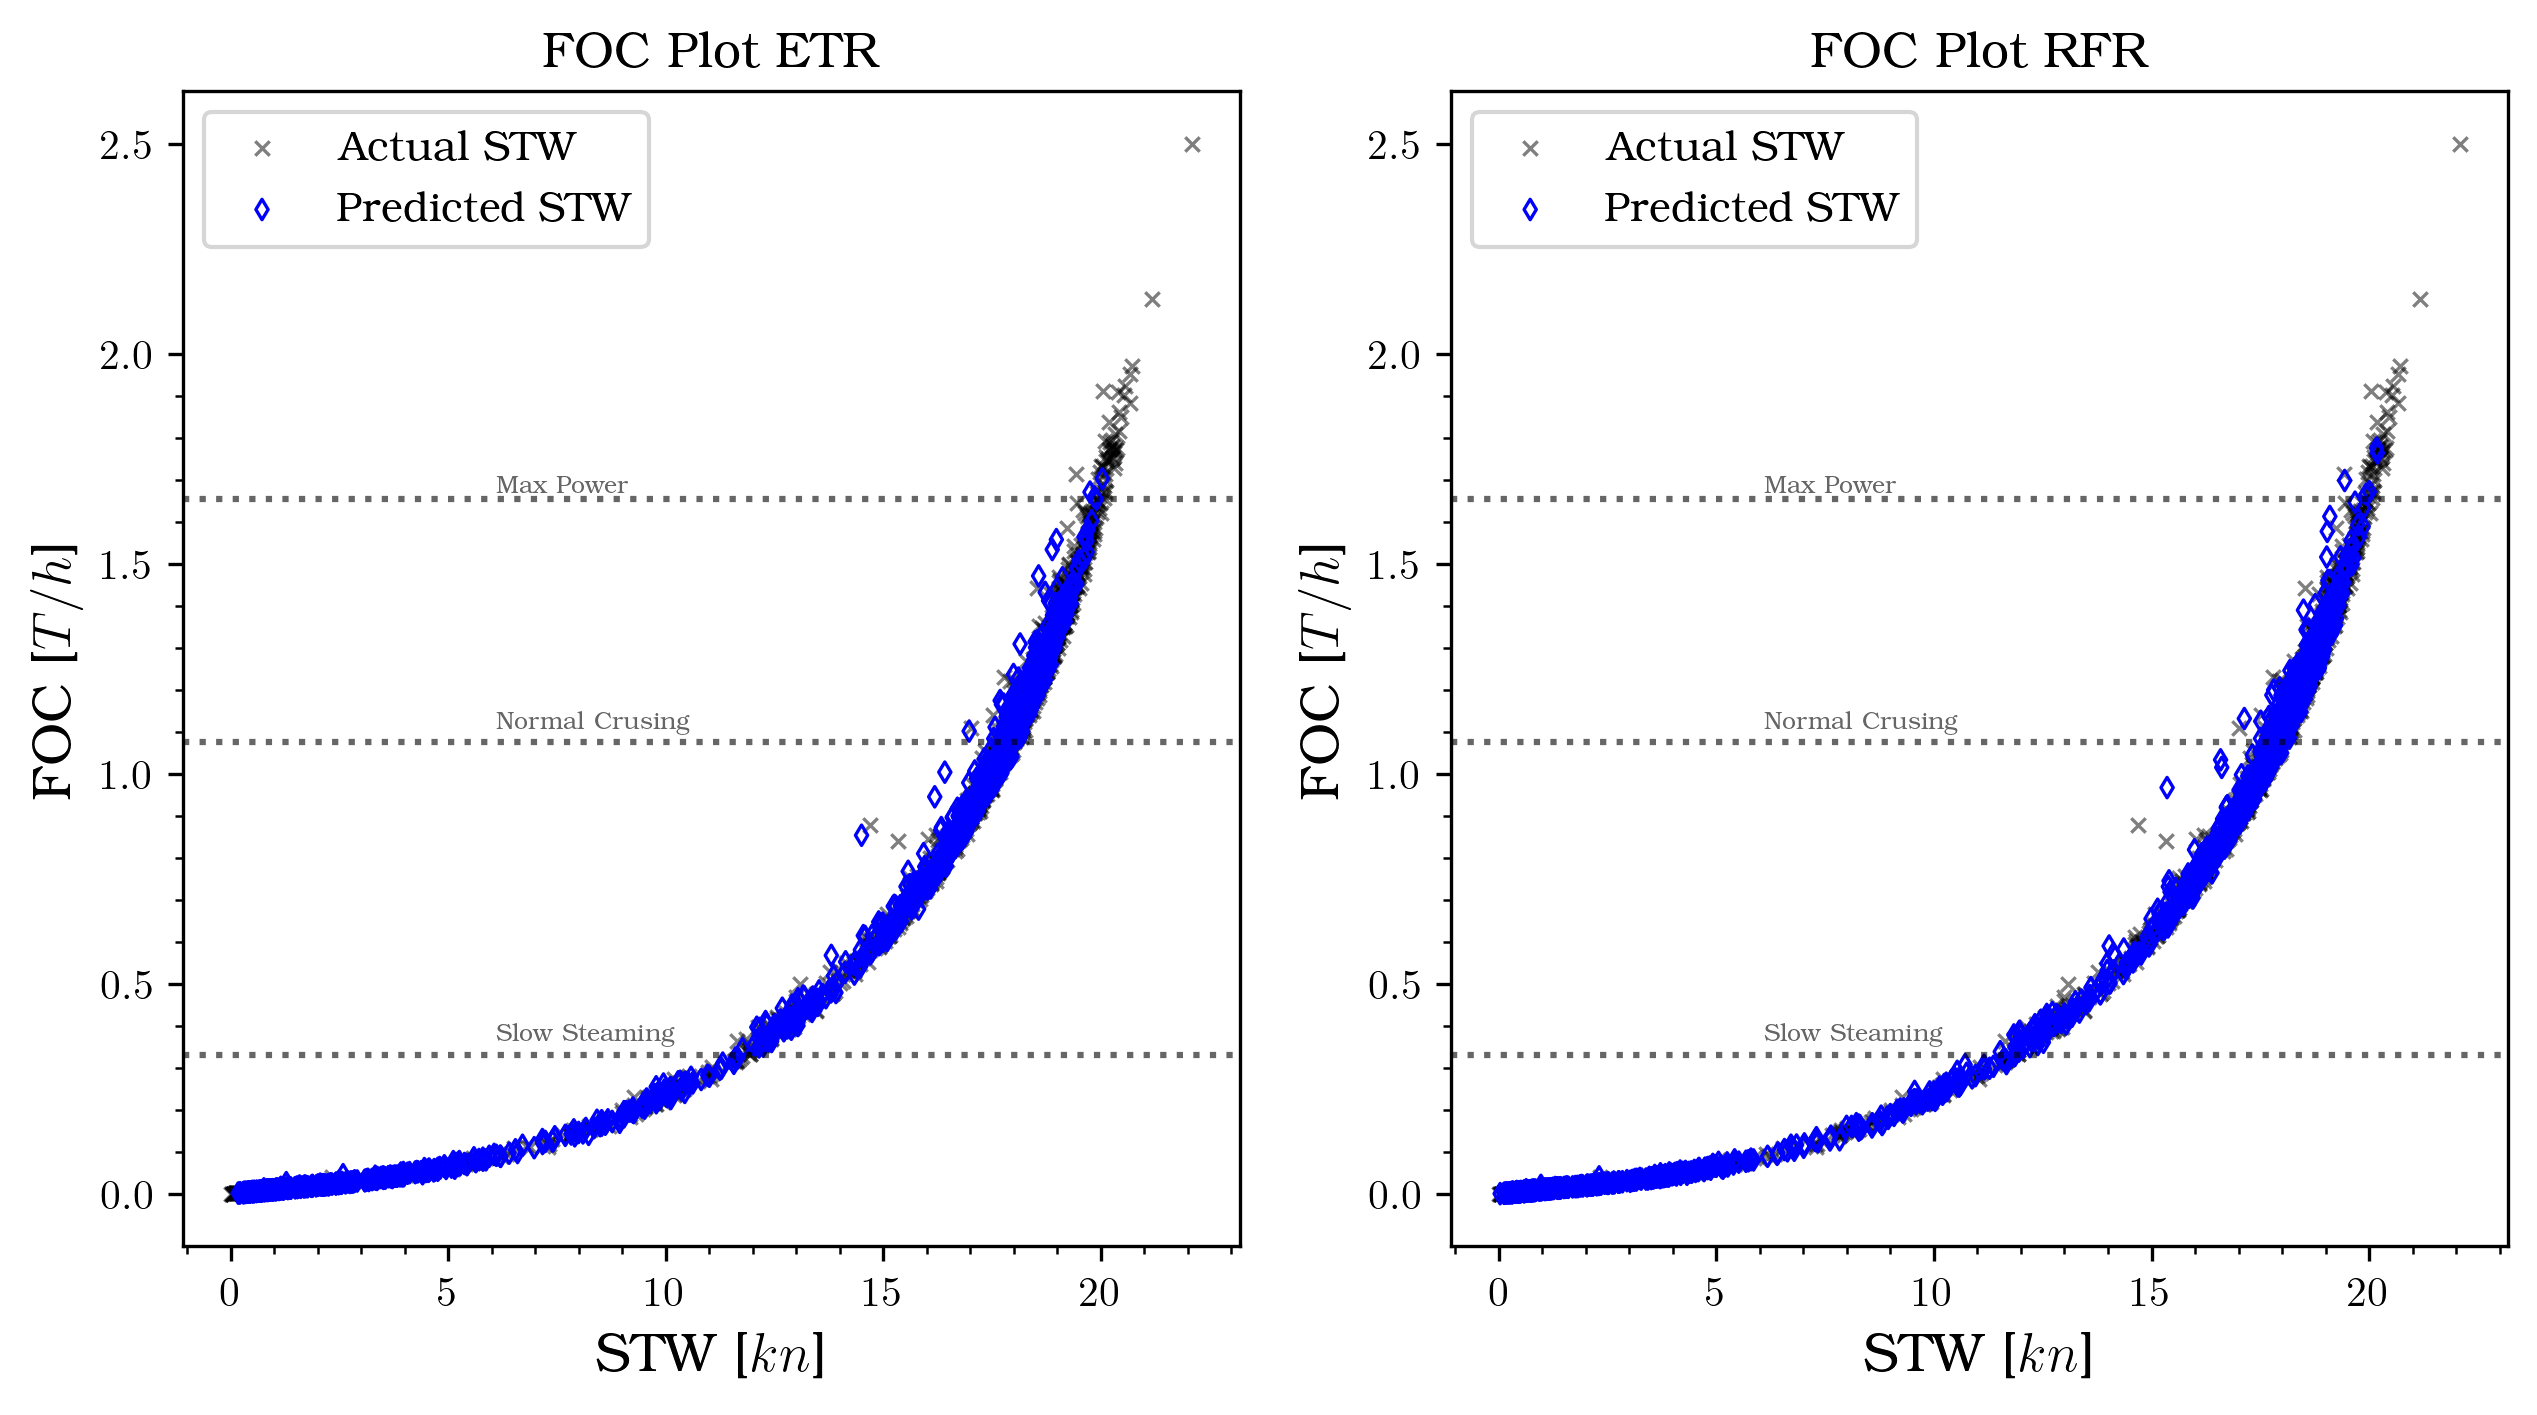

In [265]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
FOC_coeff_plot('ETR',stw_pred_et_yr,stw_act_yr,FOC_pred_yr,FOC_act_yr)
plt.sca(axes[1])
FOC_coeff_plot('RFR',stw_pred_rf_yr,stw_act_yr,FOC_pred_rf_yr,FOC_act_yr)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.2)
plt.show()

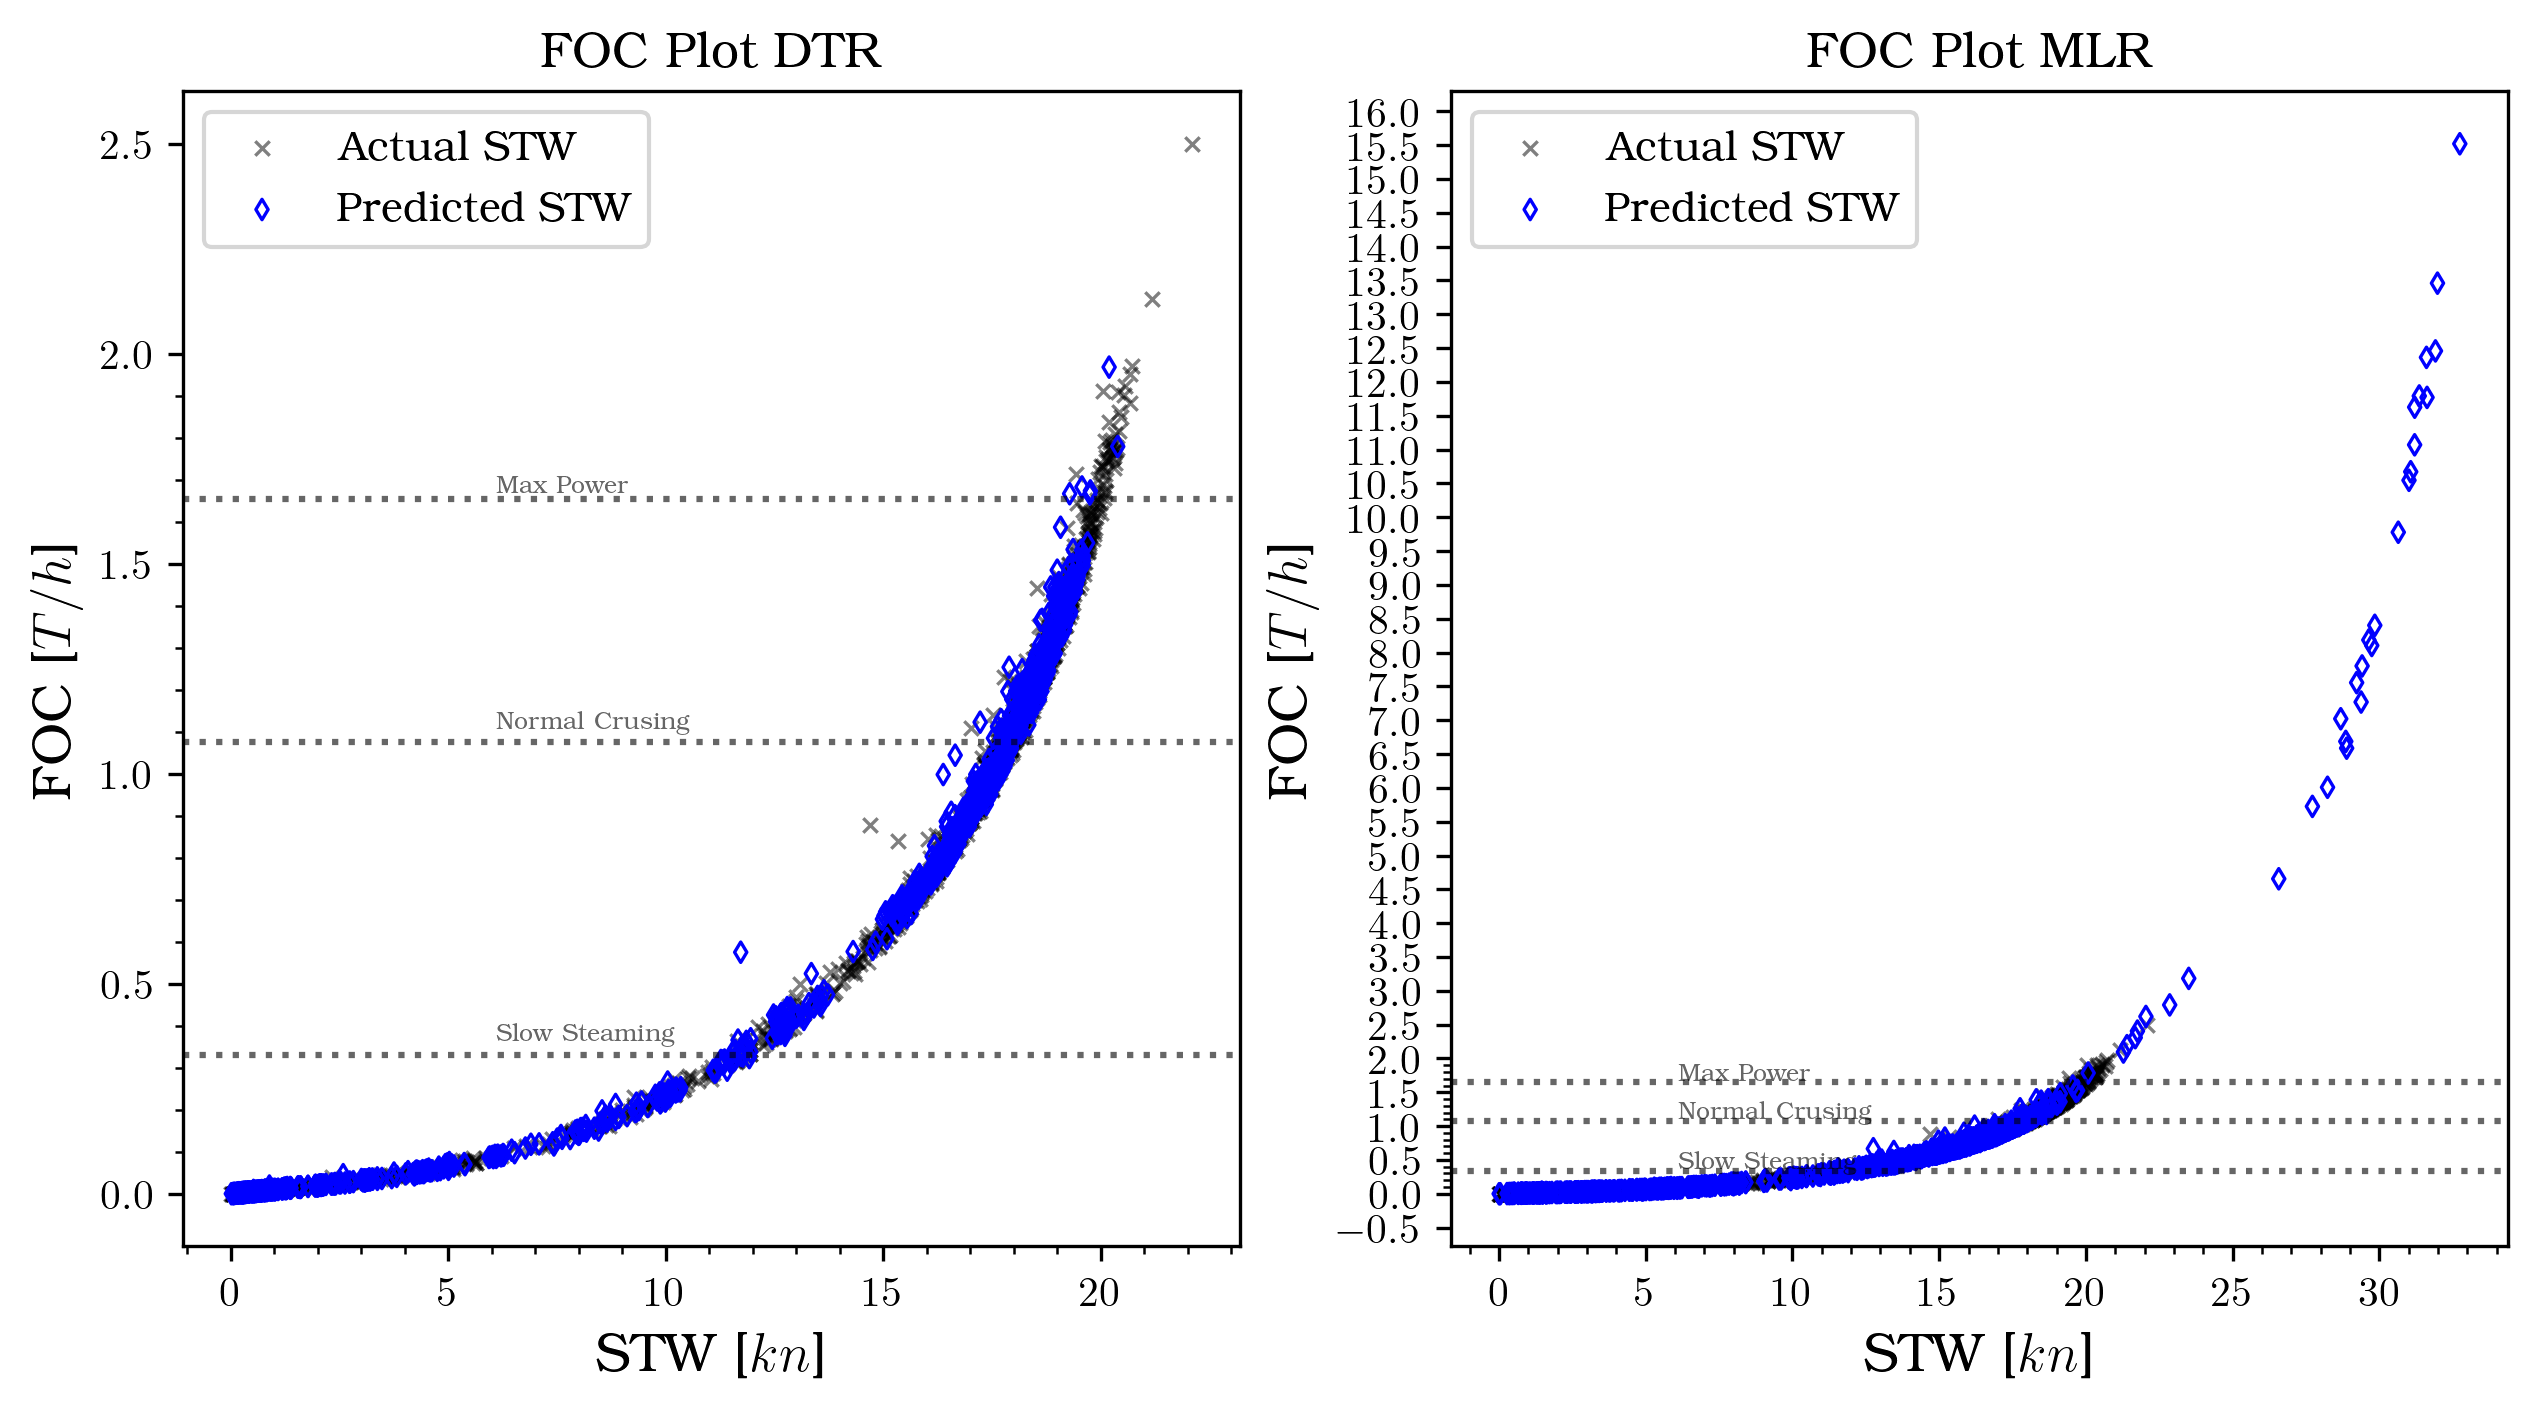

In [266]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
FOC_coeff_plot('DTR',stw_pred_dt_yr,stw_act_yr,FOC_pred_dt_yr,FOC_act_yr)
plt.sca(axes[1])
FOC_coeff_plot('MLR',stw_pred_mlr_yr,stw_act_yr,FOC_pred_mlr_yr,FOC_act_yr)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.2)
plt.show()

Actual data polyfit

Best Polynomial Equation:
$y = 0.0184 + (-0.0224)x^1 + (0.0099)x^2 + (-0.0008)x^3 + (0.0000)x^4$
Best Polynomial Equation:
$y = 0.0207 + (-0.0244)x^1 + (0.0106)x^2 + (-0.0009)x^3 + (0.0000)x^4$
Best Polynomial Equation:
$y = 0.0167 + (-0.0213)x^1 + (0.0095)x^2 + (-0.0008)x^3 + (0.0000)x^4$


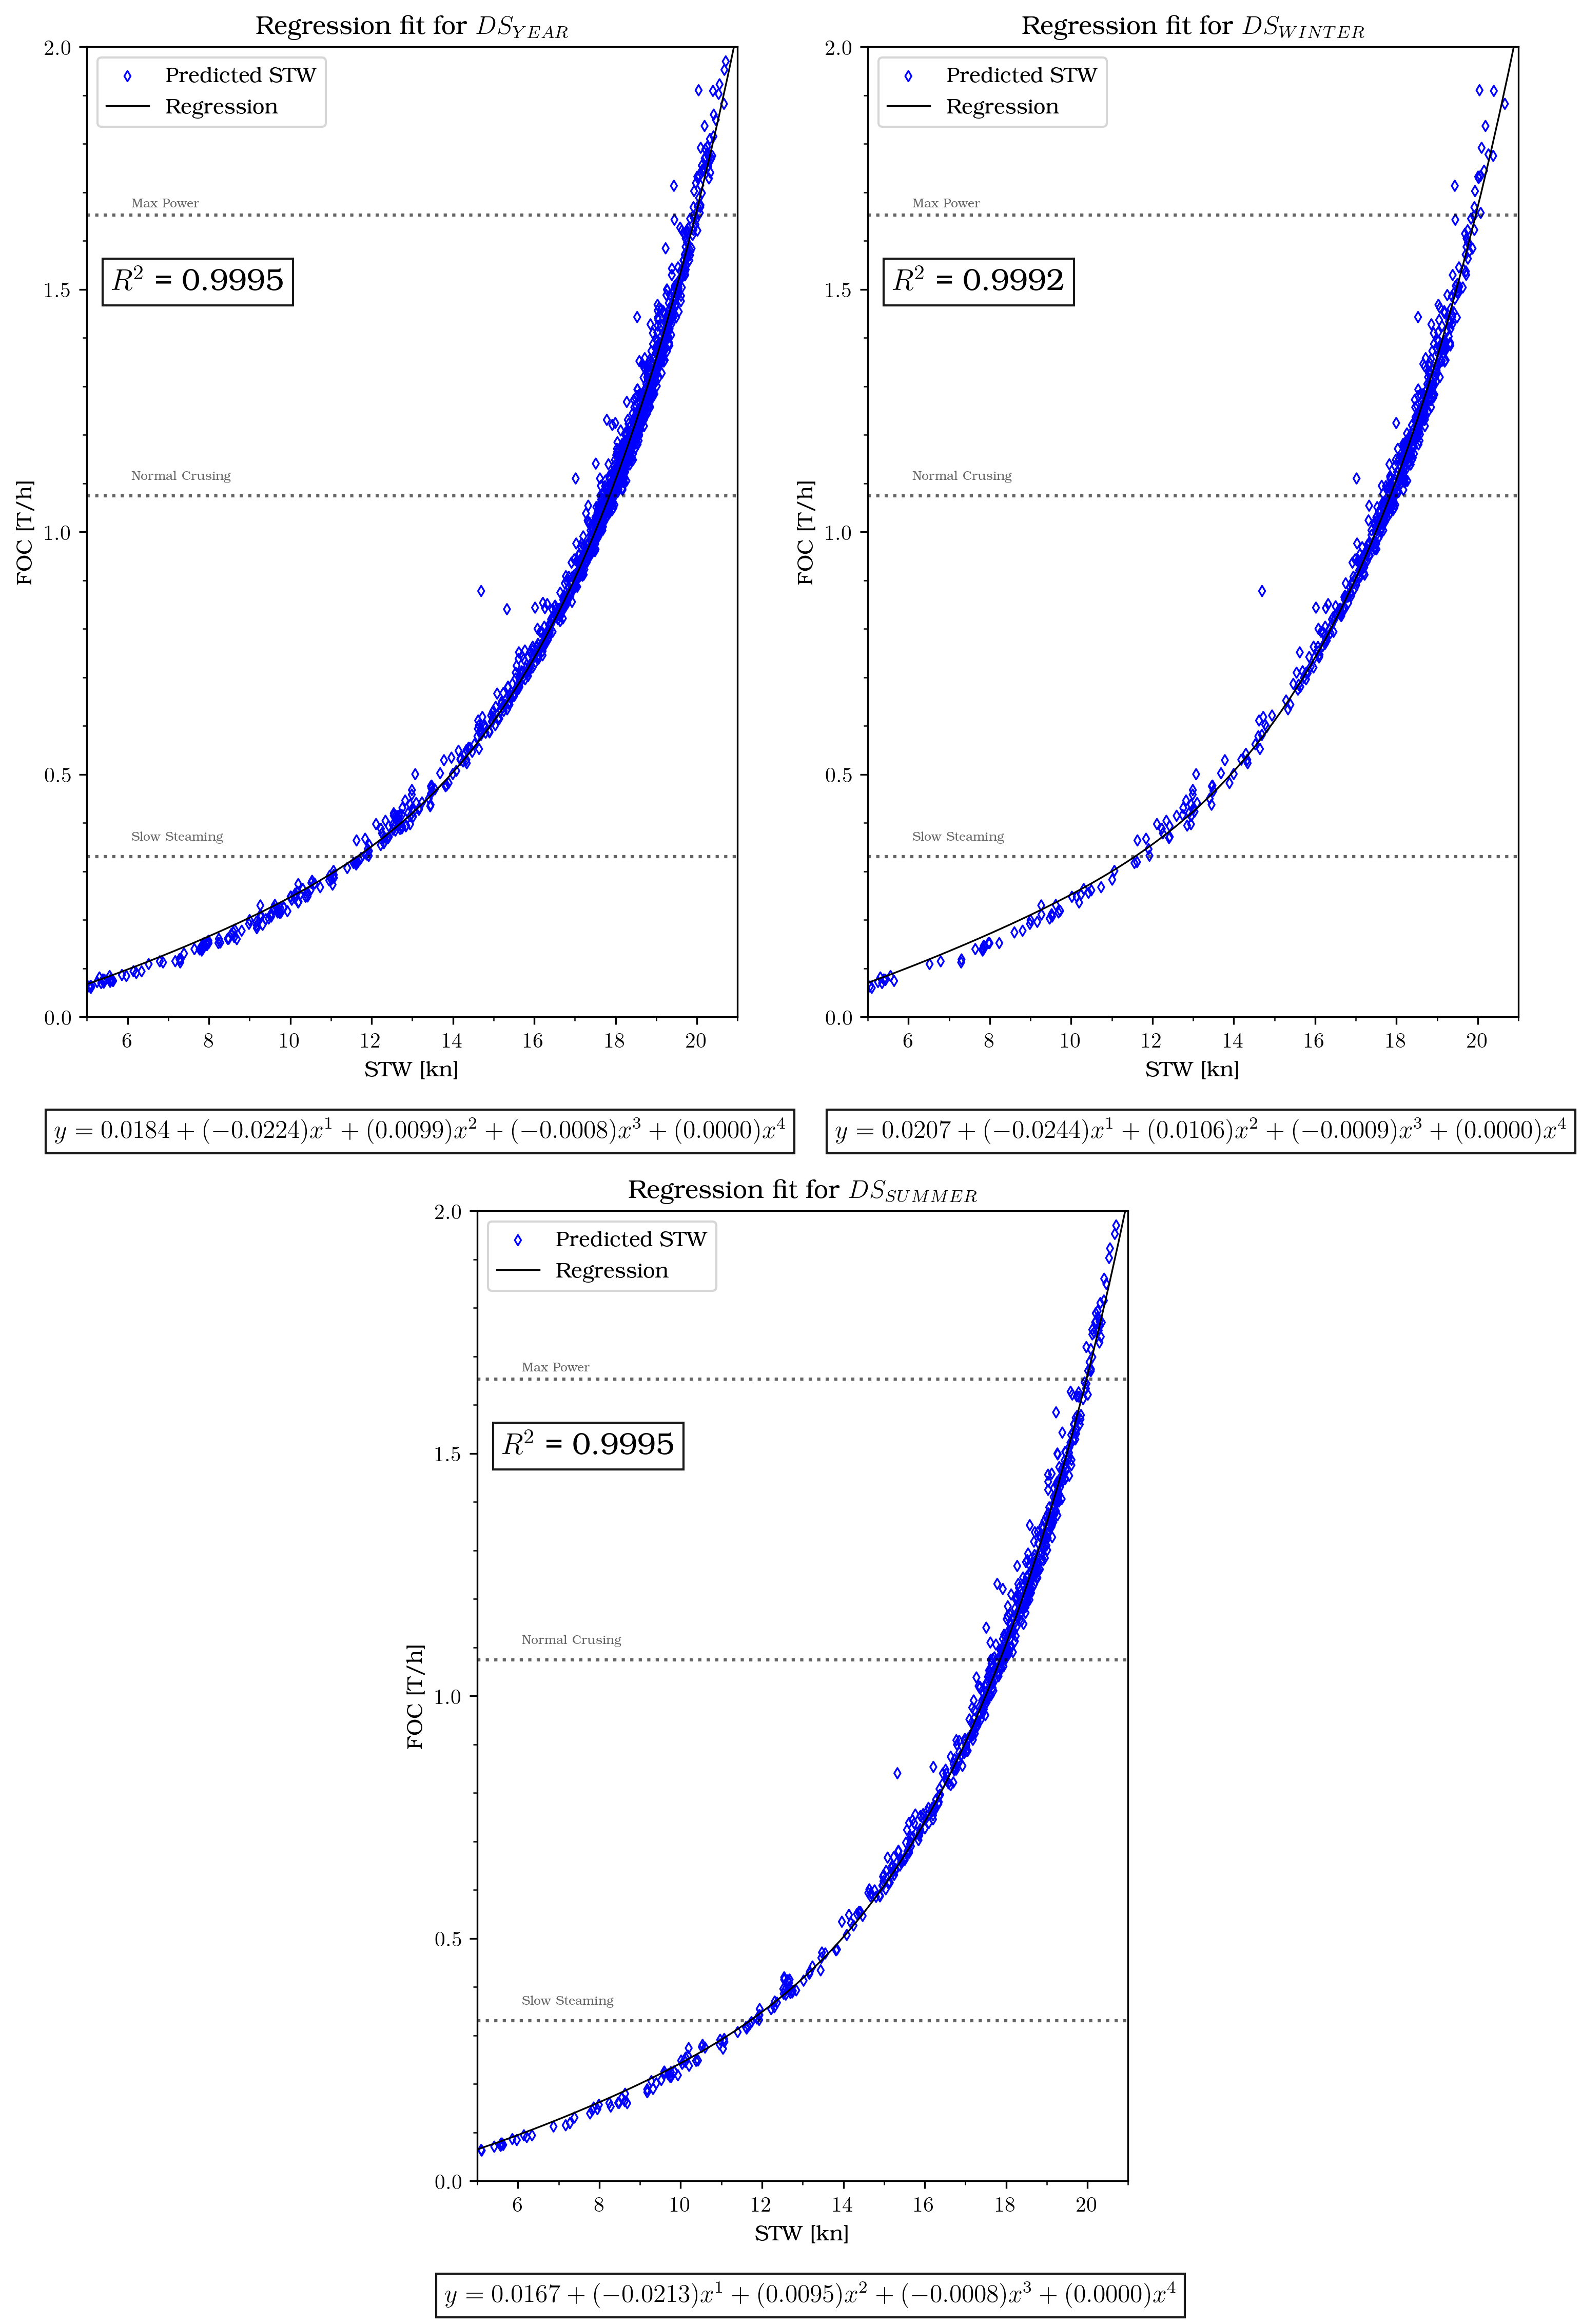

In [267]:
plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2] )
poly_act_yr = poly_reg_best_fit('DS_{YEAR}',stw_act_yr,FOC_act_yr)
ax2 = plt.subplot(gs[0, 2:])
poly_act_s = poly_reg_best_fit('DS_{WINTER}',stw_act_w,FOC_act_w)
ax3 = plt.subplot(gs[1, 1:3])
poly_act_w = poly_reg_best_fit('DS_{SUMMER}',stw_act_s,FOC_act_s)
plt.show()

ETR polyfit plot

Best Polynomial Equation:
$y = 0.0200 + (-0.0177)x^1 + (0.0082)x^2 + (-0.0007)x^3 + (0.0000)x^4$
Best Polynomial Equation:
$y = 0.0311 + (-0.0277)x^1 + (0.0106)x^2 + (-0.0009)x^3 + (0.0000)x^4$
Best Polynomial Equation:
$y = 0.0138 + (-0.0119)x^1 + (0.0068)x^2 + (-0.0006)x^3 + (0.0000)x^4$


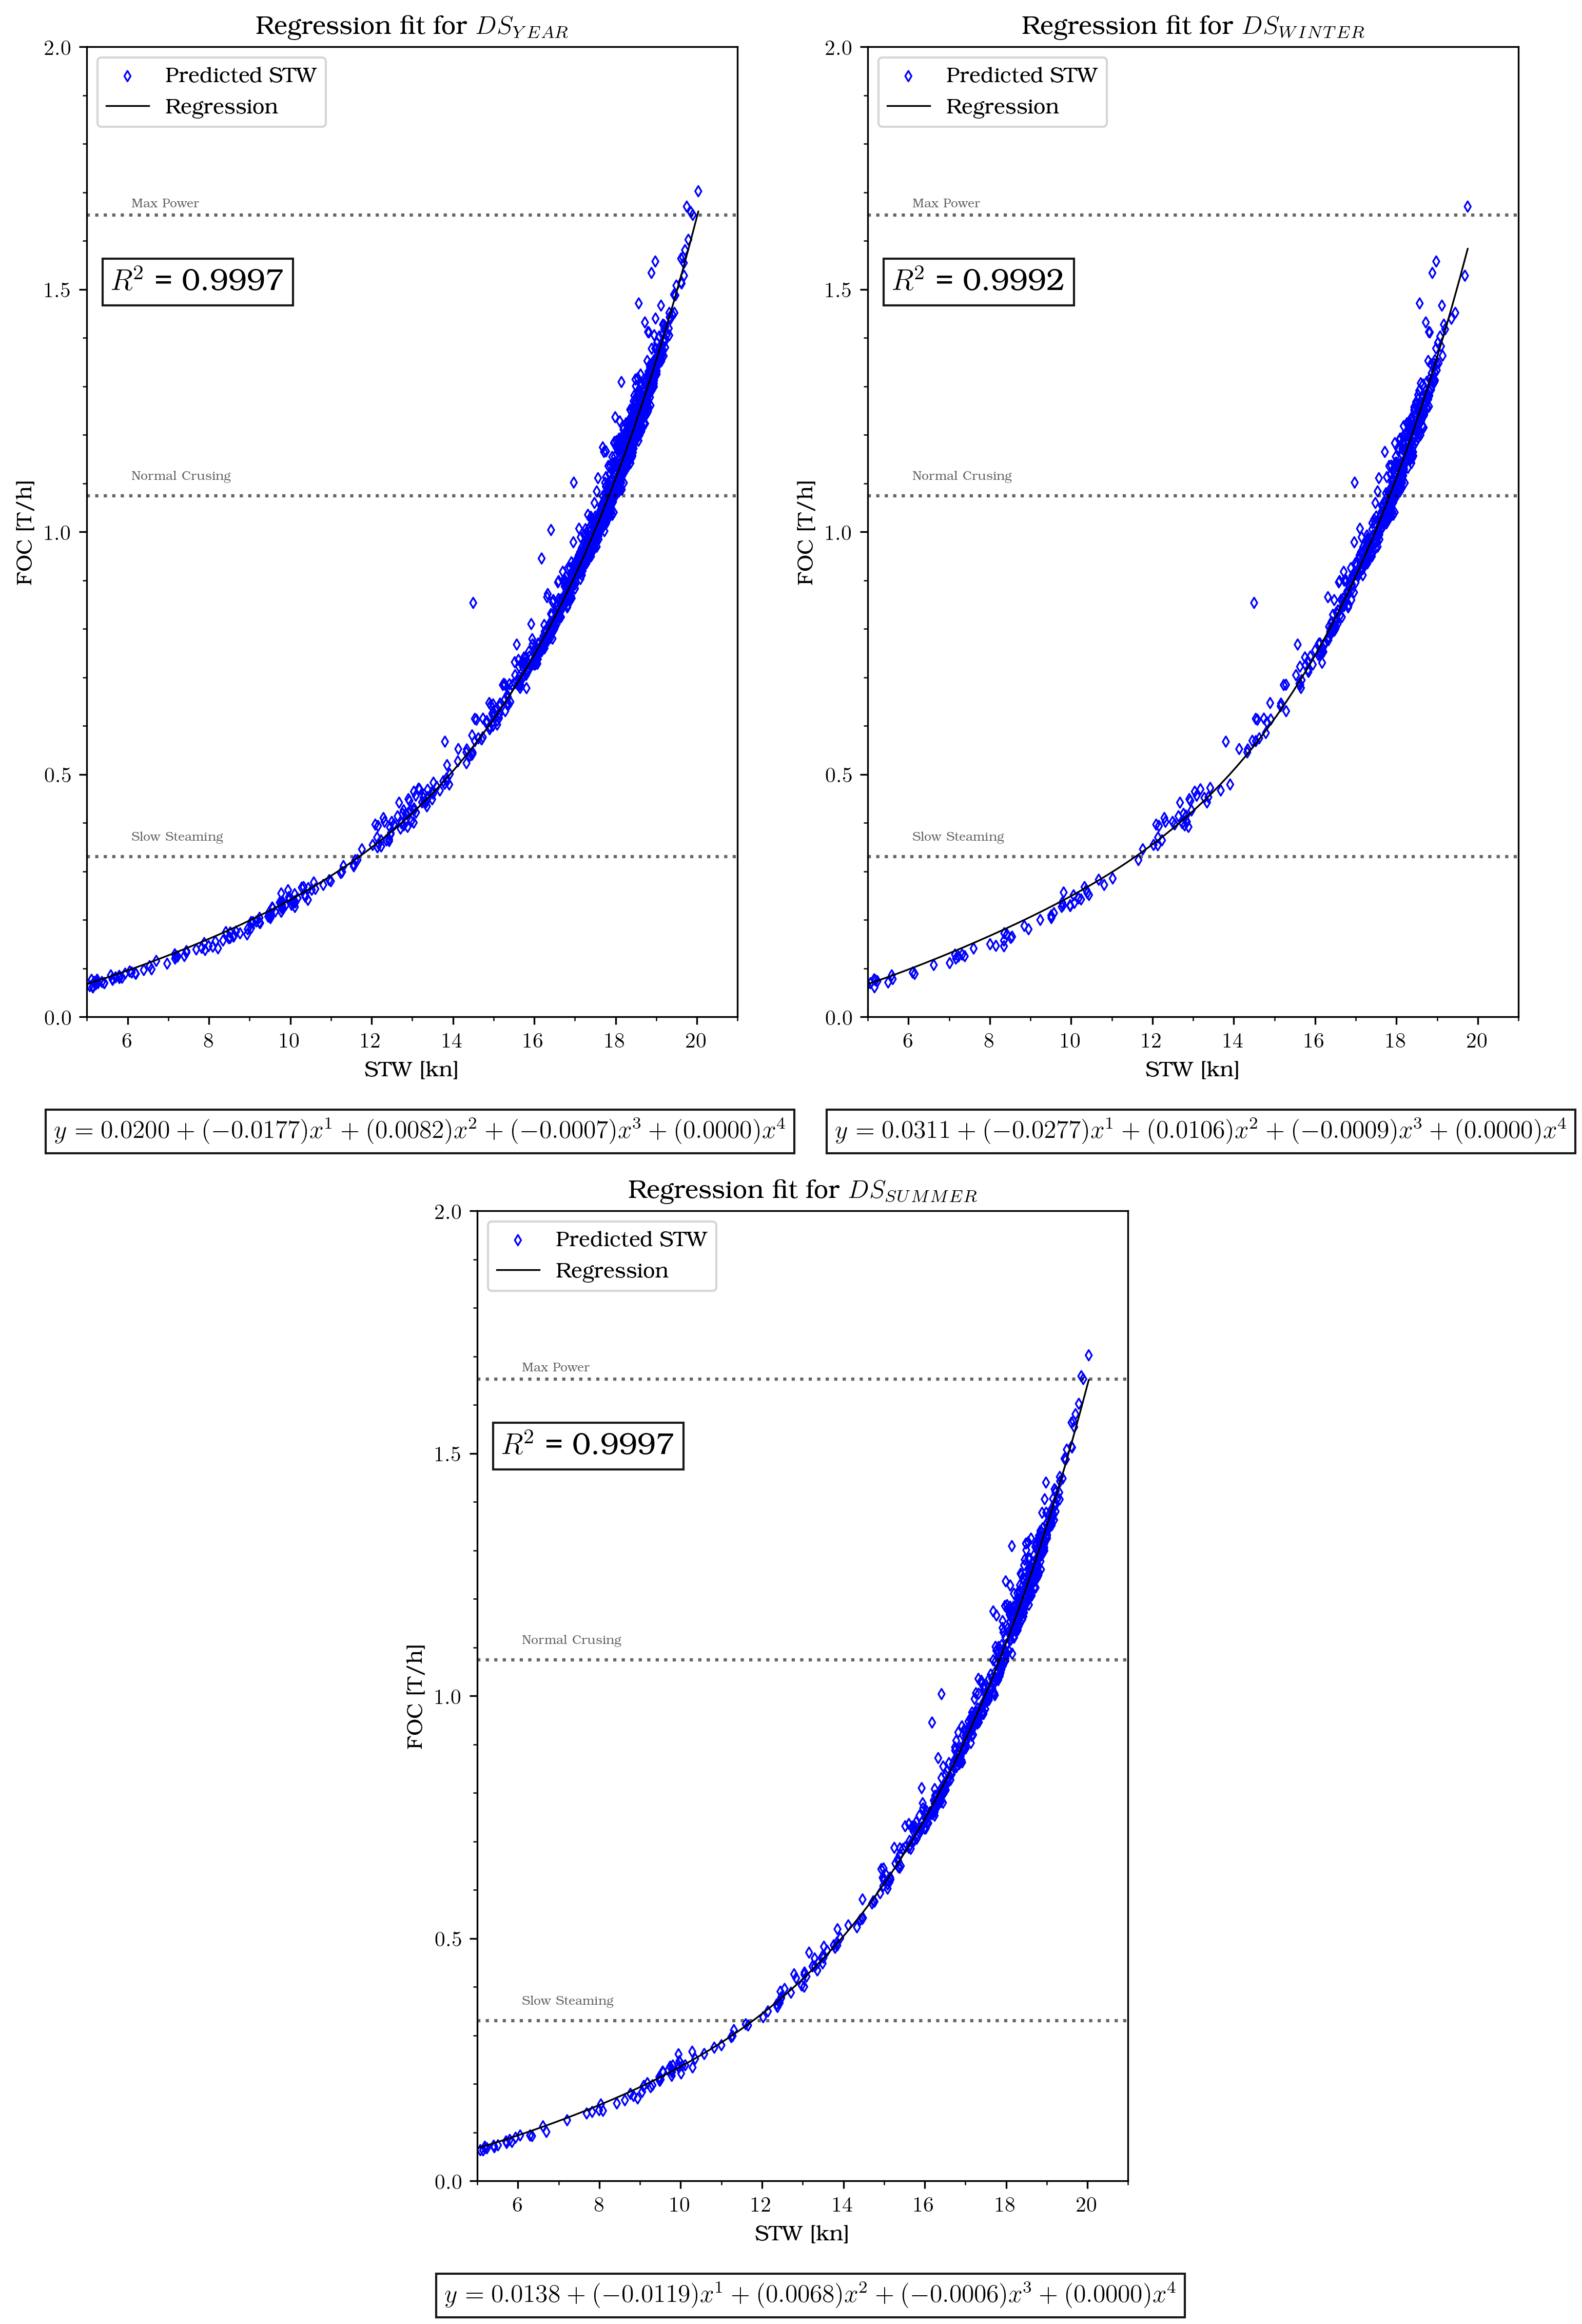

In [268]:
plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2] )
poly_etr_yr = poly_reg_best_fit('DS_{YEAR}',stw_pred_et_yr,FOC_pred_yr)
ax2 = plt.subplot(gs[0, 2:])
poly_etr_w = poly_reg_best_fit('DS_{WINTER}',stw_pred_et_w,FOC_pred_w)
ax3 = plt.subplot(gs[1, 1:3])
poly_etr_s = poly_reg_best_fit('DS_{SUMMER}',stw_pred_et_s,FOC_pred_s)
plt.show()

RFR polyfit FOC

Best Polynomial Equation:
$y = 0.0164 + (-0.0161)x^1 + (0.0081)x^2 + (-0.0007)x^3 + (0.0000)x^4$


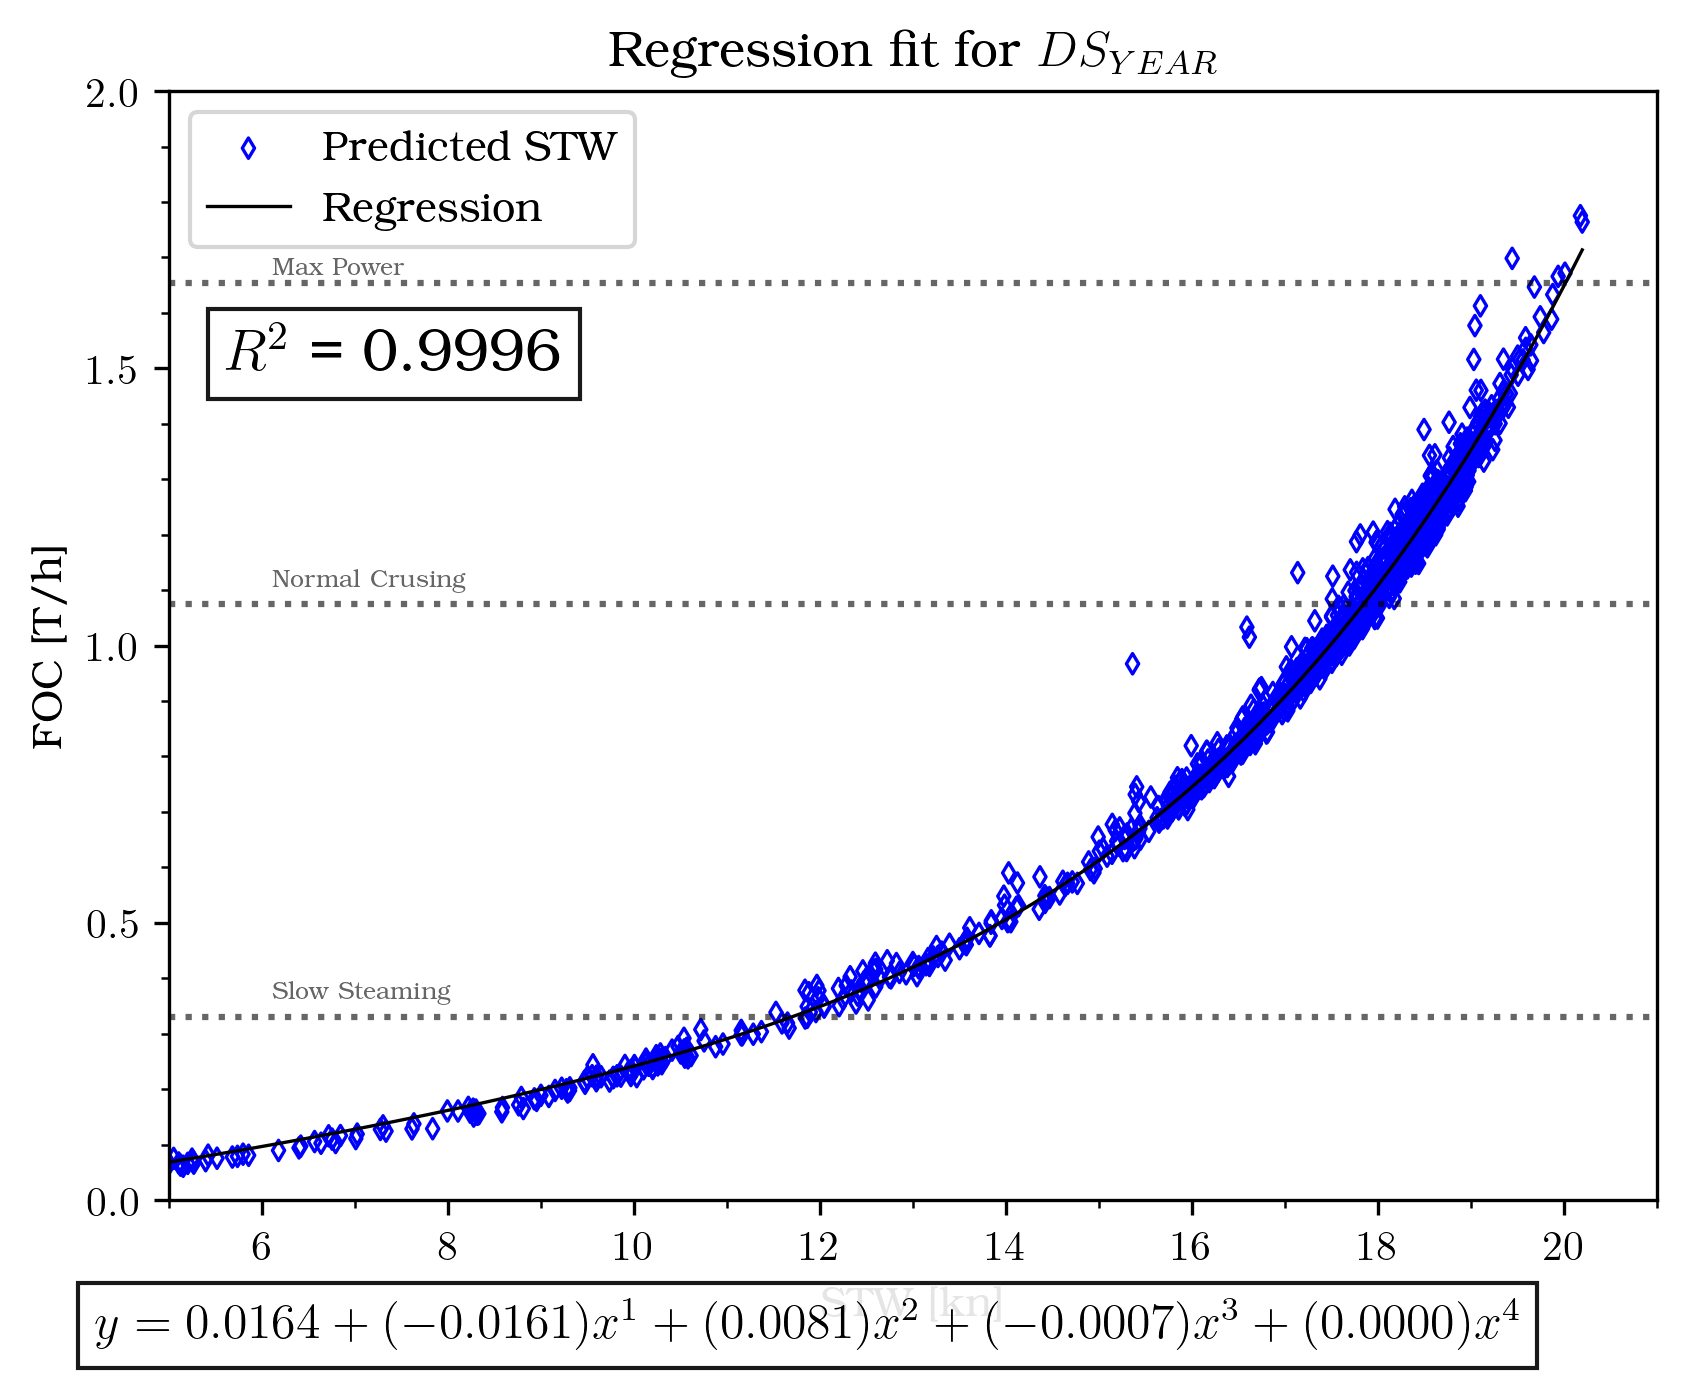

In [269]:
poly_rfr_yr = poly_reg_best_fit('DS_{YEAR}',stw_pred_rf_yr,FOC_pred_rf_yr)
plt.show()

Best Polynomial Equation:
$y = 0.0164 + (-0.0161)x^1 + (0.0081)x^2 + (-0.0007)x^3 + (0.0000)x^4$
Best Polynomial Equation:
$y = 0.0227 + (-0.0225)x^1 + (0.0097)x^2 + (-0.0008)x^3 + (0.0000)x^4$
Best Polynomial Equation:
$y = 0.0124 + (-0.0121)x^1 + (0.0070)x^2 + (-0.0006)x^3 + (0.0000)x^4$


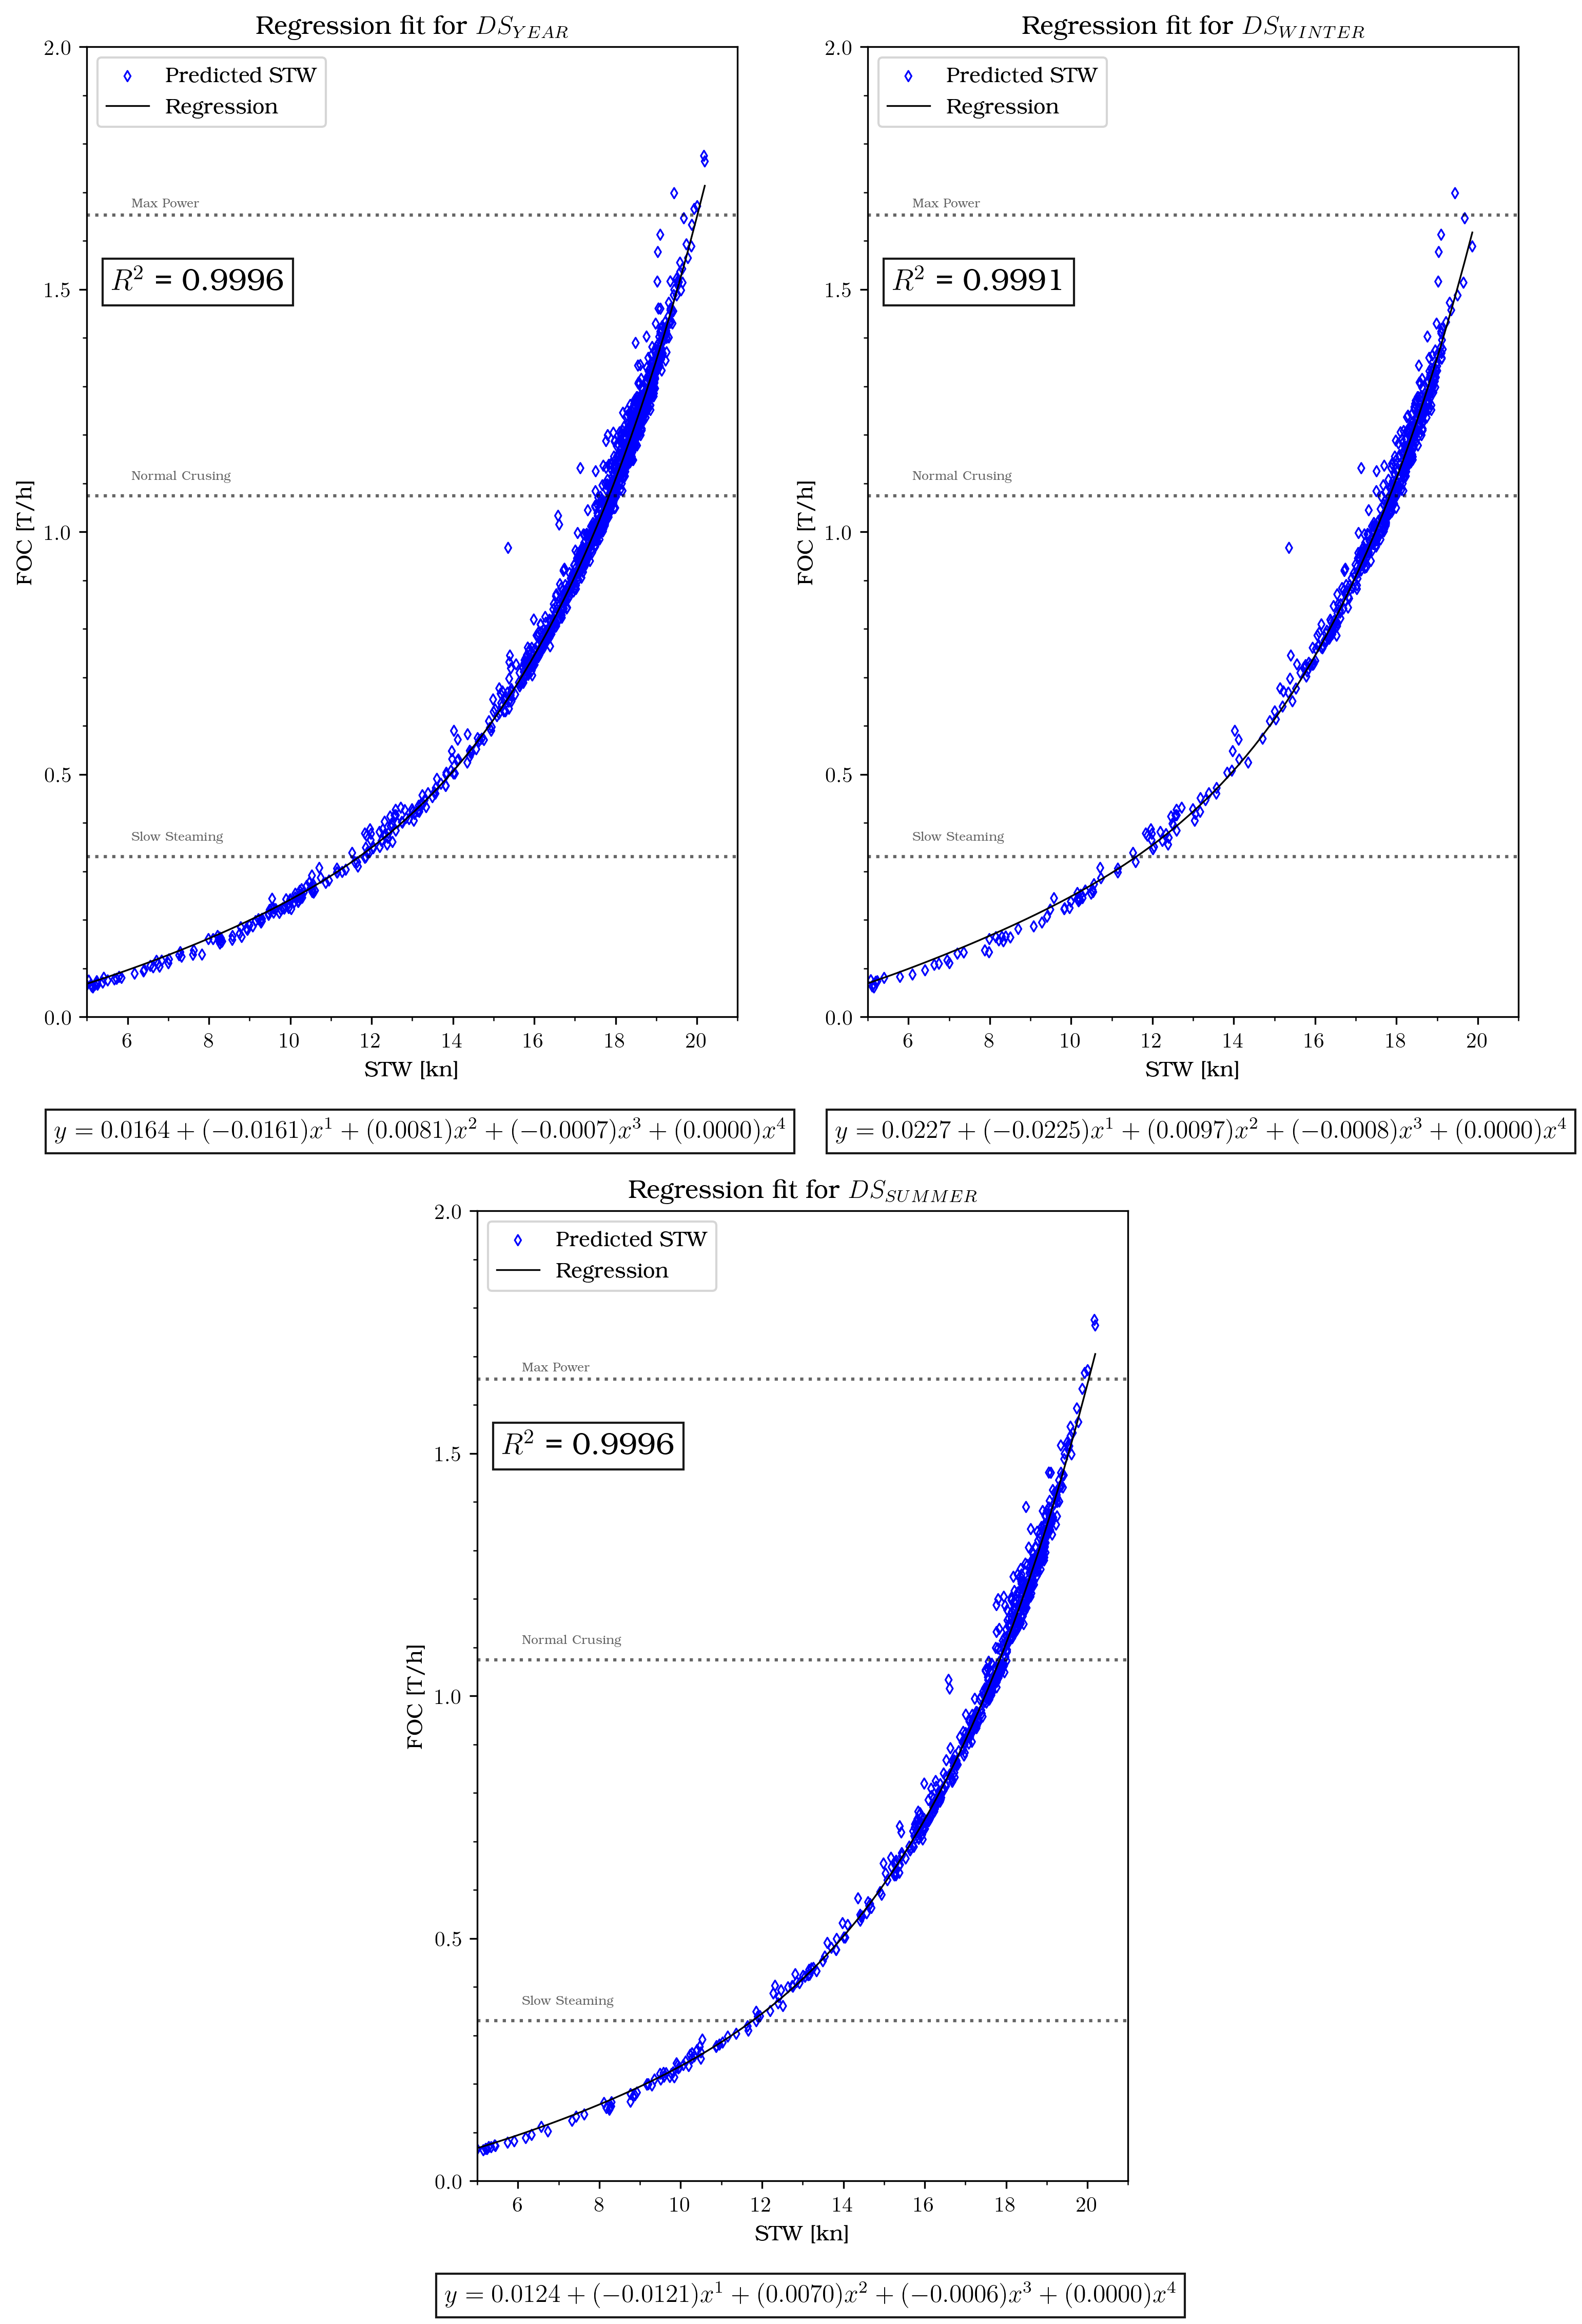

In [270]:
plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2] )
poly_rfr_yr = poly_reg_best_fit('DS_{YEAR}',stw_pred_rf_yr,FOC_pred_rf_yr)
ax2 = plt.subplot(gs[0, 2:])
poly_rfr_w = poly_reg_best_fit('DS_{WINTER}',stw_pred_rf_w,FOC_pred_rf_w)
ax3 = plt.subplot(gs[1, 1:3])
poly_rfr_s = poly_reg_best_fit('DS_{SUMMER}',stw_pred_rf_s,FOC_pred_rf_s)
plt.show()

DTR

Best Polynomial Equation:
$y = 0.0167 + (-0.0189)x^1 + (0.0089)x^2 + (-0.0008)x^3 + (0.0000)x^4$
Best Polynomial Equation:
$y = 0.0235 + (-0.0263)x^1 + (0.0109)x^2 + (-0.0009)x^3 + (0.0000)x^4$
Best Polynomial Equation:
$y = 0.0114 + (-0.0122)x^1 + (0.0071)x^2 + (-0.0006)x^3 + (0.0000)x^4$


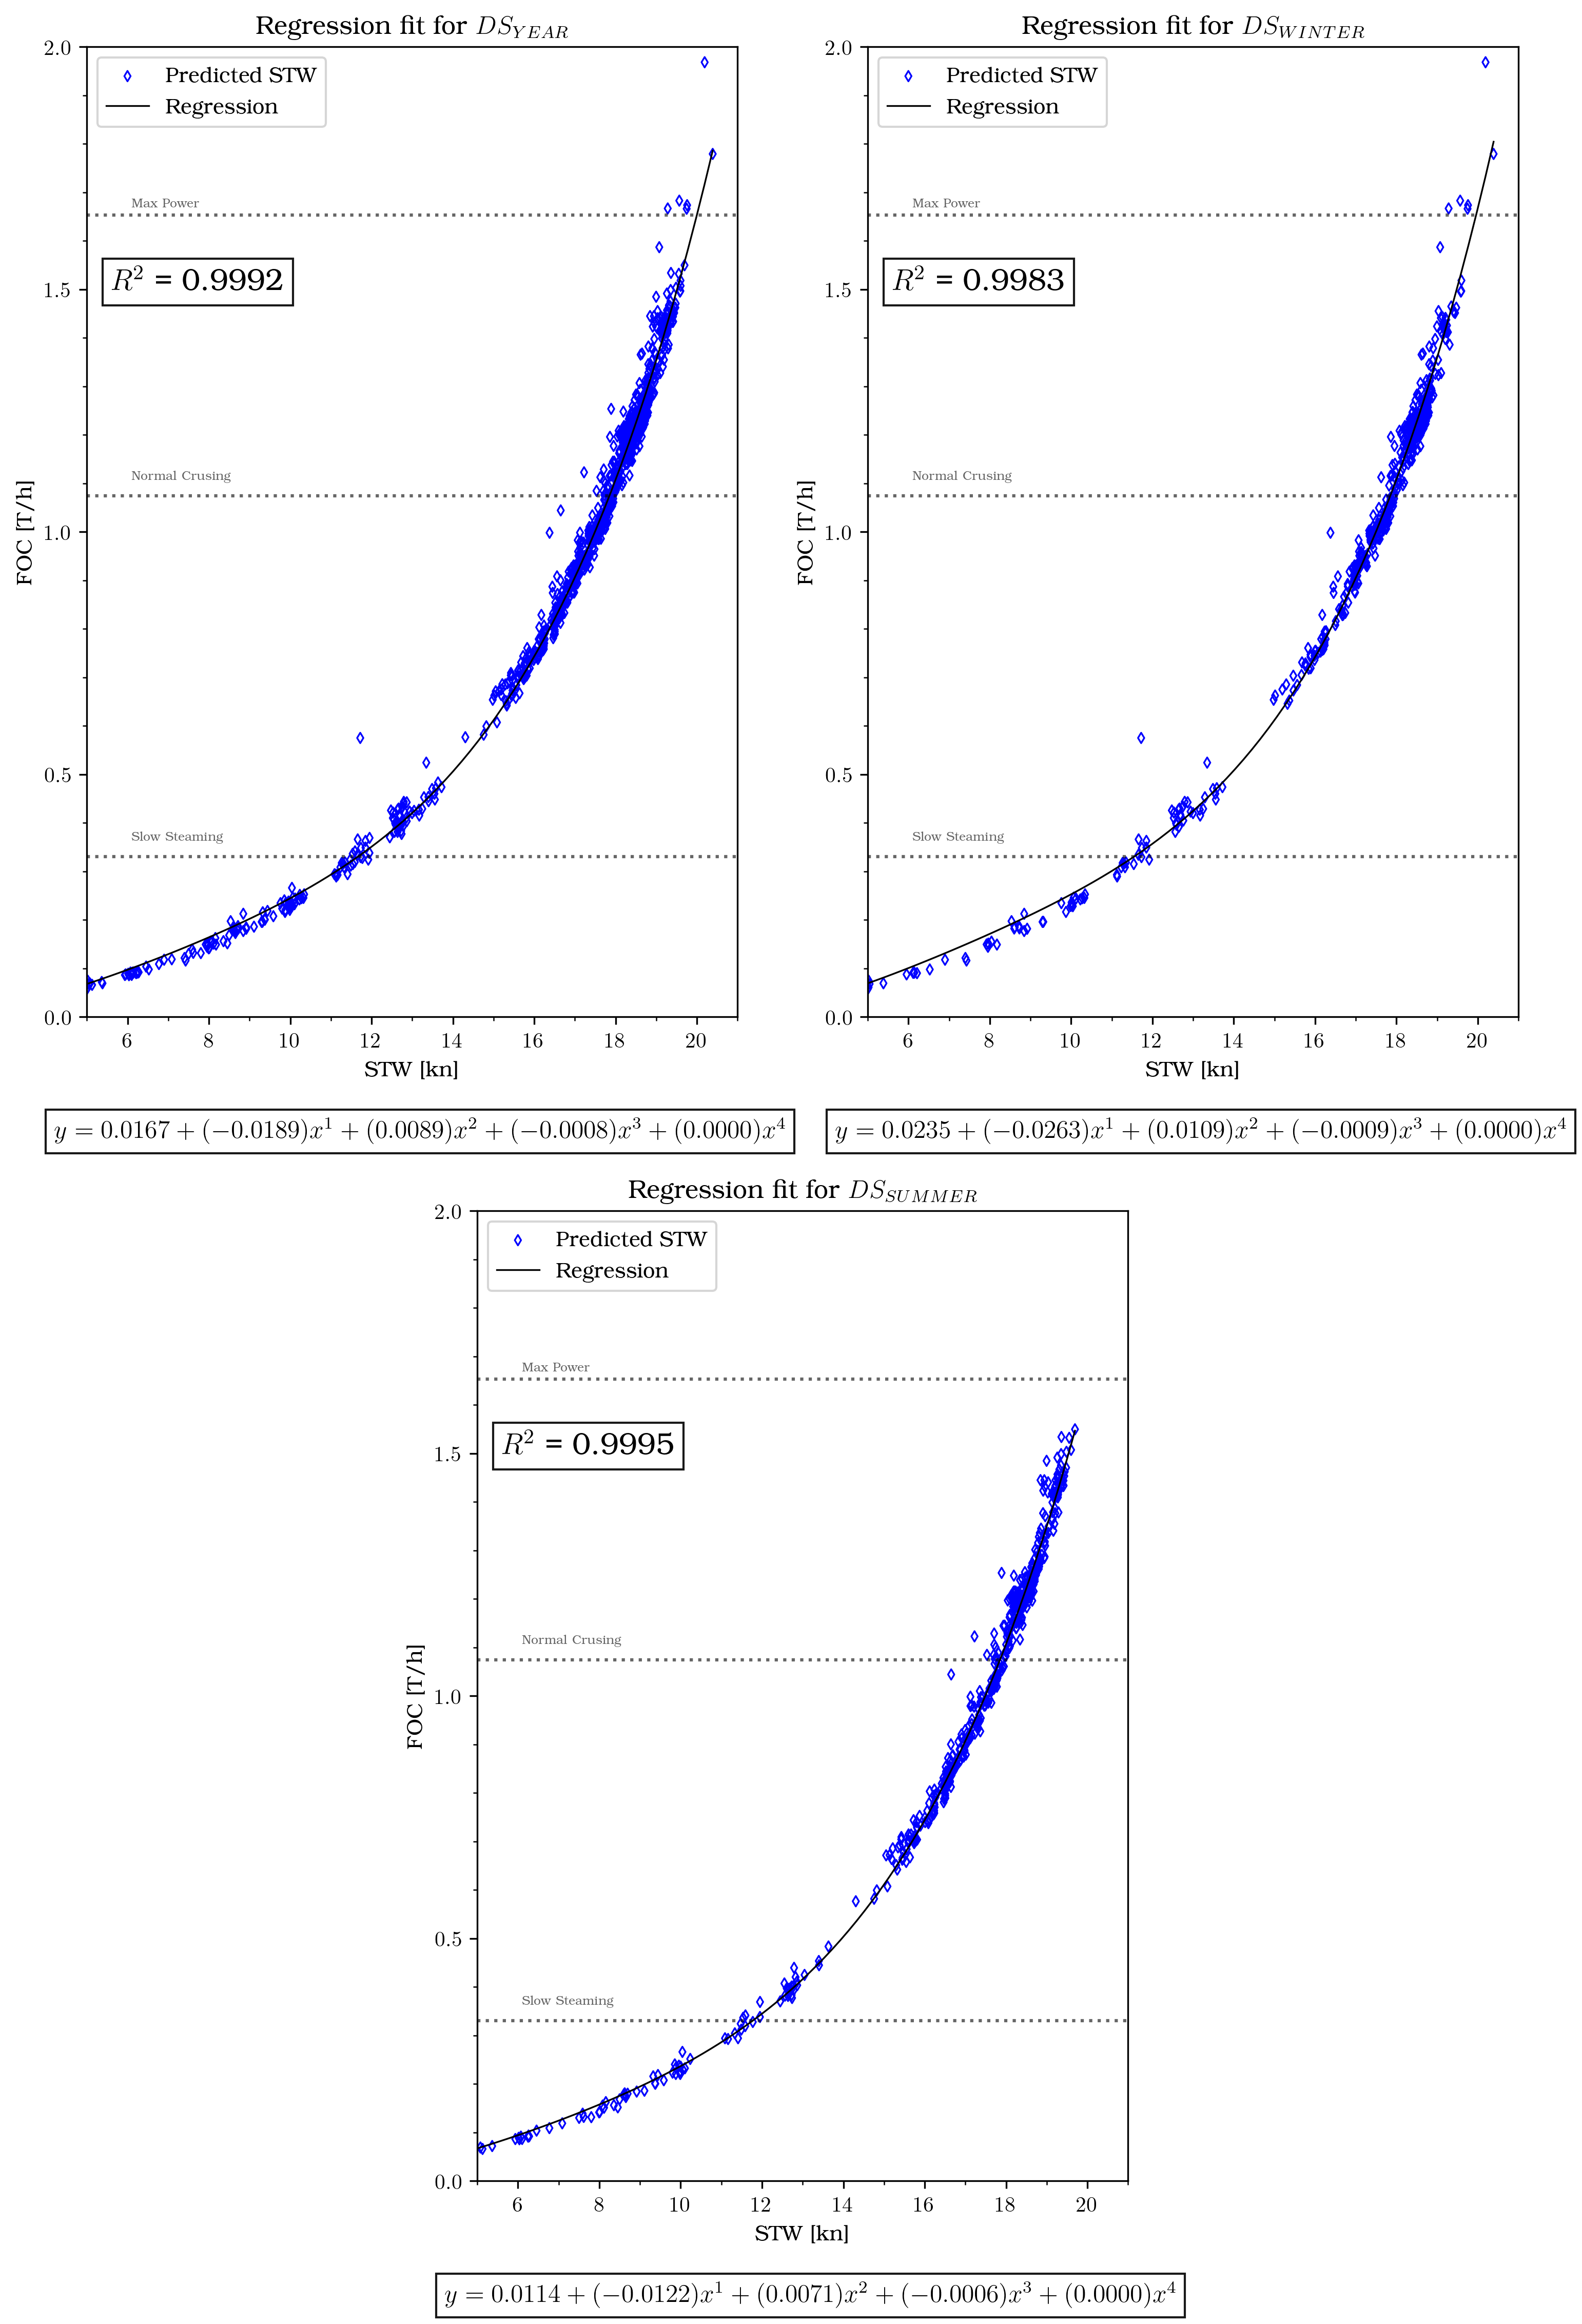

In [271]:
plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2] )
poly_dtr_yr = poly_reg_best_fit('DS_{YEAR}',stw_pred_dt_yr,FOC_pred_dt_yr)
ax2 = plt.subplot(gs[0, 2:])
poly_dtr_w = poly_reg_best_fit('DS_{WINTER}',stw_pred_dt_w,FOC_pred_dt_w)
ax3 = plt.subplot(gs[1, 1:3])
poly_dtr_s = poly_reg_best_fit('DS_{SUMMER}',stw_pred_dt_s,FOC_pred_dt_s)
plt.show()

Evaluating model performance on FOC prediction

In [272]:
# This function defines the model performance for the given stw range

def evaluate_FOC(model,FOC_act,FOC_pred):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    Rsquared_FOC = r2_score(FOC_act,FOC_pred)
    expVar_FOC = explained_variance_score(FOC_act,FOC_pred)
    MAE_FOC = mean_absolute_error(FOC_act,FOC_pred)
    RMSE_FOC = np.sqrt(mean_squared_error(FOC_act, FOC_pred))
    MAD_FOC = median_absolute_error(FOC_act,FOC_pred)
    MAPE_FOC = mean_absolute_percentage_error(FOC_act, FOC_pred)
    
    print(f"Model Performance of {model}")
    print(f"R^2 {Rsquared_FOC:0.4f}")
    print(f"Explained Variance {expVar_FOC:0.4f}")
    print(f"MAE {MAE_FOC:0.4f} T/h")    
    print(f"RMSE FOC {RMSE_FOC:0.4f} T/h")
    print(f"MAD {MAD_FOC:0.4f} T/h")    
    print(f"MAPE FOC {MAPE_FOC*100:0.4f} %")


ETR

In [273]:
# Yearly performance 


evaluate_FOC(model_etr_hpov,FOC_act_yr.dropna(),FOC_pred_yr.dropna())

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.8684
Explained Variance 0.8765
MAE 0.1226 T/h
RMSE FOC 0.1904 T/h
MAD 0.0726 T/h
MAPE FOC 100.2890 %


In [274]:
evaluate_FOC(model_etr_hpov,FOC_act_s.dropna(),FOC_pred_s.dropna())

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.8820
Explained Variance 0.8888
MAE 0.1198 T/h
RMSE FOC 0.1829 T/h
MAD 0.0754 T/h
MAPE FOC 110.0558 %


In [275]:
evaluate_FOC(model_etr_hpov,FOC_act_w.dropna(),FOC_pred_w.dropna())

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.8531
Explained Variance 0.8627
MAE 0.1257 T/h
RMSE FOC 0.1978 T/h
MAD 0.0712 T/h
MAPE FOC 89.8829 %


RFR

In [276]:
# On yearly data

evaluate_FOC(model_rfr_hpov,FOC_act_yr.dropna(),FOC_pred_rf_yr.dropna())

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 0.8790
Explained Variance 0.8833
MAE 0.1146 T/h
RMSE FOC 0.1826 T/h
MAD 0.0698 T/h
MAPE FOC 83.4843 %


In [277]:
evaluate_FOC(model_rfr_hpov,FOC_act_s.dropna(),FOC_pred_rf_s.dropna())

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 0.8869
Explained Variance 0.8908
MAE 0.1131 T/h
RMSE FOC 0.1792 T/h
MAD 0.0690 T/h
MAPE FOC 91.6553 %


In [278]:
evaluate_FOC(model_rfr_hpov,FOC_act_w.dropna(),FOC_pred_rf_w.dropna())

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 0.8695
Explained Variance 0.8744
MAE 0.1165 T/h
RMSE FOC 0.1865 T/h
MAD 0.0702 T/h
MAPE FOC 74.8224 %


DTR

In [279]:
evaluate_FOC(model_dtr_hpov,FOC_act_yr.dropna(),FOC_pred_dt_yr.dropna())

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 0.8241
Explained Variance 0.8254
MAE 0.1385 T/h
RMSE FOC 0.2201 T/h
MAD 0.0788 T/h
MAPE FOC 66.8798 %


In [280]:
evaluate_FOC(model_dtr_hpov,FOC_act_s.dropna(),FOC_pred_dt_s.dropna())

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 0.8226
Explained Variance 0.8245
MAE 0.1440 T/h
RMSE FOC 0.2244 T/h
MAD 0.0848 T/h
MAPE FOC 44.3480 %


In [281]:
evaluate_FOC(model_dtr_hpov,FOC_act_w.dropna(),FOC_pred_dt_w.dropna())

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 0.8250
Explained Variance 0.8258
MAE 0.1327 T/h
RMSE FOC 0.2159 T/h
MAD 0.0763 T/h
MAPE FOC 91.4655 %


MLR

In [282]:
#yearly data

evaluate_FOC(model_mlr_ftr,FOC_act_yr.dropna(),FOC_pred_mlr_yr.dropna())

Model Performance of LinearRegression()
R^2 -5.0883
Explained Variance -5.0881
MAE 0.4176 T/h
RMSE FOC 1.2950 T/h
MAD 0.2115 T/h
MAPE FOC 30825.8193 %


In [283]:
evaluate_FOC(model_mlr_ftr,FOC_act_s.dropna(),FOC_pred_mlr_s.dropna())

Model Performance of LinearRegression()
R^2 -3.8473
Explained Variance -3.8455
MAE 0.4051 T/h
RMSE FOC 1.1728 T/h
MAD 0.2078 T/h
MAPE FOC 52618.4912 %


In [284]:
evaluate_FOC(model_mlr_ftr,FOC_act_w.dropna(),FOC_pred_mlr_w.dropna())

Model Performance of LinearRegression()
R^2 -6.5261
Explained Variance -6.5258
MAE 0.4318 T/h
RMSE FOC 1.4160 T/h
MAD 0.2147 T/h
MAPE FOC 7123.7520 %


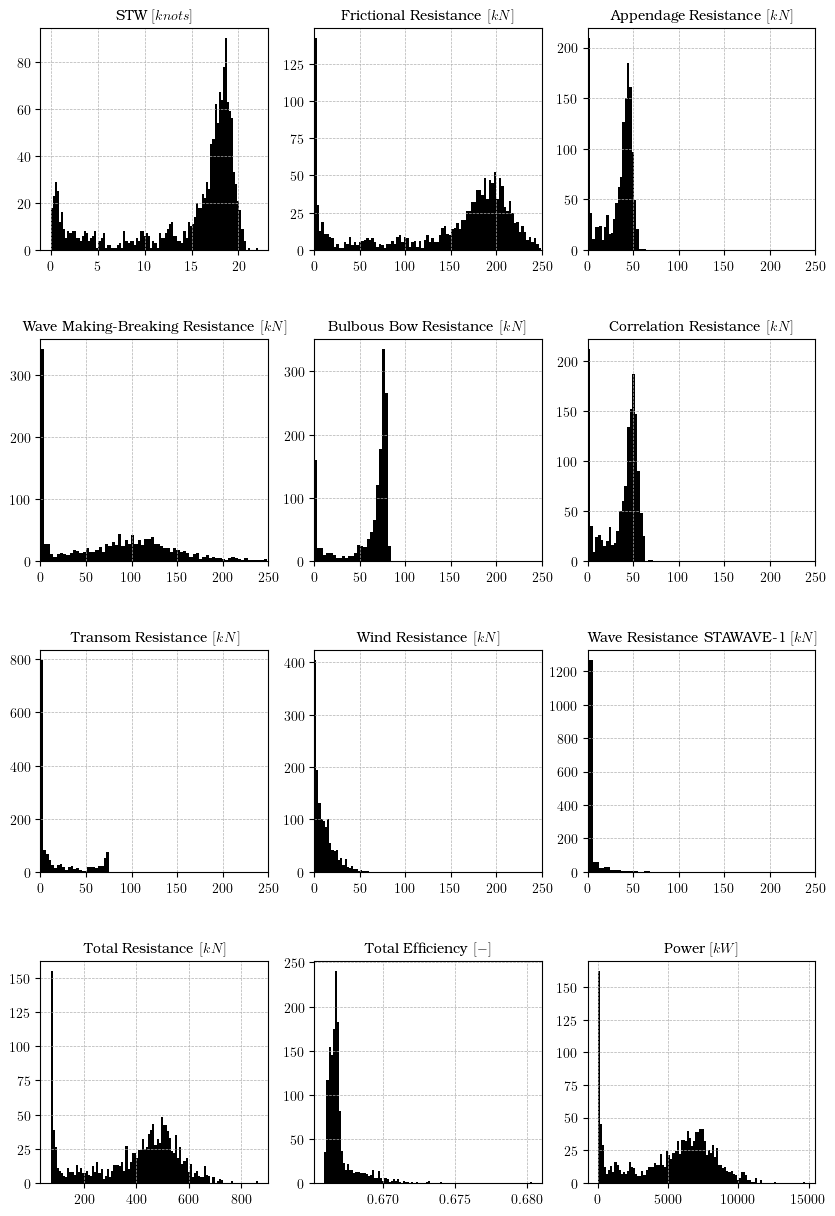

In [285]:
fs = 10

plt.rcParams.update(plt.rcParamsDefault)
# Parameter to plot in nice latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})


stw = stw_act_yr
R_f = Rf_act_yr/1e3
R_app = R_app_act_yr/1e3
R_w = R_w_act_yr/1e3
R_b = R_b_act_yr/1e3
R_tr = R_tr_act_yr/1e3
R_a = R_a_act_yr/1e3
R_aa = R_aa_act_yr/1e3
# R_aa_hm = dfprog_f['R_aa_hm']/1e3
R_awl = R_awl_act_yr/1e3
R_tot = R_tot_act_yr
# eff_h = dfprog_f['eff_h']
eff_tot = eff_tot_act_yr
P_b = P_b_act_yr
FOC = FOC_act_yr



fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 15))

axes[0, 0].hist(stw,bins=100,color='black')
axes[0, 0].set_title(r'STW $[knots]$', fontsize=fs)
axes[0, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[0, 1].hist(R_f,bins=100,color='black')
axes[0, 1].set_title(r'Frictional Resistance $[kN]$', fontsize=fs)
axes[0, 1].grid(True,linestyle = '--', linewidth = 0.5)
axes[0, 1].set_xlim(0,250)

axes[0, 2].hist(R_app,bins=25,color='black')
axes[0, 2].set_title(r'Appendage Resistance $[kN]$', fontsize=fs)
axes[0, 2].grid(True,linestyle = '--', linewidth = 0.5)
axes[0, 2].set_xlim(0,250)

axes[1, 0].hist(R_w,bins=100,color='black')
axes[1, 0].set_title(r'Wave Making-Breaking Resistance $[kN]$', fontsize=fs)
axes[1, 0].grid(True,linestyle = '--', linewidth = 0.5)
axes[1, 0].set_xlim(0,250)

axes[1, 1].hist(R_b  ,bins=25,color='black')
axes[1, 1].set_title(r'Bulbous Bow Resistance $[kN]$', fontsize=fs)
axes[1, 1].grid(True,linestyle = '--', linewidth = 0.5)
axes[1, 1].set_xlim(0,250)

axes[1, 2].hist(R_a,bins=25,color='black')
axes[1, 2].set_title(r'Correlation Resistance $[kN]$', fontsize=fs)
axes[1, 2].grid(True,linestyle = '--', linewidth = 0.5)
axes[1, 2].set_xlim(0,250)

axes[2, 1].hist(R_aa,bins=25,color='black')
axes[2, 1].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
axes[2, 1].grid(True,linestyle = '--', linewidth = 0.5)
axes[2, 1].set_xlim(0,250)

# axes[2, 0].hist(R_aa_hm,bins=25,color='black')
# axes[2, 0].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
# axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 2].hist(R_awl,bins=25,color='black')
axes[2, 2].set_title(r'Wave Resistance STAWAVE-1 $[kN]$', fontsize=fs)
axes[2, 2].grid(True,linestyle = '--', linewidth = 0.5)
axes[2, 2].set_xlim(0,250)

axes[2, 0].hist(R_tr,bins=25,color='black')
axes[2, 0].set_title(r'Transom Resistance $[kN]$', fontsize=fs)
axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)
axes[2, 0].set_xlim(0,250)

axes[3, 0].hist(R_tot,bins=100,color='black')
axes[3, 0].set_title(r'Total Resistance $[kN]$', fontsize=fs)
axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[3, 0].hist(eff_h,bins=25,color='black')
# axes[3, 0].set_title(r'Hull Efficiency $[-]$', fontsize=fs)
# axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 1].hist(eff_tot,bins=100,color='black')
axes[3, 1].set_title(r'Total Efficiency $[-]$', fontsize=fs)
axes[3, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 2].hist(P_b,bins=100,color='black')
axes[3, 2].set_title(r'Power $[kW]$', fontsize=fs)
axes[3, 2].grid(True,linestyle = '--', linewidth = 0.5)

# axes[4, 1].hist(FOC,bins=25,color='black')
# axes[4, 1].set_title(r'Fuel Consumption $[t/h]$', fontsize=fs)
# axes[4, 1].grid(True,linestyle = '--', linewidth = 0.5)

fig.subplots_adjust(hspace=0.4)
plt.show()

In [286]:
def FOC_plot_yr(FOC_actual_yr,FOC_ETR_yr,FOC_RFR_yr,FOC_DTR_yr):
    rmse_opt = [FOC_actual_yr,FOC_ETR_yr,FOC_RFR_yr,FOC_DTR_yr]
    # fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("FOC comparison for yearly data")
    plt.ylabel("FOC [T/h]")
    plt.xlabel("Period")
    plt.yscale('linear')
    ax.boxplot(rmse_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'$FOC_{actual}$', r'$FOC_{ETR}$',
                        r'$FOC_{RFR}$', r'$FOC_{DTR}$'])

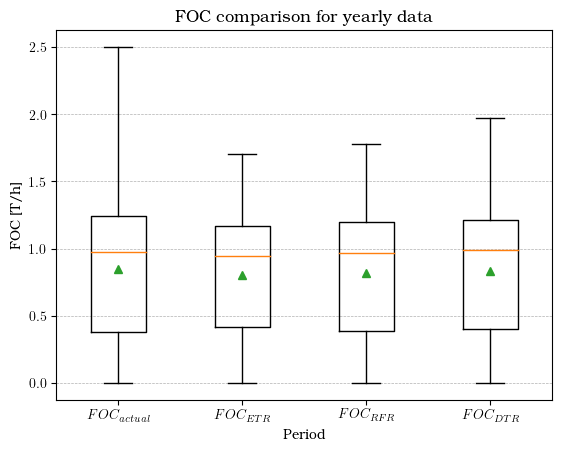

In [287]:
FOC_plot_yr(FOC_act_yr,FOC_pred_yr,FOC_pred_rf_yr,FOC_pred_dt_yr)
plt.show()